<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Cryptocurrency/Bitcoin/Bitcoin_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "mczielinski/bitcoin-historical-data"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

Saving kaggle.json to kaggle.json
boosterBytes
DeepLearning_grid_1_AutoML_20190724_234612_model_4.zip
DeepLearning_grid_1_AutoML_20190725_002546_model_1.zip
DeepLearning_grid_1_AutoML_20190725_011447_model_2.zip
DeepLearning_grid_1_AutoML_20190725_015802_model_3.zip
DeepLearning_grid_1_AutoML_20190725_021119_model_3.zip
DeepLearning_grid_1_AutoML_20190725_022250_model_1.zip
DeepLearning_grid_1_AutoML_20190725_025807_model_5.zip
domains
experimental
feature_map
features_dataset
full_dataset
GLM_grid_1_AutoML_20190725_020828_model_1.zip
GLM_grid_1_AutoML_20190725_020919_model_1.zip
GLM_grid_1_AutoML_20190725_022211_model_1.zip
GLM_grid_1_AutoML_20190725_025431_model_1.zip
h2o-3.24.0.5
h2o-3.24.0.5.zip
h2o-genmodel.jar
kaggle.json
model.gv
model.ini
predict_df
sample_data
scaled_df
ta-lib
ta-lib-0.4.0-src.tar.gz
XGBoost_grid_1_AutoML_20190725_020842_model_2.zip
XGBoost_grid_1_AutoML_20190725_021015_model_5.zip
XGBoost_grid_1_AutoML_20190725_022225_model_2.zip
XGBoost_grid_1_AutoML_2019072

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


Open     High      Low    Close        Volume  Volume_(Currency)  Weighted_Price
Date                                                                                           
2012-01-01     4.58     5.00     4.58     5.00     21.602000       1.057792e+02        5.000000
2012-01-02     5.00     5.00     5.00     5.00     19.048000       9.524000e+01        5.000000
2012-01-03     5.32     5.32     5.14     5.29     88.037281       4.648052e+02        5.290000
2012-01-04     4.93     5.57     4.93     5.57    107.233260       5.680762e+02        5.442972
2012-01-05     5.72     6.65     5.72     6.65     94.801829       5.877348e+02        6.650000
...             ...      ...      ...      ...           ...                ...             ...
2018-12-27  3810.01  3841.17  3566.00  3591.69  11850.012382       4.386927e+07     3591.677812
2018-12-28  3590.26  3970.00  3575.00  3884.97  13055.718407       4.889106e+07     3886.158322
2018-12-29  3884.66  3961.85  3702.51  3725.48   6901.382332       2.669191e+07     3718.054871
2018-12-30  3728.96  3870.00  3688.76  3835.79   5736.453708       2.172126e+07     3831.034985
2018-12-31  3831.03  3842.89  3630.00  3693.30   6667.163737       2.501076e+07     3690.607113

[2554 rows x 7 columns]

Open          High           Low         Close         Volume  Volume_(Currency)  Weighted_Price
count   2554.000000   2554.000000   2554.000000   2554.000000    2554.000000       2.554000e+03     2554.000000
mean    1864.154005   1926.928277   1789.649499   1865.696292   10482.354840       2.323909e+07     1865.535291
std     3173.637085   3296.847718   3016.170943   3173.683050   10977.935184       5.254286e+07     3173.311321
min        3.800000      4.380000      1.500000      4.230000       0.250000       1.227500e+00        4.230000
25%      134.070000    144.992500    126.230000    135.070000    3663.580355       1.141228e+06      134.824726
50%      445.350000    452.670000    434.480000    446.000000    7637.858944       3.567710e+06      446.026817
75%     1191.117500   1219.645000   1173.210000   1193.782500   13731.887552       1.779335e+07     1193.680370
max    19187.780000  19666.000000  18465.000000  19187.780000  137070.178338       7.721430e+08    19197.105613

14

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8  MIDPOINT_8  MIDPRICE_8     SAR_0.08       SMA_8       TEMA_8    TRIMA_8        WMA_8      MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2012-02-20     4.72     4.72     4.40     4.44    315.939254       1.439907e+03        4.440000   20          0         51             29             0               1               0                 1      2        1     8        0             1           8     4.544107     5.159820    -5.999942     4.305418     4.694843     4.895104       5.010        4.97     5.618514     4.70000     4.243770     4.6125     4.516389     4.70000     4.350000     5.412045                5.608900                  4.70000                3.791100                6.063351                  4.70000                3.336649                6.517801                  4.70000                2.882199                6.972251                  4.70000                2.427749     4.694843     4.432831     5.340980                5.603744                 4.694843                3.785943                6.058194                 4.694843                3.331492                6.512644                 4.694843   
2012-02-21     4.52     4.58     4.30     4.58    358.449201       1.595157e+03        4.580000   21          1         52             29             0               1               0                 1      2        1     8        1             2           8     4.545902     5.144472    -5.888345     4.346587     4.669322     4.846871       4.560        4.97     5.500233     4.54875     4.350508     4.5000     4.489722     4.54875     4.510000     5.318714                4.933124                  4.54875                4.164376                5.125312                  4.54875                3.972188                5.317499                  4.54875                3.780001                5.509686                  4.54875                3.587814     4.669322     4.526353     5.241162                5.053697                 4.669322                4.284948                5.245884                 4.669322                4.092761                5.438071                 4.669322   
2012-02-22     4.47     4.59     4.46     4.51     75.3

Open          High           Low         Close         Volume  Volume_(Currency)  Weighted_Price          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear          mama          fama        SAREXT        DEMA_8         EMA_8        KAMA_8    MIDPOINT_8    MIDPRICE_8      SAR_0.08         SMA_8        TEMA_8       TRIMA_8         WMA_8        MA_8_0      MAVP_8_0        T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5        MA_8_1      MAVP_8_1        T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  \
count   2504.000000   2504.000000   2504.000000   2504.000000    2504.000000       2.504000e+03     2504.000000  2504.000000  2504.000000  2504.000000    2504.000000   2504.000000     2504.000000     2504.000000       2504.000000  2504.000000  2504.000000  2504.000000  2504.000000   2504.000000  2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000   2504.000000   2504.000000   2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000   
mean    1901.260619   1965.281729   1825.273902   1902.832181   10690.004610       2.370312e+07     1902.668015    15.781550     3.000000   186.501997      30.465655      0.033147        0.967252        0.011182          0.989217     6.631789     2.540335    27.033546     3.000000      2.999201    27.033546   1910.213394   1911.789718    -30.133849   1902.826229   1897.568520   1918.247248   1898.157169   1880.664700   1864.987303   1897.586417   1902.884743   1897.583908   1899.336875   1897.586417   1901.280925   1887.111618             2086.650565              1897.586417             1708.522269             2181.182640              1897.586417             1613.990195             2275.714714              1897.586417             1519.458121             2370.246788              1897.586417             1424.926047   1897.568520   1901.587129   1888.652633             2086.632669              1897.568520             1708.504372             2181.164743              1897.568520   
std     3194.183801   3318.306852   3035.484045   3194.212997   10987.220677       5.296129e+07     3193.838160     8.806744     2.001597   103.972675       0.784653      0.179056        0.178011        0.105174          0.103299     3.401400     1.107113    14.850260     2.001597      2.001398    14.850260   3229.516657   3252.403584   3716.236423   3199.743401   3179.975250   3234.850493   3188.668998   3146.783961   3155.367071   3185.101202   3196.818947   3187.204445   3186.604280   3185.101202   3190.460192   3166.232749             3572.837907              3185.101202             2814.176081             3771.399359              3185.101202             2637.248108             3972.466505              3185.101202             2467.655314             4175.677400              3185.101202             2307.015933   3179.975250   3190.355207   3169.118604             3567.344357              3179.975250             2809.547615             3765.757459              3179.975250   
min        4.470000      4.580000      1.500000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open          High       Low     Close    Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear          mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8         WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2012-02-20  0.000013  7.120544e-06  0.000157  0.000000  0.002237       1.805199e-06        0.000000   20          0         51             29             0               1               0                 1      2        1     8        0             1           8  2.465101e-11  0.000016  0.536148  0.000000  0.000003  0.000004    0.000031    0.000020  0.000209  0.000011  0.000000  0.000009  1.948060e-06  0.000011  0.000000  0.000033                0.000040                 0.000011                0.000000                0.000050                 0.000011                0.003081                0.000059                 0.000011                0.007182            6.720592e-05                 0.000011                0.012011  0.000003  0.000000  0.000028                0.000034                 0.000003                0.000442                0.000046                 0.000003                0.004059                0.000059                 0.000003                0.008270   
2012-02-21  0.000003  0.000000e+00  0.000152  0.000007  0.002547       2.006263e-06        0.000007   21          1         52             29             0               1               0                 1      2        1     8        1             2           8  9.842700e-08  0.000015  0.536151  0.000002  0.000002  0.000001    0.000006    0.000020  0.000203  0.000003  0.000006  0.000002  4.755108e-07  0.000003  0.000008  0.000027                0.000007                 0.000003                0.000024                0.000009                 0.000003                0.003125                0.000010                 0.000003                0.007249            1.213868e-05                 0.000003                0.012106  0.000002  0.000005  0.000022                0.000007                 0.000002                0.000475                0.000008                 0.000002                0.004112                0.000013                 0.000002                0.008347   
2012-02-22  0.000000  5.086103e-07  0.000160  0.000004  0.000481       3.824707e-07        0.000004 

139119

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 28 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_uak9cv
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.547465   8.550028              0.492248  0.680693  0.463343
1  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.545050   1.867079              0.496124  0.657708  0.432580
2              DeepLearning_1_AutoML_20190725_032255  0.512390   0.716354              0.500000  0.503427  0.253439
3  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.500000   0.707497              0.500000  0.507058  0.257108
4  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.500000   0.698638              0.500000  0.502730  0.252738
5  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.500000   0.698708              0.500000  0.502765  0.252772
6  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.500000   0.695371              0.500000  0.501110  0.251111
7  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.500000   0.696220              0.500000  0.501532  0.251534
8  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.468833   4.430807              0.500000  0.710547  0.504878
9  DeepLearning_grid_1_AutoML_20190725_032255_mod...  0.456570  16.012712              0.500000  0.717388  0.514646

variable  relative_importance  scaled_importance  percentage
0                 CDLTHRUSTING             1.000000           1.000000    0.001588
1           CDLIDENTICAL3CROWS             0.972953           0.972953    0.001545
2            CDLDARKCLOUDCOVER             0.971171           0.971171    0.001542
3            CDL3WHITESOLDIERS             0.964084           0.964084    0.001531
4                 CDLTASUKIGAP             0.959218           0.959218    0.001523
...                        ...                  ...                ...         ...
1029   BBANDS_upperband_14_0_4             0.555043           0.555043    0.000882
1030               MIDPOINT_14             0.551384           0.551384    0.000876
1031  BBANDS_middleband_24_1_4             0.547593           0.547593    0.000870
1032                    SUM_20             0.547564           0.547564    0.000870
1033   BBANDS_middleband_8_1_2             0.545731           0.545731    0.000867

[1034 rows x 4 columns]

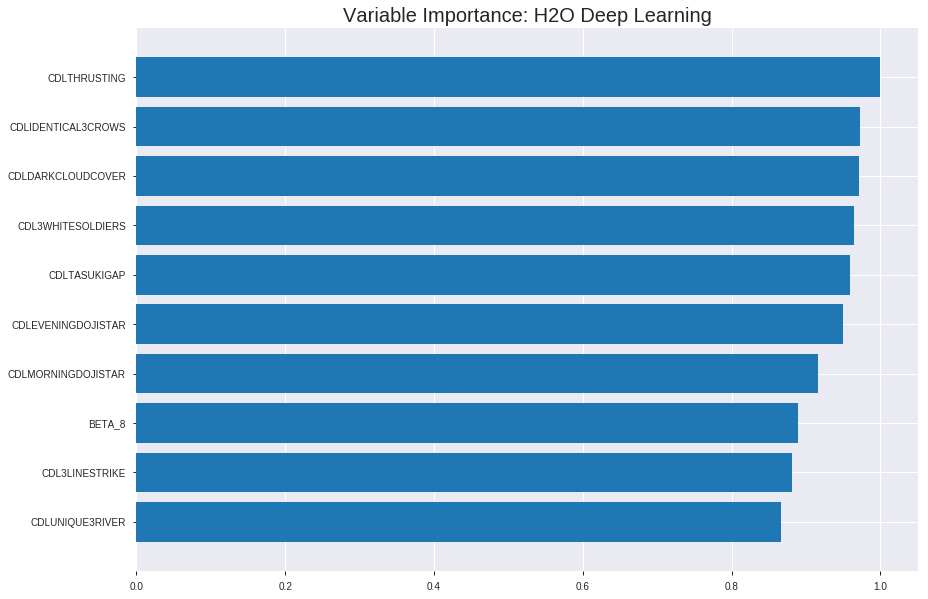

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_032255_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3584350157278675
RMSE: 0.5986944260036731
LogLoss: 1.417804024187911
Mean Per-Class Error: 0.47324774896422717
AUC: 0.5163681752613309
pr_auc: 0.5379989070187102
Gini: 0.03273635052266188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00014845092790872894: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    785   1        (785.0/785.0)
1      0    967   0        (0.0/967.0)
Total  0    1752  0.4481   (785.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000148451  0.711291   399
max f2                       0.000148451  0.86032    399
max f0point5                 0.000148451  0.60627    399
max accuracy                 0.000148451  0.551941   399
max precision                0.962196     0.596386   26
max recall                   0.000148451  1          399
max specificity              0.999895     0.949045   0
max absolute_mcc             0.61809      0.0532576  166
max min_per_class_accuracy   0.642554     0.524841   157
max mean_per_class_accuracy  0.61809      0.526752   166

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 58.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.999998           1.1072    1.1072             0.611111         1          0.611111                    1                   0.0113754       0.0113754                  10.7204   10.7204
    2        0.0205479                   0.999972           1.20786   1.15753            0.666667         0.999985   0.638889                    0.999992            0.0124095       0.0237849                  20.7859   15.7532
    3        0.0302511                   0.999905           1.17233   1.16228            0.647059         0.999941   0.641509                    0.999976            0.0113754       0.0351603                  17.2334   16.228
    4        0.0405251                   0.999794           0.60393   1.02073            0.333333         0.999859   0.56338                     0.999946            0.00620476      0.041365                   -39.607   2.07262
    5        0.0502283                   0.999631           0.852607  0.988249           0.470588         0.999697   0.545455                    0.999898            0.00827301      0.0496381                  -14.7393  -1.17514
    6        0.100457                    0.993212           1.11178   1.05001            0.613636         0.99715    0.579545                    0.998524            0.0558428       0.105481                   11.178    5.00141
    7        0.150114                    0.97769            1.08291   1.0609             0.597701         0.986416   0.585551                    0.994519            0.0537746       0.159255                   8.29084   6.08955
    8        0.200342                    0.956676           1.09119   1.06849            0.602273         0.967036   0.589744                    0.987629            0.0548087       0.214064                   9.11911   6.8491
    9        0.300228                    0.877631           1.00425   1.04712            0.554286         0.924184   0.577947                    0.96652             0.10031         0.314374                   0.424878  4.71176
    10       0.400114                    0.77235            1.0146    1.039              0.56             0.830236   0.573466                    0.932498            0.101344        0.415719                   1.46019   3.90003
    11       0.5                         0.644299           1.05601   1.0424             0.582857         0.711257   0.575342                    0.8883              0.105481        0.5212                     5.60142   4.23992
    12       0.599886                    0.506195           0.890365  1.01708            0.491429         0.576489   0.56137                     0.836381            0.0889349       0.610134                   -10.9635  1.70842
    13       0.699772                    0.344338           0.880012  0.997518           0.485714         0.428272   0.550571                    0.778128            0.0879007       0.698035                   -11.9988  -0.248157
    14       0.799658                    0.186538           1.00425   0.998359           0.554286         0.263186   0.551035                    0.713806            0.10031         0.798345                   0.424878  -0.164087
    15       0.899543                    0.0565804          0.962836  0.994415           0.531429         0.115484   0.548858                    0.647368            0.0961737       0.894519                   -3.71635  -0.558533
    16       1                           9.23461e-08        1.05001   1                  0.579545         0.0245394  0.551941              



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.49871107373258017
RMSE: 0.7061947845549272
LogLoss: 7.456755462702471
Mean Per-Class Error: 0.48774895178197064
AUC: 0.4526254585953879
pr_auc: 0.4449363142644994
Gini: -0.09474908280922423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.5728129133837922e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.57281e-51  0.730964  378
max f2                       2.57281e-51  0.871671  378
max f0point5                 3.67469e-35  0.630551  375
max accuracy                 3.67469e-35  0.578     375
max precision                0.000174499  0.583333  292
max recall                   2.57281e-51  1         378
max specificity              1            0.745283  0
max absolute_mcc             0.771624     0.109818  93
max min_per_class_accuracy   0.394848     0.45283   131
max mean_per_class_accuracy  0.000174499  0.512251  292

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.166                       1                  0.878514  0.878514           0.506024         1            0.506024                    1                   0.145833        0.145833                   -12.1486  -12.1486
    2        0.2                         1                  0.816993  0.868056           0.470588         1            0.5                         1                   0.0277778       0.173611                   -18.3007  -13.1944
    3        0.3                         0.99997            1.00694   0.914352           0.58             0.999996     0.526667                    0.999999            0.100694        0.274306                   0.694444  -8.56481
    4        0.4                         0.893564           0.833333  0.894097           0.48             0.978445     0.515                       0.99461             0.0833333       0.357639                   -16.6667  -10.5903
    5        0.5                         0.38991            1.00694   0.916667           0.58             0.610696     0.528                       0.917827            0.100694        0.458333                   0.694444  -8.33333
    6        0.6                         0.112699           1.18056   0.960648           0.68             0.214704     0.553333                    0.80064             0.118056        0.576389                   18.0556   -3.93519
    7        0.7                         0.0241889          1.00694   0.967262           0.58             0.0544536    0.557143                    0.694042            0.100694        0.677083                   0.694444  -3.27381
    8        0.8                         0.000278049        1.25      1.0026             0.72             0.00843248   0.5775                      0.608341            0.125           0.802083                   25        0.260417
    9        0.9                         7.85101e-09        0.902778  0.991512           0.52             5.47561e-05  0.571111                    0.540753            0.0902778       0.892361                   -9.72222  -0.848765
    10       1                           2.78149e-76        1.07639   1                  0.62             3.90955e-10  0.576                       0.486678            0.107639        1                          7.63889   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 03:27:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 03:28:00  7.323 sec         152 obs/sec       0.389269  1             682        0.639765         3.27195             -0.655055      0.495211        0.415038           0.905895         0.444064                         0.651152           13.1462               -0.736107        0.465368          0.0749499            0.918819           0.422
    2019-07-25 03:28:29  35.800 sec        157 obs/sec       2.71747   7             4761       0.589858         1.73989             -0.406912      0.588317        0.631068           1.30851          0.448059                         0.747596           8.53313               -1.28847         0.479748          0.529589             1.15741            0.424
    2019-07-25 03:28:59  1 min  6.057 sec  165 obs/sec       5.46404   14            9573       0.598694         1.4178              -0.449381      0.516368        0.537999           1.1072           0.448059                         0.706195           7.45676               -1.04202         0.452625          0.444936             0.878514           0.424
    2019-07-25 03:29:27  1 min 34.407 sec  172 obs/sec       8.20205   21            14370      0.583222         1.71543             -0.375434      0.565718        0.527633           1.30851          0.421804                         0.651142           12.8184               -0.736054        0.457907          0.123204             0.923895           0.422
    2019-07-25 03:29:58  2 min  5.552 sec  177 obs/sec       11.3196   29            19832      0.548695         1.55822             -0.217403      0.621014        0.568798           1.30851          0.417237                         0.653151           11.3557               -0.746785        0.44243           0.194195             0.934829           0.42
    2019-07-25 03:30:28  2 min 34.727 sec  183 obs/sec       14.476    37            25362      0.538404         1.22544             -0.172165      0.644833        0.660538           1.71113          0.448059                         0.748978           11.198                -1.29694         0.568036          0.620616             1.38889            0.424
    2019-07-25 03:30:31  2 min 37.548 sec  183 obs/sec       14.476    37            25362      0.598694         1.4178              -0.449381      0.516368        0.537999           1.1072           0.448059                         0.706195           7.45676               -1.04202         0.452625          0.444936             0.878514           0.424

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLTHRUSTING              1.0                    1.0                  0.001588188157439889
CDLIDENTICAL3CROWS        0.9729526042938232     0.9729526042938232   0.0015452318038897486
CDLDARKCLOUDCOVER         0.9711713790893555     0.9711713790893555   0.0015424028831142794
CDL3WHITESOLDIERS         0.9640836715698242     0.9640836715698242   0.0015311462699683623
CDLTASUKIGAP              0.9592182636260986     0.9592182636260986   0.0015234190866910233
---                       ---                    ---                  ---
BBANDS_upperband_14_0_4   0.5550431609153748     0.5550431609153748   0.0008815129750338009
MIDPOINT_14               0.551383912563324      0.551383912563324    0.0008757014001359424
BBANDS_middleband_24_1_4  0.5475926399230957     0.5475926399230957   0.000869680145827106
SUM_20                    0.5475643873214722     0.5475643873214722   0.0008696352753797906
BBANDS_middleband_8_1_2   0.5457313656806946     0.5457313656806946   0.0008667240921175766


See the whole table with table.as_data_frame()


('accuracy', 0.545816733067729)

('F1', 0.6576819407008087)

('auc', 0.5474647350362181)

('logloss', 8.550027719374235)

('mean_per_class_error', 0.44996187571483026)

('rmse', 0.6806933063745484)

('mse', 0.46334337734311476)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


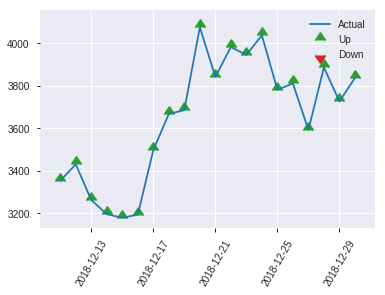


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.46334337734311476
RMSE: 0.6806933063745484
LogLoss: 8.550027719374235
Mean Per-Class Error: 0.44996187571483026
AUC: 0.5474647350362181
pr_auc: 0.33424467019423276
Gini: 0.09492947007243613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.953294807111417e-21: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    127  0.9845   (127.0/129.0)
1      0    122  0        (0.0/122.0)
Total  2    249  0.506    (127.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       5.95329e-21  0.657682  168
max f2                       5.95329e-21  0.82768   168
max f0point5                 2.55829e-07  0.561002  118
max accuracy                 0.999993     0.545817  9
max precision                0.999993     0.544444  9
max recall                   5.95329e-21  1         168
max specificity              1            0.72093   0
max absolute_mcc             2.55829e-07  0.123418  118
max min_per_class_accuracy   0.90006      0.511628  45
max mean_per_class_accuracy  2.55829e-07  0.550038  118

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 52.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.167331                    1                  1.02869   1.02869            0.5              1            0.5                         1                   0.172131        0.172131                   2.86885   2.86885
    2        0.203187                    1                  0.91439   1.00852            0.444444         1            0.490196                    1                   0.0327869       0.204918                   -8.56102  0.851816
    3        0.302789                    1                  1.23443   1.08283            0.6              1            0.526316                    1                   0.122951        0.327869                   23.4426   8.283
    4        0.40239                     0.99991            0.905246  1.03887            0.44             0.999975     0.50495                     0.999994            0.0901639       0.418033                   -9.47541  3.88736
    5        0.501992                    0.90006            0.987541  1.02869            0.48             0.981262     0.5                         0.996277            0.0983607       0.516393                   -1.2459   2.86885
    6        0.601594                    0.00916301         1.31672   1.07638            0.64             0.235928     0.523179                    0.870392            0.131148        0.647541                   31.6721   7.63761
    7        0.701195                    2.73172e-05        0.822951  1.04038            0.4              0.00125592   0.505682                    0.746935            0.0819672       0.729508                   -17.7049  4.03782
    8        0.800797                    2.16762e-07        1.15213   1.05428            0.56             4.69505e-06  0.512438                    0.654033            0.114754        0.844262                   15.2131   5.42778
    9        0.900398                    3.15844e-09        0.905246  1.03779            0.44             5.5452e-08   0.504425                    0.581684            0.0901639       0.934426                   -9.47541  3.7792
    10       1                           2.72479e-22        0.658361  1                  0.32             2.573e-10    0.486056                    0.523748            0.0655738       1                          -34.1639  0

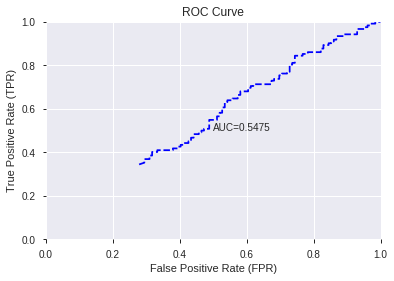

This function is available for GLM models only


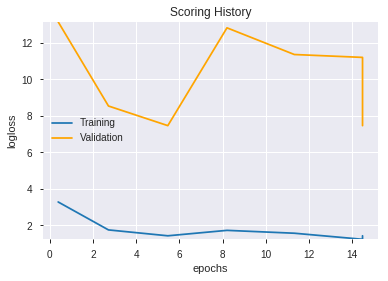

--2019-07-25 03:53:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.100|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_032255_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_032255_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_035406_model_6  0.519443   0.806724              0.500000  0.540795  0.292459
1  DeepLearning_grid_1_AutoML_20190725_035406_model_4  0.499841   7.198925              0.488372  0.679148  0.461242
2               DeepLearning_1_AutoML_20190725_035406  0.498856   2.422180              0.492248  0.650962  0.423752
3  DeepLearning_grid_1_AutoML_20190725_035406_model_1  0.495743   8.353965              0.488372  0.691875  0.478691
4  DeepLearning_grid_1_AutoML_20190725_035406_model_8  0.492883   0.720394              0.492248  0.512288  0.262438
5  DeepLearning_grid_1_AutoML_20190725_035406_model_5  0.486466   0.746574              0.481065  0.517970  0.268293
6  DeepLearning_grid_1_AutoML_20190725_035406_model_2  0.484687  13.163759              0.488372  0.704223  0.495929
7  DeepLearning_grid_1_AutoML_20190725_035406_model_7  0.478333   1.166590              0.500000  0.616533  0.380113
8  DeepLearning_grid_1_AutoML_20190725_035406_model_9  0.477348   0.700582              0.496124  0.503650  0.253663
9  DeepLearning_grid_1_AutoML_20190725_035406_model_3  0.471470  13.480493              0.488372  0.708785  0.502377

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_14_3_4             1.000000           1.000000    0.028450
1               weekday_name             0.915334           0.915334    0.026041
2                       ATAN             0.863098           0.863098    0.024555
3                     VAR_12             0.775124           0.775124    0.022052
4               CDLSHORTLINE             0.765156           0.765156    0.021769
5                     VAR_14             0.762782           0.762782    0.021701
6                       TANH             0.760745           0.760745    0.021643
7                    BETA_12             0.756382           0.756382    0.021519
8                    BETA_20             0.752327           0.752327    0.021404
9                        COS             0.745445           0.745445    0.021208
10                     VAR_8             0.732728           0.732728    0.020846
11                    VAR_30             0.725246           0.725246    0.020633
12                   BETA_30             0.721161           0.721161    0.020517
13                    VAR_24             0.720727           0.720727    0.020505
14                    VAR_20             0.719792           0.719792    0.020478
15           CDLUNIQUE3RIVER             0.718801           0.718801    0.020450
16                       TAN             0.711358           0.711358    0.020238
17         CDLDARKCLOUDCOVER             0.705852           0.705852    0.020082
18         CDLSTALLEDPATTERN             0.703984           0.703984    0.020028
19         CDLINVERTEDHAMMER             0.703842           0.703842    0.020024
20           CDLHOMINGPIGEON             0.699057           0.699057    0.019888
21                   BETA_14             0.697569           0.697569    0.019846
22                   BETA_24             0.697202           0.697202    0.019835
23                       SIN             0.691388           0.691388    0.019670
24            CDLMORNINGSTAR             0.689701           0.689701    0.019622
25            CDLEVENINGSTAR             0.686750           0.686750    0.019538
26        CDLMORNINGDOJISTAR             0.686347           0.686347    0.019527
27           CDLSHOOTINGSTAR             0.679696           0.679696    0.019337
28          is_quarter_start             0.677353           0.677353    0.019271
29            CDLMATCHINGLOW             0.673117           0.673117    0.019150
30            CDLHARAMICROSS             0.668287           0.668287    0.019013
31               CDLDOJISTAR             0.667749           0.667749    0.018998
32              CDLTHRUSTING             0.667271           0.667271    0.018984
33              is_month_end             0.665770           0.665770    0.018941
34              CDLTASUKIGAP             0.661530           0.661530    0.018821
35                    BETA_8             0.658522           0.658522    0.018735
36        CDLIDENTICAL3CROWS             0.658167           0.658167    0.018725
37           CDLADVANCEBLOCK             0.658021           0.658021    0.018721
38       CDLGAPSIDESIDEWHITE             0.655818           0.655818    0.018658
39                CDL3INSIDE             0.655136           0.655136    0.018639
40         CDLGRAVESTONEDOJI             0.652681           0.652681    0.018569
41        CDLEVENINGDOJISTAR             0.651781           0.651781    0.018543
42             CDLHIKKAKEMOD             0.650231           0.650231    0.018499
43            CDL3LINESTRIKE             0.648897           0.648897    0.018461
44             CDLHANGINGMAN             0.643275           0.643275    0.018301
45         CDL3WHITESOLDIERS             0.637591           0.637591    0.018140
46                       DIV             0.634627           0.634627    0.018055
47        CDLSEPARATINGLINES             0.633118           0.633118    0.018012
48       CDLXSIDEGAP3METHODS             0.628557  

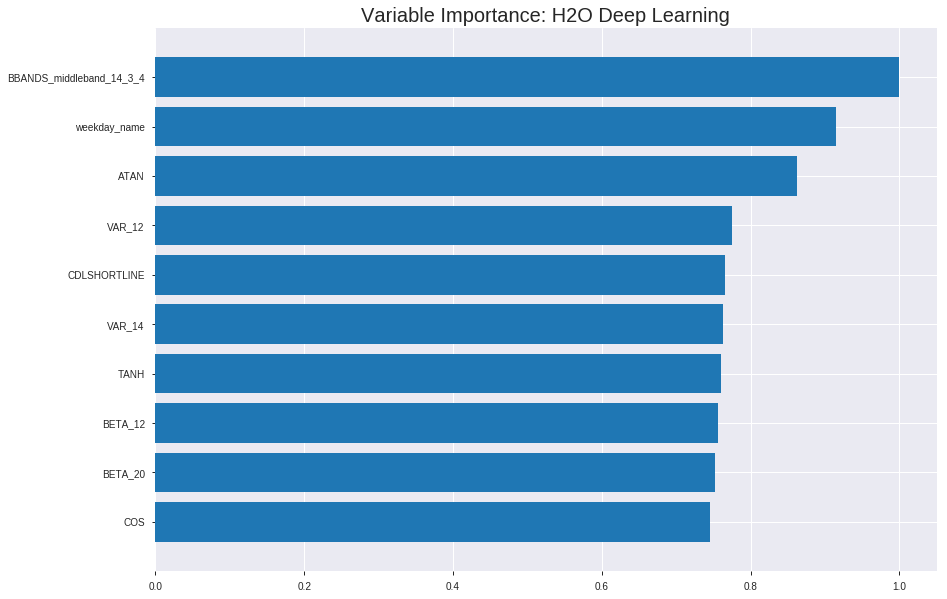

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_035406_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2444947191844882
RMSE: 0.49446407269334364
LogLoss: 0.681269780900068
Mean Per-Class Error: 0.42513453520310374
AUC: 0.6030747139686073
pr_auc: 0.662910868570122
Gini: 0.2061494279372147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31846282590328034: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   773   0.9847   (773.0/785.0)
1      1    966   0.001    (1.0/967.0)
Total  13   1739  0.4418   (774.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318463     0.713969  389
max f2                       0.291956     0.861547  394
max f0point5                 0.433924     0.622968  285
max accuracy                 0.433924     0.583333  285
max precision                0.925612     1         0
max recall                   0.291956     1         394
max specificity              0.925612     1         0
max absolute_mcc             0.520173     0.177554  144
max min_per_class_accuracy   0.452112     0.550318  249
max mean_per_class_accuracy  0.479167     0.574865  201

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 47.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.737348           1.71113   1.71113            0.944444         0.808573  0.944444                    0.808573            0.0175801       0.0175801                  71.1134   71.1134
    2        0.0205479                   0.683091           1.50982   1.61048            0.833333         0.709907  0.888889                    0.75924             0.0155119       0.033092                   50.9824   61.0479
    3        0.0302511                   0.651267           1.49206   1.5725             0.823529         0.664187  0.867925                    0.728751            0.0144778       0.0475698                  49.2062   57.2496
    4        0.0405251                   0.62988            1.40917   1.53109            0.777778         0.638388  0.84507                     0.705842            0.0144778       0.0620476                  40.9169   53.1089
    5        0.0502283                   0.608241           1.49206   1.52355            0.823529         0.61881   0.840909                    0.689029            0.0144778       0.0765253                  49.2062   52.355
    6        0.100457                    0.558912           1.21472   1.36914            0.670455         0.580417  0.755682                    0.634723            0.0610134       0.137539                   21.4722   36.9136
    7        0.150114                    0.528015           1.33281   1.35712            0.735632         0.542394  0.749049                    0.604181            0.0661841       0.203723                   33.281    35.712
    8        0.200342                    0.511032           1.11178   1.29561            0.613636         0.519211  0.7151                      0.582878            0.0558428       0.259566                   11.178    29.561
    9        0.300228                    0.484364           1.02495   1.20556            0.565714         0.496711  0.665399                    0.55421             0.102378        0.361944                   2.49549   20.5563
    10       0.400114                    0.466946           0.983543  1.15014            0.542857         0.475226  0.634807                    0.534492            0.098242        0.460186                   -1.64574  15.0137
    11       0.5                         0.452823           0.880012  1.09617            0.485714         0.459895  0.605023                    0.51959             0.0879007       0.548087                   -11.9988  9.61737
    12       0.599886                    0.443013           1.07672   1.09293            0.594286         0.447104  0.603235                    0.50752             0.107549        0.655636                   7.67203   9.29346
    13       0.699772                    0.433258           1.00425   1.08028            0.554286         0.43838   0.596248                    0.497651            0.10031         0.755946                   0.424878  8.02755
    14       0.799658                    0.425142           0.859306  1.05267            0.474286         0.429501  0.581014                    0.489138            0.0858325       0.841779                   -14.0694  5.2674
    15       0.899543                    0.40893            0.869659  1.03235            0.48             0.417937  0.569797                    0.481232            0.0868666       0.928645                   -13.0341  3.23519
    16       1                           0.234652           0.710304  1                  0.392045         0.377042  0.551941                    0.470766            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31761755030095334
RMSE: 0.5635756828509844
LogLoss: 1.2130717489150402
Mean Per-Class Error: 0.4710429769392034
AUC: 0.49515199161425577
pr_auc: 0.5436043581970521
Gini: -0.009696016771488458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.002634141705105704: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    206  0.9717   (206.0/212.0)
1      0    288  0        (0.0/288.0)
Total  6    494  0.412    (206.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00263414   0.736573  396
max f2                       0.00263414   0.874848  396
max f0point5                 0.212418     0.638095  356
max accuracy                 0.212418     0.59      356
max precision                0.999996     0.615385  0
max recall                   0.00263414   1         396
max specificity              0.999996     0.976415  0
max absolute_mcc             0.00263414   0.128452  396
max min_per_class_accuracy   0.418221     0.5       200
max mean_per_class_accuracy  0.212418     0.528957  356

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        1                  1.04167   1.04167            0.6              1         0.6                         1                   0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.999996           1.38889   1.21528            0.8              0.999999  0.7                         1                   0.0138889       0.0243056                  38.8889   21.5278
    3        0.03                        0.999931           0.694444  1.04167            0.4              0.999972  0.6                         0.99999             0.00694444      0.03125                    -30.5556  4.16667
    4        0.04                        0.999609           0.347222  0.868056           0.2              0.999877  0.5                         0.999962            0.00347222      0.0347222                  -65.2778  -13.1944
    5        0.05                        0.999301           1.04167   0.902778           0.6              0.999474  0.52                        0.999864            0.0104167       0.0451389                  4.16667   -9.72222
    6        0.1                         0.980791           0.763889  0.833333           0.44             0.992766  0.48                        0.996315            0.0381944       0.0833333                  -23.6111  -16.6667
    7        0.15                        0.817057           1.04167   0.902778           0.6              0.916873  0.52                        0.969834            0.0520833       0.135417                   4.16667   -9.72222
    8        0.2                         0.668768           0.763889  0.868056           0.44             0.745733  0.5                         0.913809            0.0381944       0.173611                   -23.6111  -13.1944
    9        0.3                         0.485362           1.00694   0.914352           0.58             0.565838  0.526667                    0.797819            0.100694        0.274306                   0.694444  -8.56481
    10       0.4                         0.434354           1.21528   0.989583           0.7              0.454792  0.57                        0.712062            0.121528        0.395833                   21.5278   -1.04167
    11       0.5                         0.418134           1.04167   1                  0.6              0.425684  0.576                       0.654786            0.104167        0.5                        4.16667   0
    12       0.6                         0.405597           1.14583   1.02431            0.66             0.412169  0.59                        0.61435             0.114583        0.614583                   14.5833   2.43056
    13       0.7                         0.391106           0.9375    1.0119             0.54             0.398037  0.582857                    0.583448            0.09375         0.708333                   -6.25     1.19048
    14       0.8                         0.359823           0.868056  0.993924           0.5              0.376255  0.5725                      0.557549            0.0868056       0.795139                   -13.1944  -0.607639
    15       0.9                         0.244582           1.25      1.02238            0.72             0.324476  0.588889                    0.531652            0.125           0.920139                   25        2.23765
    16       1                           1.44711e-05        0.798611  1                  0.46             0.12119   0.576                       0.490606      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 03:57:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 03:57:55  1 min 58.479 sec  902 obs/sec       1.33961   1             2347       0.52654          0.764117            -0.121073      0.541104        0.588562           1.50982          0.448059                         0.629182           4.52522               -0.620928        0.435576          0.447401             0.803755           0.424
    2019-07-25 03:58:04  2 min  7.088 sec  2025 obs/sec      12.105    9             21208      0.494464         0.68127             0.0113523      0.603075        0.662911           1.71113          0.441781                         0.563576           1.21307               -0.300517        0.495152          0.543604             1.04167            0.412
    2019-07-25 03:58:12  2 min 15.267 sec  2369 obs/sec      24.1667   18            42340      0.483903         0.659271            0.0531328      0.620553        0.678568           1.71113          0.417808                         0.590128           4.06627               -0.425948        0.429384          0.451382             0.798611           0.424
    2019-07-25 03:58:21  2 min 23.759 sec  2571 obs/sec      37.5862   28            65851      0.482528         0.655718            0.0585078      0.633274        0.687375           1.81179          0.415525                         0.579758           3.60047               -0.376276        0.430023          0.467529             0.795718           0.424
    2019-07-25 03:58:29  2 min 31.642 sec  2727 obs/sec      51.0046   38            89360      0.475984         0.64164             0.0838697      0.646729        0.69844            1.81179          0.405251                         0.595319           4.72679               -0.451145        0.430212          0.434478             0.868056           0.424
    2019-07-25 03:58:37  2 min 39.572 sec  2822 obs/sec      64.3967   48            112823     0.475048         0.638859            0.0874719      0.661182        0.713718           1.81179          0.394977                         0.603595           5.39786               -0.491771        0.43976           0.403116             0.859287           0.424
    2019-07-25 03:58:44  2 min 47.177 sec  2908 obs/sec      77.7814   58            136273     0.470756         0.630363            0.103884       0.667256        0.71686            1.71113          0.388699                         0.605228           5.40226               -0.499858        0.438728          0.404441             0.859287           0.424
    2019-07-25 03:58:45  2 min 47.925 sec  2907 obs/sec      77.7814   58            136273     0.494464         0.68127             0.0113523      0.603075        0.662911           1.71113          0.441781                         0.563576           1.21307               -0.300517        0.495152          0.543604             1.04167            0.412

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BBANDS_middleband_14_3_4  1.0                    1.0                  0.028450128884614602
weekday_name              0.9153342843055725     0.9153342843055725   0.026041378361
ATAN                      0.8630982637405396     0.8630982637405396   0.024555256843505437
VAR_12                    0.775124192237854      0.775124192237854    0.022052383170749732
CDLSHORTLINE              0.7651563882827759     0.7651563882827759   0.021768797863531187
---                       ---                    ---                  ---
CDL3WHITESOLDIERS         0.6375911831855774     0.6375911831855774   0.018139551337323596
DIV                       0.634627103805542      0.634627103805542    0.01805522289693736
CDLSEPARATINGLINES        0.6331183314323425     0.6331183314323425   0.01801229812846229
CDLXSIDEGAP3METHODS       0.6285569667816162     0.6285569667816162   0.017882526716259402
CDLRICKSHAWMAN            0.6141314506530762     0.6141314506530762   0.01747211892317535


See the whole table with table.as_data_frame()


('accuracy', 0.5378486055776892)

('F1', 0.6541554959785523)

('auc', 0.5194433854365231)

('logloss', 0.8067236435835321)

('mean_per_class_error', 0.46317829457364335)

('rmse', 0.5407951629857879)

('mse', 0.29245940830882483)

deeplearning prediction progress: |███████████████████████████████████████| 100%


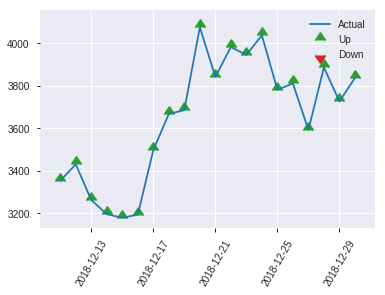


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29245940830882483
RMSE: 0.5407951629857879
LogLoss: 0.8067236435835321
Mean Per-Class Error: 0.46317829457364335
AUC: 0.5194433854365231
pr_auc: 0.4998443638910545
Gini: 0.03888677087304626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06796466712539385: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    129  1        (129.0/129.0)
1      0    122  0        (0.0/122.0)
Total  0    251  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0679647    0.654155   250
max f2                       0.0679647    0.82544    250
max f0point5                 0.138573     0.549713   230
max accuracy                 0.530229     0.537849   37
max precision                0.939108     1          0
max recall                   0.0679647    1          250
max specificity              0.939108     1          0
max absolute_mcc             0.138573     0.0800986  230
max min_per_class_accuracy   0.316364     0.51938    125
max mean_per_class_accuracy  0.325438     0.536822   115

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 35.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.911441           1.37158   1.37158            0.666667         0.92864   0.666667                    0.92864             0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.867834           0.685792  1.02869            0.333333         0.884906  0.5                         0.906773            0.00819672      0.0245902                  -31.4208  2.86885
    3        0.0318725                   0.751726           2.05738   1.28586            1                0.783481  0.625                       0.87595             0.0163934       0.0409836                  105.738   28.5861
    4        0.0438247                   0.737202           0         0.935171           0                0.746185  0.454545                    0.84056             0               0.0409836                  -100      -6.48286
    5        0.0517928                   0.711199           1.02869   0.949559           0.5              0.727406  0.461538                    0.823151            0.00819672      0.0491803                  2.86885   -5.04414
    6        0.103586                    0.587366           1.26608   1.10782            0.615385         0.64582   0.538462                    0.734486            0.0655738       0.114754                   26.6078   10.7818
    7        0.151394                    0.525272           1.37158   1.19111            0.666667         0.559801  0.578947                    0.679322            0.0655738       0.180328                   37.1585   19.1113
    8        0.203187                    0.483272           0.791299  1.0892             0.384615         0.496547  0.529412                    0.632732            0.0409836       0.221311                   -20.8701  8.91996
    9        0.302789                    0.366052           0.905246  1.02869            0.44             0.420932  0.5                         0.563061            0.0901639       0.311475                   -9.47541  2.86885
    10       0.40239                     0.336447           1.23443   1.07961            0.6              0.348595  0.524752                    0.509975            0.122951        0.434426                   23.4426   7.96137
    11       0.501992                    0.316364           0.905246  1.04502            0.44             0.32669   0.507937                    0.473609            0.0901639       0.52459                    -9.47541  4.50169
    12       0.601594                    0.295433           0.822951  1.00825            0.4              0.302085  0.490066                    0.445211            0.0819672       0.606557                   -17.7049  0.8251
    13       0.701195                    0.27259            1.15213   1.02869            0.56             0.283237  0.5                         0.422204            0.114754        0.721311                   15.2131   2.86885
    14       0.800797                    0.232767           0.905246  1.01333            0.44             0.255834  0.492537                    0.401511            0.0901639       0.811475                   -9.47541  1.3335
    15       0.900398                    0.150006           0.987541  1.01048            0.48             0.184599  0.49115                     0.377516            0.0983607       0.909836                   -1.2459   1.04816
    16       1                           0.0679647          0.905246  1                  0.44             0.114239  0.486056                    0.351293         

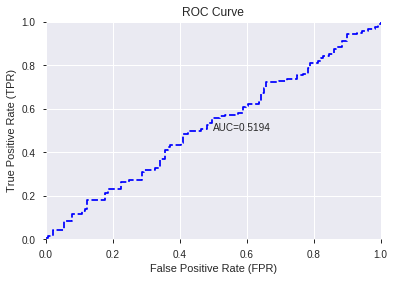

This function is available for GLM models only


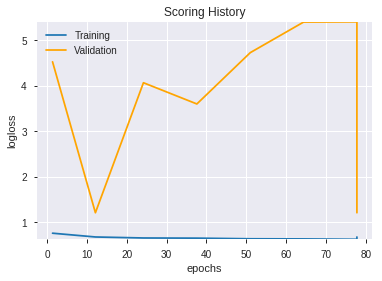

--2019-07-25 04:03:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_035406_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_035406_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_middleband_14_3_4',
 'weekday_name',
 'ATAN',
 'VAR_12',
 'CDLSHORTLINE',
 'VAR_14',
 'TANH',
 'BETA_12',
 'BETA_20',
 'COS',
 'VAR_8',
 'VAR_30',
 'BETA_30',
 'VAR_24',
 'VAR_20',
 'CDLUNIQUE3RIVER',
 'TAN',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'CDLINVERTEDHAMMER',
 'CDLHOMINGPIGEON',
 'BETA_14',
 'BETA_24',
 'SIN',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CDLHARAMICROSS',
 'CDLDOJISTAR',
 'CDLTHRUSTING',
 'is_month_end',
 'CDLTASUKIGAP',
 'BETA_8',
 'CDLIDENTICAL3CROWS',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDL3LINESTRIKE',
 'CDLHANGINGMAN',
 'CDL3WHITESOLDIERS',
 'DIV',
 'CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS',
 'CDLRICKSHAWMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_040321_model_1  0.507561  0.696945               0.48062  0.501877  0.251881

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_14_3_4             0.009258           1.000000    0.090523
1                       ATAN             0.005976           0.645485    0.058431
2               weekday_name             0.005647           0.609961    0.055216
3               CDLSHORTLINE             0.005432           0.586729    0.053113
4            CDLHOMINGPIGEON             0.004480           0.483884    0.043803
5          CDL3WHITESOLDIERS             0.004246           0.458631    0.041517
6             CDLRICKSHAWMAN             0.003801           0.410542    0.037163
7          CDLINVERTEDHAMMER             0.003606           0.389521    0.035261
8         CDLEVENINGDOJISTAR             0.003436           0.371185    0.033601
9                       TANH             0.003325           0.359170    0.032513
10             CDLHIKKAKEMOD             0.003249           0.350901    0.031765
11            CDLHARAMICROSS             0.003239           0.349872    0.031672
12              CDLTASUKIGAP             0.003045           0.328895    0.029773
13             CDLHANGINGMAN             0.002826           0.305261    0.027633
14            CDLEVENINGSTAR             0.002542           0.274545    0.024853
15                       DIV             0.002487           0.268668    0.024321
16        CDLIDENTICAL3CROWS             0.002462           0.265990    0.024078
17              CDLTHRUSTING             0.002406           0.259892    0.023526
18                       COS             0.002294           0.247753    0.022427
19           CDLUNIQUE3RIVER             0.002204           0.238120    0.021555
20        CDLMORNINGDOJISTAR             0.002117           0.228681    0.020701
21                       TAN             0.002057           0.222212    0.020115
22          is_quarter_start             0.001918           0.207131    0.018750
23           CDLSHOOTINGSTAR             0.001531           0.165378    0.014971
24               CDLDOJISTAR             0.001483           0.160240    0.014505
25              is_month_end             0.001478           0.159622    0.014449
26           CDLADVANCEBLOCK             0.001420           0.153421    0.013888
27                       SIN             0.001420           0.153414    0.013888
28                    VAR_12             0.001227           0.132517    0.011996
29                    VAR_14             0.001182           0.127695    0.011559
30                CDL3INSIDE             0.001027           0.110892    0.010038
31       CDLXSIDEGAP3METHODS             0.000878           0.094868    0.008588
32                     VAR_8             0.000854           0.092216    0.008348
33            CDLMATCHINGLOW             0.000846           0.091342    0.008269
34                   BETA_20             0.000788           0.085113    0.007705
35            CDLMORNINGSTAR             0.000667           0.072013    0.006519
36                    VAR_20             0.000620           0.066969    0.006062
37       CDLGAPSIDESIDEWHITE             0.000609           0.065801    0.005957
38                    BETA_8             0.000579           0.062531    0.005660
39         CDLGRAVESTONEDOJI             0.000533           0.057568    0.005211
40        CDLSEPARATINGLINES             0.000509           0.054945    0.004974
41         CDLDARKCLOUDCOVER             0.000458           0.049504    0.004481
42                   BETA_14             0.000407           0.043919    0.003976
43                    VAR_24             0.000402           0.043400    0.003929
44                    VAR_30             0.000343           0.037034    0.003352
45         CDLSTALLEDPATTERN             0.000314           0.033936    0.003072
46            CDL3LINESTRIKE             0.000302           0.032591    0.002950
47                   BETA_24             0.000224           0.024213    0.002192
48                   BETA_12             0.000118  

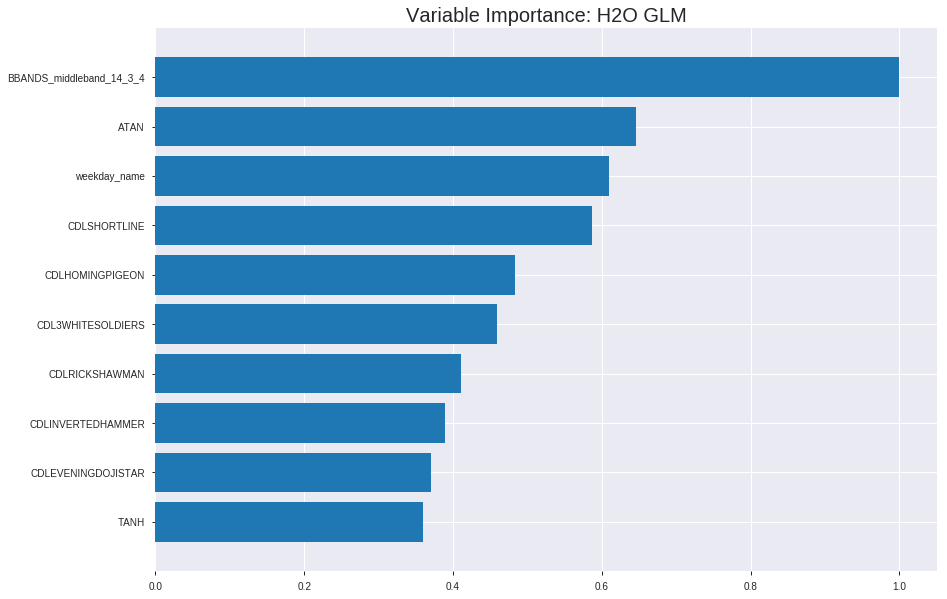

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_040321_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.246510687365575
RMSE: 0.49649842634753133
LogLoss: 0.686138546220004
Null degrees of freedom: 1751
Residual degrees of freedom: 1702
Null deviance: 2409.84717619812
Residual deviance: 2404.2294659548947
AIC: 2504.2294659548947
AUC: 0.5844762513255917
pr_auc: 0.6370110546582007
Gini: 0.16895250265118333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5378290288563885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    781   0.9949   (781.0/785.0)
1      0    967   0        (0.0/967.0)
Total  4    1748  0.4458   (781.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.537829     0.712339  395
max f2                       0.537829     0.860933  395
max f0point5                 0.549586     0.613696  260
max accuracy                 0.550476     0.571918  240
max precision                0.587014     1         0
max recall                   0.537829     1         395
max specificity              0.587014     1         0
max absolute_mcc             0.554166     0.155017  153
max min_per_class_accuracy   0.551301     0.556688  220
max mean_per_class_accuracy  0.553966     0.569042  157

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.568492           1.81179   1.81179            1                0.576795  1                           0.576795            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.564452           1.1072    1.4595             0.611111         0.565953  0.805556                    0.571374            0.0113754       0.0299897                  10.7204   45.9497
    3        0.0302511                   0.563103           0.959182  1.29902            0.529412         0.563621  0.716981                    0.568887            0.00930714      0.0392968                  -4.08176  29.9019
    4        0.0405251                   0.562435           1.30851   1.30143            0.722222         0.562853  0.71831                     0.567357            0.0134436       0.0527404                  30.8514   30.1426
    5        0.0502283                   0.561767           1.38549   1.31766            0.764706         0.562111  0.727273                    0.566344            0.0134436       0.0661841                  38.5486   31.7665
    6        0.100457                    0.558131           1.23531   1.27649            0.681818         0.559874  0.704545                    0.563109            0.0620476       0.128232                   23.5311   27.6488
    7        0.150114                    0.556005           1.14538   1.23312            0.632184         0.556951  0.680608                    0.561072            0.0568769       0.185109                   14.5384   23.3119
    8        0.200342                    0.55496            1.19413   1.22334            0.659091         0.555462  0.675214                    0.559666            0.0599793       0.245088                   19.4134   22.3345
    9        0.300228                    0.553543           1.12849   1.19179            0.622857         0.554228  0.657795                    0.557857            0.11272         0.357808                   12.8486   19.1785
    10       0.400114                    0.552461           0.962836  1.13463            0.531429         0.552953  0.626248                    0.556632            0.0961737       0.453981                   -3.71635  13.463
    11       0.5                         0.551371           0.97319   1.10238            0.537143         0.5519    0.608447                    0.555687            0.0972079       0.551189                   -2.68105  10.2378
    12       0.599886                    0.55036            1.02495   1.08949            0.565714         0.550881  0.601332                    0.554887            0.102378        0.653568                   2.49549   8.94868
    13       0.699772                    0.549303           0.859306  1.05663            0.474286         0.549824  0.583197                    0.554164            0.0858325       0.7394                     -14.0694  5.66306
    14       0.799658                    0.548196           0.869659  1.03328            0.48             0.548824  0.570307                    0.553497            0.0868666       0.826267                   -13.0341  3.32758
    15       0.899543                    0.546496           0.817893  1.00936            0.451429         0.547368  0.557107                    0.552817            0.081696        0.907963                   -18.2107  0.935963
    16       1                           0.521138           0.916189  1                  0.505682         0.544097  0.551941                    0.551941         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2708358090794702
RMSE: 0.5204188784810464
LogLoss: 0.7998030939382607
Null degrees of freedom: 499
Residual degrees of freedom: 450
Null deviance: 682.7250417755
Residual deviance: 799.8030939382606
AIC: 899.8030939382606
AUC: 0.4698964884696017
pr_auc: 0.5389155691429259
Gini: -0.060207023060796616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.50371699790446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503717     0.730964  399
max f2                       0.503717     0.871671  399
max f0point5                 0.516819     0.631649  391
max accuracy                 0.516819     0.58      391
max precision                0.99886      0.666667  0
max recall                   0.503717     1         399
max specificity              0.99886      0.995283  0
max absolute_mcc             0.550191     0.109045  195
max min_per_class_accuracy   0.546368     0.466981  225
max mean_per_class_accuracy  0.537255     0.52876   313

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 60.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.996216           1.04167   1.04167            0.6              0.998711  0.6                         0.998711            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.98946            0.694444  0.868056           0.4              0.993536  0.5                         0.996124            0.00694444      0.0173611                  -30.5556  -13.1944
    3        0.03                        0.969838           0.694444  0.810185           0.4              0.983648  0.466667                    0.991965            0.00694444      0.0243056                  -30.5556  -18.9815
    4        0.04                        0.952017           0.694444  0.78125            0.4              0.962295  0.45                        0.984547            0.00694444      0.03125                    -30.5556  -21.875
    5        0.05                        0.930306           0.694444  0.763889           0.4              0.942732  0.44                        0.976184            0.00694444      0.0381944                  -30.5556  -23.6111
    6        0.1                         0.812274           0.833333  0.798611           0.48             0.875758  0.46                        0.925971            0.0416667       0.0798611                  -16.6667  -20.1389
    7        0.15                        0.734217           0.902778  0.833333           0.52             0.771517  0.48                        0.874486            0.0451389       0.125                      -9.72222  -16.6667
    8        0.2                         0.631327           1.11111   0.902778           0.64             0.685855  0.52                        0.827328            0.0555556       0.180556                   11.1111   -9.72222
    9        0.3                         0.573462           0.902778  0.902778           0.52             0.597765  0.52                        0.750807            0.0902778       0.270833                   -9.72222  -9.72222
    10       0.4                         0.549823           0.833333  0.885417           0.48             0.560785  0.51                        0.703302            0.0833333       0.354167                   -16.6667  -11.4583
    11       0.5                         0.546257           1.21528   0.951389           0.7              0.547814  0.548                       0.672204            0.121528        0.475694                   21.5278   -4.86111
    12       0.6                         0.544012           1.25      1.00116            0.72             0.545206  0.576667                    0.651038            0.125           0.600694                   25        0.115741
    13       0.7                         0.542149           1.07639   1.0119             0.62             0.543025  0.582857                    0.635607            0.107639        0.708333                   7.63889   1.19048
    14       0.8                         0.537468           1.14583   1.02865            0.66             0.540328  0.5925                      0.623698            0.114583        0.822917                   14.5833   2.86458
    15       0.9                         0.530994           0.729167  0.99537            0.42             0.534612  0.573333                    0.613799            0.0729167       0.895833                   -27.0833  -0.462963
    16       1                           0.503717           1.04167   1                  0.6              0.522921  0.576                       0.604


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:03:22  0.000 sec   2            4.1       50            1.37228           1.59961
    2019-07-25 04:03:22  0.034 sec   4            2.5       51            1.37062           1.83424
    2019-07-25 04:03:22  0.078 sec   6            1.6       51            1.36831           2.23824
    2019-07-25 04:03:22  0.109 sec   8            0.98      51            1.36529           2.88894
    2019-07-25 04:03:22  0.131 sec   10           0.61      51            1.36165           9.14551

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6630434782608696)

('auc', 0.5075613165586479)

('logloss', 0.696945060144244)

('mean_per_class_error', 0.4733765408565256)

('rmse', 0.5018769924233659)

('mse', 0.2518805155239233)

glm prediction progress: |████████████████████████████████████████████████| 100%


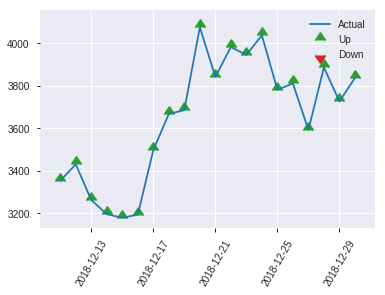


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2518805155239233
RMSE: 0.5018769924233659
LogLoss: 0.696945060144244
Null degrees of freedom: 250
Residual degrees of freedom: 201
Null deviance: 352.1428302126968
Residual deviance: 349.86642019241043
AIC: 449.86642019241043
AUC: 0.5075613165586479
pr_auc: 0.49577925225779124
Gini: 0.01512263311729578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4895142007456588: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    124  0.9612   (124.0/129.0)
1      0    122  0        (0.0/122.0)
Total  5    246  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489514     0.663043  245
max f2                       0.489514     0.831063  245
max f0point5                 0.493313     0.552486  240
max accuracy                 0.56371      0.52988   33
max precision                0.6904       1         0
max recall                   0.489514     1         245
max specificity              0.6904       1         0
max absolute_mcc             0.489514     0.138644  245
max min_per_class_accuracy   0.521988     0.503876  125
max mean_per_class_accuracy  0.535095     0.526623  95

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 53.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.668895           0.685792  0.685792           0.333333         0.680334  0.333333                    0.680334            0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.652838           2.05738   1.37158            1                0.662434  0.666667                    0.671384            0.0245902       0.0327869                  105.738   37.1585
    3        0.0318725                   0.637266           1.02869   1.28586            0.5              0.64147   0.625                       0.663905            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.601772           1.37158   1.30924            0.666667         0.616241  0.636364                    0.650906            0.0163934       0.057377                   37.1585   30.924
    5        0.0517928                   0.594811           0         1.10782            0                0.596439  0.538462                    0.642527            0               0.057377                   -100      10.7818
    6        0.103586                    0.571129           0.949559  1.02869            0.461538         0.583631  0.5                         0.613079            0.0491803       0.106557                   -5.04414  2.86885
    7        0.151394                    0.560472           1.20014   1.08283            0.583333         0.565742  0.526316                    0.59813             0.057377        0.163934                   20.0137   8.283
    8        0.203187                    0.550884           1.10782   1.0892             0.538462         0.555043  0.529412                    0.587147            0.057377        0.221311                   10.7818   8.91996
    9        0.302789                    0.541936           0.905246  1.02869            0.44             0.546247  0.5                         0.573693            0.0901639       0.311475                   -9.47541  2.86885
    10       0.40239                     0.532464           1.06984   1.03887            0.52             0.537354  0.50495                     0.564698            0.106557        0.418033                   6.98361   3.88736
    11       0.501992                    0.521988           0.905246  1.01236            0.44             0.52693   0.492063                    0.557205            0.0901639       0.508197                   -9.47541  1.23601
    12       0.601594                    0.51065            0.658361  0.953751           0.32             0.515934  0.463576                    0.550372            0.0655738       0.57377                    -34.1639  -4.62491
    13       0.701195                    0.504556           1.31672   1.00531            0.64             0.507458  0.488636                    0.544276            0.131148        0.704918                   31.6721   0.530924
    14       0.800797                    0.499536           0.987541  1.0031             0.48             0.501857  0.487562                    0.539               0.0983607       0.803279                   -1.2459   0.309926
    15       0.900398                    0.495188           0.987541  1.00138            0.48             0.497034  0.486726                    0.534358            0.0983607       0.901639                   -1.2459   0.137821
    16       1                           0.484904           0.987541  1                  0.48             0.492308  0.486056                    0.53017        

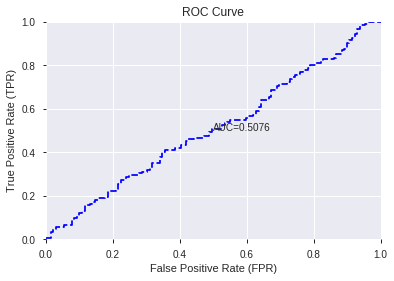

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


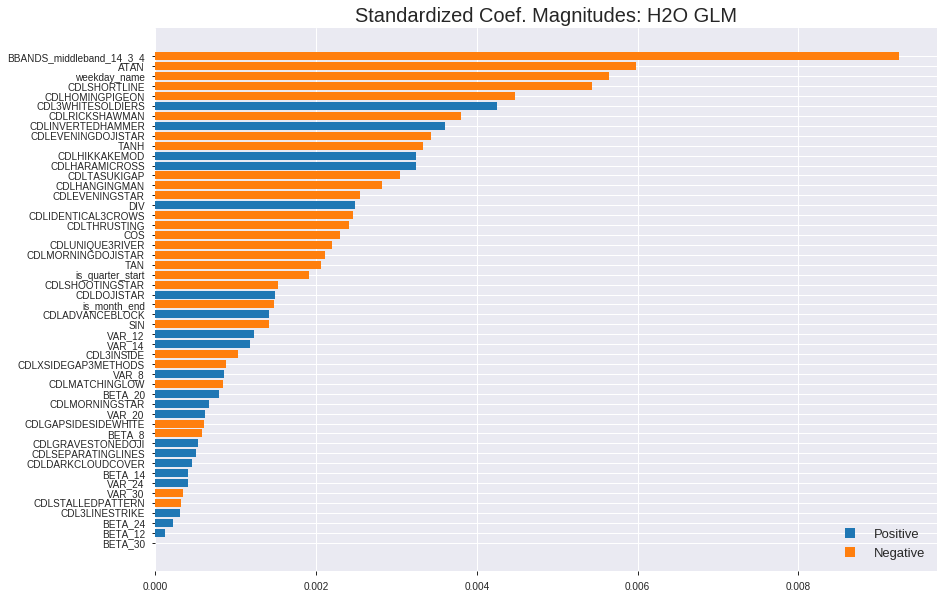

'log_likelihood'
--2019-07-25 04:03:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.96
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.96|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_040321_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_040321_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BBANDS_middleband_14_3_4',
 'ATAN',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGDOJISTAR',
 'TANH',
 'CDLHIKKAKEMOD',
 'CDLHARAMICROSS',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'DIV',
 'CDLIDENTICAL3CROWS',
 'CDLTHRUSTING',
 'COS',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'TAN',
 'is_quarter_start',
 'CDLSHOOTINGSTAR',
 'CDLDOJISTAR',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'SIN',
 'VAR_12',
 'VAR_14',
 'CDL3INSIDE',
 'CDLXSIDEGAP3METHODS',
 'VAR_8',
 'CDLMATCHINGLOW',
 'BETA_20',
 'CDLMORNINGSTAR',
 'VAR_20',
 'CDLGAPSIDESIDEWHITE',
 'BETA_8',
 'CDLGRAVESTONEDOJI',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER',
 'BETA_14',
 'VAR_24',
 'VAR_30',
 'CDLSTALLEDPATTERN',
 'CDL3LINESTRIKE',
 'BETA_24',
 'BETA_12',
 'BETA_30']

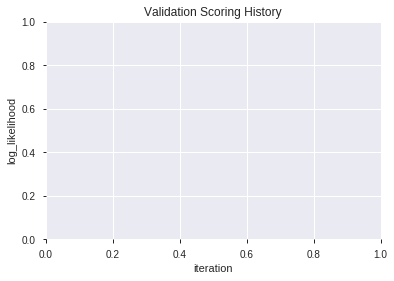

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_040336_model_7  0.535519  0.702671              0.500000  0.504561  0.254582
1  XGBoost_grid_1_AutoML_20190725_040336_model_1  0.534439  0.714734              0.500000  0.510345  0.260452
2  XGBoost_grid_1_AutoML_20190725_040336_model_2  0.517887  0.699715              0.496124  0.503226  0.253237
3  XGBoost_grid_1_AutoML_20190725_040336_model_6  0.517124  0.714841              0.492470  0.510376  0.260484
4               XGBoost_1_AutoML_20190725_040336  0.514678  0.711074              0.500000  0.508644  0.258719
5  XGBoost_grid_1_AutoML_20190725_040336_model_3  0.503685  0.723596              0.500000  0.514445  0.264653
6  XGBoost_grid_1_AutoML_20190725_040336_model_4  0.501652  0.701381              0.492248  0.504042  0.254058
7               XGBoost_3_AutoML_20190725_040336  0.496696  0.706488              0.500000  0.506528  0.256571
8               XGBoost_2_AutoML_20190725_040336  0.482717  0.714013              0.500000  0.510053  0.260154
9  XGBoost_grid_1_AutoML_20190725_040336_model_5  0.480811  0.746567              0.484496  0.523948  0.274521

variable  relative_importance  scaled_importance  percentage
0                        DIV           560.197693           1.000000    0.080835
1                     BETA_8           502.148743           0.896378    0.072459
2                        COS           497.689453           0.888418    0.071815
3                    BETA_12           408.348022           0.728936    0.058924
4                        TAN           404.767456           0.722544    0.058407
5                        SIN           393.585602           0.702583    0.056793
6                      VAR_8           392.125244           0.699977    0.056583
7                    BETA_20           387.467834           0.691663    0.055911
8                       ATAN           382.050690           0.681993    0.055129
9   BBANDS_middleband_14_3_4           354.056335           0.632020    0.051089
10                   BETA_24           343.122437           0.612502    0.049512
11                   BETA_30           332.201630           0.593008    0.047936
12                   BETA_14           320.961578           0.572943    0.046314
13                    VAR_24           296.200409           0.528743    0.042741
14                    VAR_30           277.918640           0.496108    0.040103
15                    VAR_12           270.227539           0.482379    0.038993
16              weekday_name           266.769165           0.476205    0.038494
17                    VAR_14           194.200897           0.346665    0.028023
18                    VAR_20           173.109726           0.309015    0.024979
19              CDLSHORTLINE           121.961342           0.217711    0.017599
20                      TANH            35.319443           0.063048    0.005097
21            CDLRICKSHAWMAN            10.702056           0.019104    0.001544
22              is_month_end             5.001296           0.008928    0.000722

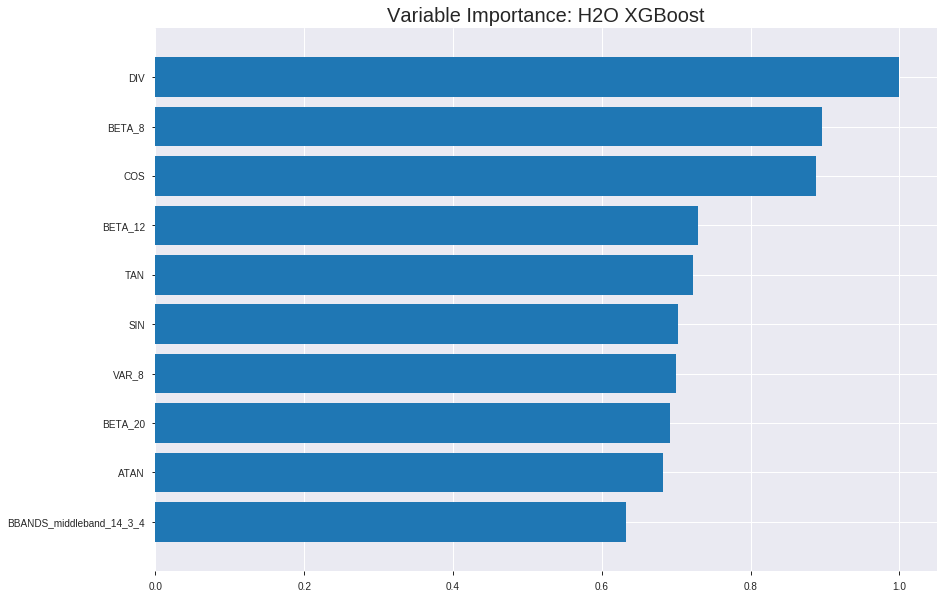

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_040336_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16345003731206026
RMSE: 0.4042895463798937
LogLoss: 0.5112978077420046
Mean Per-Class Error: 0.1351082539076136
AUC: 0.9346952621213419
pr_auc: 0.9449170239701594
Gini: 0.8693905242426838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.525476050376892: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      650  135   0.172    (135.0/785.0)
1      95   872   0.0982   (95.0/967.0)
Total  745  1007  0.1313   (230.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525476     0.883485  215
max f2                       0.495391     0.91847   237
max f0point5                 0.561551     0.888687  189
max accuracy                 0.525476     0.868721  215
max precision                0.85196      1         0
max recall                   0.343119     1         344
max specificity              0.85196      1         0
max absolute_mcc             0.525476     0.73409   215
max min_per_class_accuracy   0.540125     0.859359  204
max mean_per_class_accuracy  0.525476     0.864892  215

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 54.90 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.818119           1.81179    1.81179            1                0.836093  1                           0.836093            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.798696           1.81179    1.81179            1                0.808624  1                           0.822358            0.0186143       0.0372285                  81.1789   81.1789
    3        0.0302511                   0.784745           1.81179    1.81179            1                0.79138   1                           0.812422            0.0175801       0.0548087                  81.1789   81.1789
    4        0.0405251                   0.77347            1.81179    1.81179            1                0.778367  1                           0.803788            0.0186143       0.073423                   81.1789   81.1789
    5        0.0502283                   0.766783           1.81179    1.81179            1                0.770582  1                           0.797373            0.0175801       0.0910031                  81.1789   81.1789
    6        0.100457                    0.733435           1.81179    1.81179            1                0.748522  1                           0.772948            0.0910031       0.182006                   81.1789   81.1789
    7        0.150114                    0.707788           1.74931    1.79112            0.965517         0.719875  0.988593                    0.755391            0.0868666       0.268873                   74.9314   79.1122
    8        0.200342                    0.682212           1.7912     1.79114            0.988636         0.695563  0.988604                    0.740392            0.089969        0.358842                   79.1201   79.1142
    9        0.300228                    0.638269           1.69791    1.76012            0.937143         0.661208  0.971483                    0.714048            0.169597        0.528438                   69.7905   76.0122
    10       0.400114                    0.597924           1.55296    1.70841            0.857143         0.617832  0.942939                    0.690028            0.155119        0.683557                   55.2962   70.8406
    11       0.5                         0.555681           1.35625    1.63806            0.748571         0.57908   0.90411                     0.667864            0.135471        0.819028                   35.6254   63.8056
    12       0.599886                    0.513726           1.00425    1.53252            0.554286         0.534412  0.845861                    0.645643            0.10031         0.919338                   0.424878  53.2522
    13       0.699772                    0.46506            0.445182   1.37731            0.245714         0.490463  0.760196                    0.623492            0.0444674       0.963806                   -55.4818  37.7314
    14       0.799658                    0.408892           0.196709   1.22984            0.108571         0.437079  0.678801                    0.600207            0.0196484       0.983454                   -80.3291  22.9844
    15       0.899543                    0.356143           0.13459    1.10823            0.0742857        0.381132  0.611675                    0.575881            0.0134436       0.996898                   -86.541   10.8226
    16       1                           0.195295           0.0308828  1                  0.0170455        0.308091  0.551941                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2575974205704738
RMSE: 0.5075405605175549
LogLoss: 0.7087280226144526
Mean Per-Class Error: 0.4825406184486374
AUC: 0.44549266247379454
pr_auc: 0.5533489796819734
Gini: -0.10901467505241091
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3301801383495331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    211  0.9953   (211.0/212.0)
1      0    288  0        (0.0/288.0)
Total  1    499  0.422    (211.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33018      0.731893  398
max f2                       0.33018      0.872199  398
max f0point5                 0.33018      0.630473  398
max accuracy                 0.33018      0.578     398
max precision                0.709756     1         0
max recall                   0.33018      1         398
max specificity              0.709756     1         0
max absolute_mcc             0.546031     0.129815  200
max min_per_class_accuracy   0.55044      0.447917  191
max mean_per_class_accuracy  0.645258     0.517459  33

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.68866            0.694444  0.694444           0.4              0.703772  0.4                         0.703772            0.00694444      0.00694444                 -30.5556  -30.5556
    2        0.02                        0.674885           1.38889   1.04167            0.8              0.685327  0.6                         0.69455             0.0138889       0.0208333                  38.8889   4.16667
    3        0.03                        0.668483           1.73611   1.27315            1                0.672122  0.733333                    0.687074            0.0173611       0.0381944                  73.6111   27.3148
    4        0.04                        0.660392           1.38889   1.30208            0.8              0.664826  0.75                        0.681512            0.0138889       0.0520833                  38.8889   30.2083
    5        0.05                        0.654279           1.04167   1.25               0.6              0.65843   0.72                        0.676895            0.0104167       0.0625                     4.16667   25
    6        0.1                         0.635185           0.833333  1.04167            0.48             0.643698  0.6                         0.660297            0.0416667       0.104167                   -16.6667  4.16667
    7        0.15                        0.620211           0.694444  0.925926           0.4              0.627166  0.533333                    0.649253            0.0347222       0.138889                   -30.5556  -7.40741
    8        0.2                         0.608351           0.763889  0.885417           0.44             0.61372   0.51                        0.64037             0.0381944       0.177083                   -23.6111  -11.4583
    9        0.3                         0.588996           1.07639   0.949074           0.62             0.600582  0.546667                    0.627107            0.107639        0.284722                   7.63889   -5.09259
    10       0.4                         0.568316           0.798611  0.911458           0.46             0.576439  0.525                       0.61444             0.0798611       0.364583                   -20.1389  -8.85417
    11       0.5                         0.548019           0.902778  0.909722           0.52             0.55704   0.524                       0.60296             0.0902778       0.454861                   -9.72222  -9.02778
    12       0.6                         0.528149           1.00694   0.925926           0.58             0.538799  0.533333                    0.592267            0.100694        0.555556                   0.694444  -7.40741
    13       0.7                         0.507798           1.14583   0.957341           0.66             0.518783  0.551429                    0.581769            0.114583        0.670139                   14.5833   -4.26587
    14       0.8                         0.474598           1.00694   0.963542           0.58             0.491298  0.555                       0.57046             0.100694        0.770833                   0.694444  -3.64583
    15       0.9                         0.438627           1.21528   0.991512           0.7              0.456851  0.571111                    0.557837            0.121528        0.892361                   21.5278   -0.848765
    16       1                           0.297225           1.07639   1                  0.62             0.394224  0.576                       0.541476   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:03:45  5.637 sec   0                  0.5              0.693147            0.5             0                  1                0.448059                         0.5                0.693147              0.5               0                    1                  0.424
    2019-07-25 04:03:45  5.719 sec   5                  0.484465         0.662454            0.788174        0.813199           1.81179          0.287671                         0.501097           0.695346              0.4612            0.546876             0.694444           0.422
    2019-07-25 04:03:45  5.770 sec   10                 0.472666         0.639535            0.82931         0.854371           1.81179          0.252283                         0.500824           0.694815              0.446328          0.534425             0.694444           0.42
    2019-07-25 04:03:45  5.832 sec   15                 0.461404         0.617893            0.858645        0.880544           1.81179          0.233447                         0.50209            0.6974                0.447384          0.532611             0.694444           0.424
    2019-07-25 04:03:45  5.893 sec   20                 0.451867         0.599701            0.872716        0.89277            1.81179          0.215183                         0.503987           0.701256              0.43411           0.525601             0.694444           0.424
    2019-07-25 04:03:46  5.955 sec   25                 0.441581         0.580359            0.894183        0.91022            1.81179          0.190068                         0.505078           0.70354               0.427509          0.527554             0.694444           0.424
    2019-07-25 04:03:46  6.018 sec   30                 0.432129         0.562617            0.904945        0.920414           1.81179          0.166096                         0.506136           0.70582               0.434388          0.534381             0.347222           0.422
    2019-07-25 04:03:46  6.089 sec   35                 0.424005         0.54755             0.916472        0.929875           1.81179          0.152397                         0.50642            0.706354              0.44718           0.54964              0.694444           0.422
    2019-07-25 04:03:46  6.146 sec   40                 0.417552         0.535504            0.92169         0.934505           1.81179          0.148402                         0.506287           0.706116              0.452986          0.555687             0.694444           0.42
    2019-07-25 04:03:46  6.208 sec   45                 0.411033         0.523511            0.928106        0.939475           1.81179          0.138128                         0.5077             0.708997              0.444363          0.551913             1.38889            0.42
    2019-07-25 04:03:46  6.272 sec   50                 0.40429          0.511298            0.934695        0.944917           1.81179          0.131279                         0.507541           0.708728              0.445493          0.553349             0.694444           0.422

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
DIV             560.1976928710938      1.0                   0.08083505385280607
BETA_8          502.14874267578125     0.8963777414044616    0.07245874299888633
COS             497.689453125          0.8884175344854955    0.07181527924391223
BETA_12         408.3480224609375      0.7289355662428654    0.05892354575246771
TAN             404.7674560546875      0.7225439540462869    0.058406879436351034
---             ---                    ---                   ---
VAR_20          173.10972595214844     0.3090154210827542    0.024979278204571978
CDLSHORTLINE    121.96134185791016     0.21771125338421288   0.017598700891674757
TANH            35.31944274902344      0.06304817602515679   0.0050965027043147456
CDLRICKSHAWMAN  10.702055931091309     0.019104069986867908  0.0015442785261962435
is_month_end    5.001296043395996      0.008927734096446621  0.0007216738664697956


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6541554959785523)

('auc', 0.53551912568306)

('logloss', 0.7026706830695115)

('mean_per_class_error', 0.45399669589528524)

('rmse', 0.5045614023209936)

('mse', 0.2545822087121275)

xgboost prediction progress: |████████████████████████████████████████████| 100%


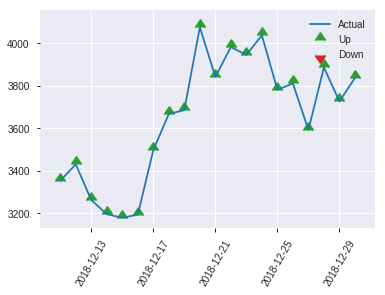


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2545822087121275
RMSE: 0.5045614023209936
LogLoss: 0.7026706830695115
Mean Per-Class Error: 0.45399669589528524
AUC: 0.53551912568306
pr_auc: 0.5165094419784976
Gini: 0.07103825136612008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33360815048217773: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    129  1        (129.0/129.0)
1      0    122  0        (0.0/122.0)
Total  0    251  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333608     0.654155   250
max f2                       0.333608     0.82544    250
max f0point5                 0.478103     0.546039   202
max accuracy                 0.580618     0.549801   88
max precision                0.724503     1          0
max recall                   0.333608     1          250
max specificity              0.724503     1          0
max absolute_mcc             0.580618     0.0956614  88
max min_per_class_accuracy   0.549823     0.511628   125
max mean_per_class_accuracy  0.579643     0.546003   90

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.693268           1.37158   1.37158            0.666667         0.713258  0.666667                    0.713258            0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.679028           1.37158   1.37158            0.666667         0.686584  0.666667                    0.699921            0.0163934       0.0327869                  37.1585   37.1585
    3        0.0318725                   0.673169           1.02869   1.28586            0.5              0.675582  0.625                       0.693836            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.658735           0.685792  1.12221            0.333333         0.663679  0.545455                    0.685612            0.00819672      0.0491803                  -31.4208  12.2206
    5        0.0517928                   0.651659           2.05738   1.26608            1                0.652456  0.615385                    0.680511            0.0163934       0.0655738                  105.738   26.6078
    6        0.103586                    0.628117           0.949559  1.10782            0.461538         0.638157  0.538462                    0.659334            0.0491803       0.114754                   -5.04414  10.7818
    7        0.151394                    0.610583           0.85724   1.02869            0.416667         0.621437  0.5                         0.647366            0.0409836       0.155738                   -14.276   2.86885
    8        0.203187                    0.602068           1.42434   1.12954            0.692308         0.606175  0.54902                     0.636867            0.0737705       0.229508                   42.4338   12.954
    9        0.302789                    0.589475           1.06984   1.1099             0.52             0.595951  0.539474                    0.623408            0.106557        0.336066                   6.98361   10.9901
    10       0.40239                     0.572017           1.06984   1.09998            0.52             0.581036  0.534653                    0.61292             0.106557        0.442623                   6.98361   9.99838
    11       0.501992                    0.549823           0.740656  1.02869            0.36             0.561121  0.5                         0.602642            0.0737705       0.516393                   -25.9344  2.86885
    12       0.601594                    0.532936           0.987541  1.02188            0.48             0.541434  0.496689                    0.592508            0.0983607       0.614754                   -1.2459   2.1876
    13       0.701195                    0.50852            1.15213   1.04038            0.56             0.519531  0.505682                    0.582142            0.114754        0.729508                   15.2131   4.03782
    14       0.800797                    0.480737           0.905246  1.02357            0.44             0.492924  0.497512                    0.571045            0.0901639       0.819672                   -9.47541  2.35707
    15       0.900398                    0.435467           0.822951  1.00138            0.4              0.458751  0.486726                    0.558623            0.0819672       0.901639                   -17.7049  0.137821
    16       1                           0.333608           0.987541  1                  0.48             0.396733  0.486056                    0.542499          

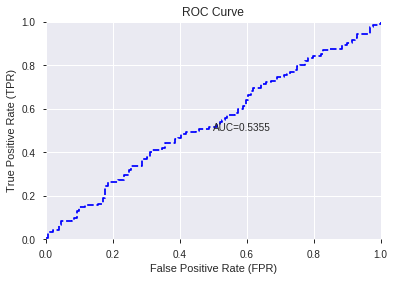

This function is available for GLM models only


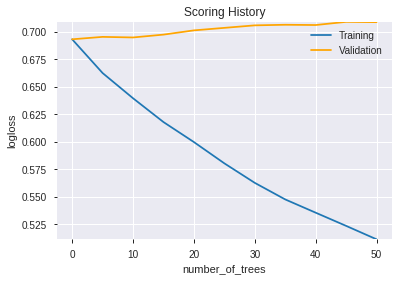

--2019-07-25 04:03:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_040336_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_040336_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'BETA_8',
 'COS',
 'BETA_12',
 'TAN',
 'SIN',
 'VAR_8',
 'BETA_20',
 'ATAN',
 'BBANDS_middleband_14_3_4',
 'BETA_24',
 'BETA_30',
 'BETA_14',
 'VAR_24',
 'VAR_30',
 'VAR_12',
 'weekday_name',
 'VAR_14',
 'VAR_20',
 'CDLSHORTLINE',
 'TANH',
 'CDLRICKSHAWMAN',
 'is_month_end']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_040401_model_1  0.520905  2.064473              0.480843  0.676916  0.458216

variable  relative_importance  scaled_importance    percentage
0                 CDLSHORTLINE         1.246589e-02           1.000000  1.147082e-02
1                 weekday_name         1.098656e-02           0.881330  1.010957e-02
2              CDLHOMINGPIGEON         9.572432e-03           0.767890  8.808327e-03
3               STOCHRSI_fastd         9.257647e-03           0.742638  8.518670e-03
4                       ULTOSC         7.959090e-03           0.638469  7.323768e-03
...                        ...                  ...                ...           ...
1029                    EMA_12         1.750156e-06           0.000140  1.610453e-06
1030                      fama         9.354722e-07           0.000075  8.607996e-07
1031  BBANDS_middleband_12_1_5         5.525897e-07           0.000044  5.084801e-07
1032  BBANDS_middleband_12_1_2         4.053014e-07           0.000033  3.729489e-07
1033   BBANDS_lowerband_24_6_3         2.222633e-07           0.000018  2.045215e-07

[1034 rows x 4 columns]

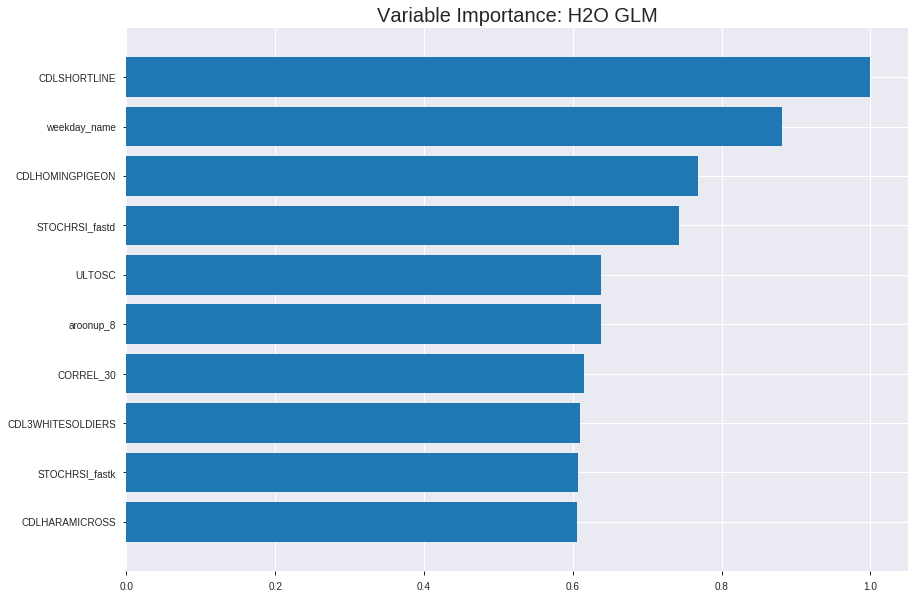

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_040401_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2406989778549314
RMSE: 0.49061082117594124
LogLoss: 0.6742384968103472
Null degrees of freedom: 1751
Residual degrees of freedom: 717
Null deviance: 2409.84717619812
Residual deviance: 2362.5316928234565
AIC: 4432.531692823457
AUC: 0.5992576686712467
pr_auc: 0.6442533113062169
Gini: 0.1985153373424935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.454981313075743: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      34   751   0.9567   (751.0/785.0)
1      18   949   0.0186   (18.0/967.0)
Total  52   1700  0.4389   (769.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454981     0.711661  369
max f2                       0.408826     0.86032   399
max f0point5                 0.504341     0.625495  289
max accuracy                 0.504341     0.586758  289
max precision                0.700201     1         0
max recall                   0.408826     1         399
max specificity              0.700201     1         0
max absolute_mcc             0.580354     0.154046  149
max min_per_class_accuracy   0.547585     0.566701  202
max mean_per_class_accuracy  0.580354     0.574454  149

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.663589           1.61048   1.61048            0.888889         0.669891  0.888889                    0.669891            0.016546        0.016546                   61.0479   61.0479
    2        0.0205479                   0.657429           1.1072    1.35884            0.611111         0.659645  0.75                        0.664768            0.0113754       0.0279214                  10.7204   35.8842
    3        0.0302511                   0.653592           1.49206   1.40157            0.823529         0.655317  0.773585                    0.661737            0.0144778       0.0423992                  49.2062   40.1573
    4        0.0405251                   0.649813           1.20786   1.35246            0.666667         0.6512    0.746479                    0.659065            0.0124095       0.0548087                  20.7859   35.2462
    5        0.0502283                   0.64685            1.27891   1.33825            0.705882         0.648387  0.738636                    0.657003            0.0124095       0.0672182                  27.891    33.8253
    6        0.100457                    0.629918           1.29708   1.31766            0.715909         0.637254  0.727273                    0.647128            0.0651499       0.132368                   29.7076   31.7665
    7        0.150114                    0.617845           1.24951   1.29512            0.689655         0.623304  0.714829                    0.639247            0.0620476       0.194416                   24.951    29.5119
    8        0.200342                    0.607632           1.0706    1.23883            0.590909         0.612873  0.683761                    0.632635            0.0537746       0.24819                    7.06026   23.883
    9        0.300228                    0.590692           1.09743   1.19179            0.605714         0.598927  0.657795                    0.62142             0.109617        0.357808                   9.74265   19.1785
    10       0.400114                    0.568599           0.983543  1.1398             0.542857         0.581444  0.629101                    0.61144             0.098242        0.45605                    -1.64574  13.9799
    11       0.5                         0.548668           1.06637   1.12513            0.588571         0.558077  0.621005                    0.60078             0.106515        0.562565                   6.63673   12.5129
    12       0.599886                    0.53011            0.900718  1.08776            0.497143         0.538746  0.600381                    0.590451            0.089969        0.652534                   -9.9282   8.7763
    13       0.699772                    0.514584           0.97319   1.07141            0.537143         0.523319  0.591354                    0.580868            0.0972079       0.749741                   -2.68105  7.14087
    14       0.799658                    0.497677           0.94213   1.05526            0.52             0.506084  0.582441                    0.571527            0.0941055       0.843847                   -5.78697  5.52604
    15       0.899543                    0.477406           0.859306  1.0335             0.474286         0.488759  0.570431                    0.562336            0.0858325       0.929679                   -14.0694  3.35015
    16       1                           0.408826           0.700009  1                  0.386364         0.458852  0.551941                    0.551941           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3833468639084401
RMSE: 0.6191501141956126
LogLoss: 1.403698316020976
Null degrees of freedom: 499
Residual degrees of freedom: -535
Null deviance: 682.7250417755
Residual deviance: 1403.6983160209759
AIC: 3473.6983160209757
AUC: 0.5604363207547169
pr_auc: 0.6014470722445086
Gini: 0.12087264150943389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.000686890963446903: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    210  0.9906   (210.0/212.0)
1      0    288  0        (0.0/288.0)
Total  2    498  0.42     (210.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000686891  0.732824  398
max f2                       0.000686891  0.872727  398
max f0point5                 0.00406715   0.636574  384
max accuracy                 0.00406715   0.588     384
max precision                0.419716     0.669173  111
max recall                   0.000686891  1         398
max specificity              0.999997     0.990566  0
max absolute_mcc             0.237373     0.130227  202
max min_per_class_accuracy   0.206825     0.561321  219
max mean_per_class_accuracy  0.237373     0.565776  202

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 25.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.999843           1.04167   1.04167            0.6              0.999997    0.6                         0.999997            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.997987           0.694444  0.868056           0.4              0.99929     0.5                         0.999644            0.00694444      0.0173611                  -30.5556  -13.1944
    3        0.03                        0.982386           0.694444  0.810185           0.4              0.989925    0.466667                    0.996404            0.00694444      0.0243056                  -30.5556  -18.9815
    4        0.04                        0.671207           0.694444  0.78125            0.4              0.896907    0.45                        0.97153             0.00694444      0.03125                    -30.5556  -21.875
    5        0.05                        0.547078           1.04167   0.833333           0.6              0.625193    0.48                        0.902263            0.0104167       0.0416667                  4.16667   -16.6667
    6        0.1                         0.489372           1.25      1.04167            0.72             0.517484    0.6                         0.709873            0.0625          0.104167                   25        4.16667
    7        0.15                        0.457325           1.04167   1.04167            0.6              0.468559    0.6                         0.629435            0.0520833       0.15625                    4.16667   4.16667
    8        0.2                         0.43812            1.38889   1.12847            0.8              0.446821    0.65                        0.583782            0.0694444       0.225694                   38.8889   12.8472
    9        0.3                         0.403045           1.14583   1.13426            0.66             0.423234    0.653333                    0.530266            0.114583        0.340278                   14.5833   13.4259
    10       0.4                         0.324501           1.04167   1.11111            0.6              0.380409    0.64                        0.492802            0.104167        0.444444                   4.16667   11.1111
    11       0.5                         0.212314           1.04167   1.09722            0.6              0.269205    0.632                       0.448082            0.104167        0.548611                   4.16667   9.72222
    12       0.6                         0.132543           0.833333  1.05324            0.48             0.18224     0.606667                    0.403775            0.0833333       0.631944                   -16.6667  5.32407
    13       0.7                         0.0745577          0.9375    1.03671            0.54             0.0945593   0.597143                    0.359602            0.09375         0.725694                   -6.25     3.67063
    14       0.8                         0.0304116          0.972222  1.02865            0.56             0.0510722   0.5925                      0.321035            0.0972222       0.822917                   -2.77778  2.86458
    15       0.9                         0.00841347         0.868056  1.0108             0.5              0.0177754   0.582222                    0.28734             0.0868056       0.909722                   -13.1944  1.08025
    16       1                           0.000429021        0.902778  1                  0.52             0.00322455  0.576 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:04:04  0.000 sec   2            5         1034          1.35632           2.87659
    2019-07-25 04:04:06  1.930 sec   4            3.7       1034          1.35417           2.84032
    2019-07-25 04:04:08  3.856 sec   6            2.7       1035          1.35157           2.81555
    2019-07-25 04:04:10  5.789 sec   8            1.9       1035          1.34848           2.8074
    2019-07-25 04:04:11  7.730 sec   10           1.4       1035          1.34481           2.84417
    2019-07-25 04:04:13  9.651 sec   12           1         1035          1.34056           2.93975
    2019-07-25 04:04:15  11.654 sec  14           0.75      1035          1.33575           3.10984
    2019-07-25 04:04:17  13.574 sec  16           0.55      1035          1.33045           3.35367
    2019-07-25 04:04:19  15.575 sec  18           0.4       1035          1.32471           6.35176

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6612021857923498)

('auc', 0.5209048163680264)

('logloss', 2.0644731892398167)

('mean_per_class_error', 0.45936586605667806)

('rmse', 0.6769162953663297)

('mse', 0.4582156709324761)

glm prediction progress: |████████████████████████████████████████████████| 100%


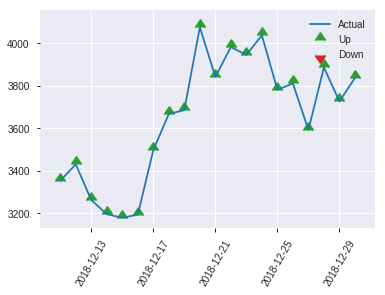


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4582156709324761
RMSE: 0.6769162953663297
LogLoss: 2.0644731892398167
Null degrees of freedom: 250
Residual degrees of freedom: -784
Null deviance: 352.1428302126968
Residual deviance: 1036.365540998388
AIC: 3106.365540998388
AUC: 0.5209048163680264
pr_auc: 0.5033317287957364
Gini: 0.04180963273605287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.002042906426897803: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    123  0.9535   (123.0/129.0)
1      1    121  0.0082   (1.0/122.0)
Total  7    244  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00204291   0.661202  243
max f2                       0.00177231   0.828804  247
max f0point5                 0.00431533   0.559406  221
max accuracy                 0.094285     0.537849  15
max precision                0.384033     1         0
max recall                   0.00177231   1         247
max specificity              0.384033     1         0
max absolute_mcc             0.00357864   0.132294  228
max min_per_class_accuracy   0.0101725    0.503876  125
max mean_per_class_accuracy  0.00431533   0.540634  221

Gains/Lift Table: Avg response rate: 48.61 %, avg score:  2.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.304649           1.37158   1.37158            0.666667         0.349908    0.666667                    0.349908            0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.274994           1.37158   1.37158            0.666667         0.280351    0.666667                    0.31513             0.0163934       0.0327869                  37.1585   37.1585
    3        0.0318725                   0.178632           1.02869   1.28586            0.5              0.186498    0.625                       0.282972            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.116724           1.37158   1.30924            0.666667         0.143671    0.636364                    0.244981            0.0163934       0.057377                   37.1585   30.924
    5        0.0517928                   0.0975935          2.05738   1.42434            1                0.100138    0.692308                    0.222697            0.0163934       0.0737705                  105.738   42.4338
    6        0.103586                    0.080365           0.791299  1.10782            0.384615         0.0882066   0.538462                    0.155452            0.0409836       0.114754                   -20.8701  10.7818
    7        0.151394                    0.0612573          0.685792  0.974547           0.333333         0.072453    0.473684                    0.129242            0.0327869       0.147541                   -31.4208  -2.5453
    8        0.203187                    0.0295735          1.26608   1.04886            0.615385         0.0404728   0.509804                    0.106614            0.0655738       0.213115                   26.6078   4.88589
    9        0.302789                    0.0167558          0.905246  1.00162            0.44             0.0216729   0.486842                    0.0786731           0.0901639       0.303279                   -9.47541  0.161777
    10       0.40239                     0.0119052          0.987541  0.998133           0.48             0.0135453   0.485149                    0.0625523           0.0983607       0.401639                   -1.2459   -0.186658
    11       0.501992                    0.0101725          1.06984   1.01236            0.52             0.0108626   0.492063                    0.0522964           0.106557        0.508197                   6.98361   1.23601
    12       0.601594                    0.0095618          1.06984   1.02188            0.52             0.00985816  0.496689                    0.0452702           0.106557        0.614754                   6.98361   2.1876
    13       0.701195                    0.00877611         1.15213   1.04038            0.56             0.00914536  0.505682                    0.0401388           0.114754        0.729508                   15.2131   4.03782
    14       0.800797                    0.0078221          0.822951  1.01333            0.4              0.00836749  0.492537                    0.0361872           0.0819672       0.811475                   -17.7049  1.3335
    15       0.900398                    0.00392345         1.15213   1.02869            0.56             0.00616961  0.5                         0.0328667           0.114754        0.92623                    15.2131   2.86885
    16       1                           0.00142498         0.740656  1                  0.36             0.00259784  0.486056 

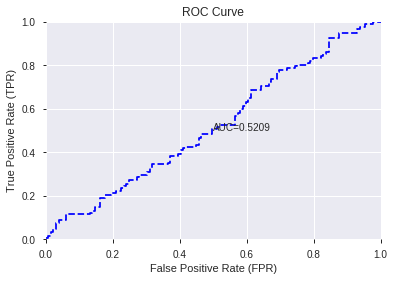

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


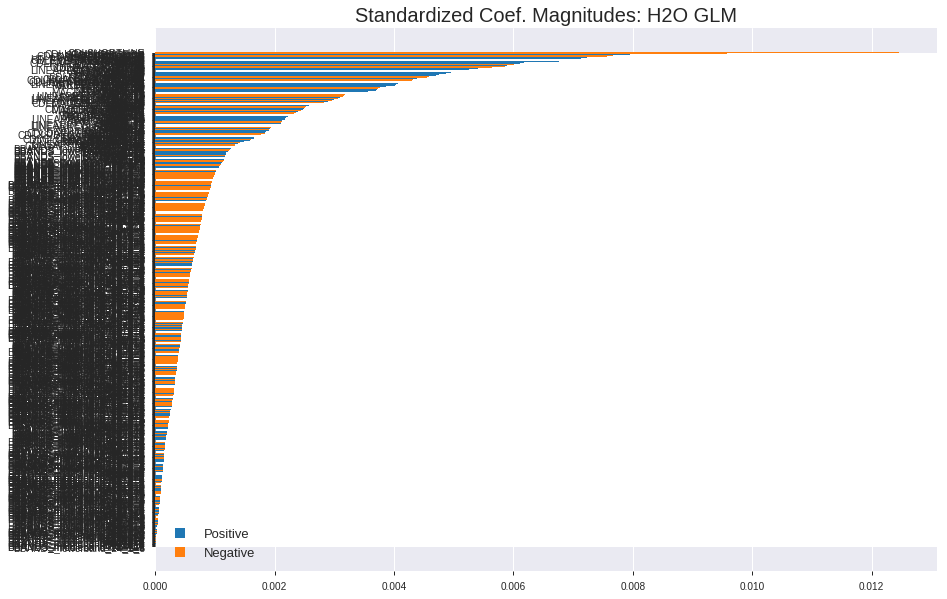

'log_likelihood'
--2019-07-25 04:04:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_040401_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_040401_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

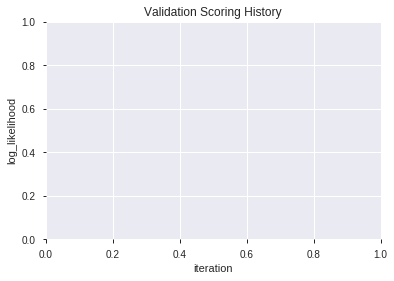

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190725_040449  0.537108  0.711944              0.496124  0.508712  0.258788
1  XGBoost_grid_1_AutoML_20190725_040449_model_5  0.535011  0.760535              0.496124  0.528143  0.278935
2  XGBoost_grid_1_AutoML_20190725_040449_model_1  0.522112  0.731617              0.469215  0.517530  0.267837
3  XGBoost_grid_1_AutoML_20190725_040449_model_7  0.517219  0.705764              0.477189  0.505982  0.256018
4  XGBoost_grid_1_AutoML_20190725_040449_model_6  0.502859  0.741462              0.481287  0.521279  0.271732
5               XGBoost_2_AutoML_20190725_040449  0.500191  0.705218              0.484719  0.505860  0.255895
6  XGBoost_grid_1_AutoML_20190725_040449_model_3  0.495616  0.712625              0.500000  0.508959  0.259040
7  XGBoost_grid_1_AutoML_20190725_040449_model_2  0.491549  0.699888              0.496124  0.503335  0.253346
8               XGBoost_1_AutoML_20190725_040449  0.479985  0.712594              0.477411  0.509412  0.259501
9  XGBoost_grid_1_AutoML_20190725_040449_model_4  0.473186  0.702359              0.484719  0.504541  0.254561

variable  relative_importance  scaled_importance  percentage
0               weekday_name           144.745621           1.000000    0.024948
1                        TAN           140.775131           0.972569    0.024263
2                        COS           132.265152           0.913777    0.022797
3                      DX_30           127.605385           0.881584    0.021994
4                     ATR_30           113.040161           0.780957    0.019483
..                       ...                  ...                ...         ...
269  BBANDS_upperband_12_3_4             0.595740           0.004116    0.000103
270       LINEARREG_ANGLE_24             0.538818           0.003723    0.000093
271  BBANDS_upperband_20_5_3             0.434976           0.003005    0.000075
272  BBANDS_lowerband_30_1_4             0.374421           0.002587    0.000065
273  BBANDS_upperband_20_0_2             0.206149           0.001424    0.000036

[274 rows x 4 columns]

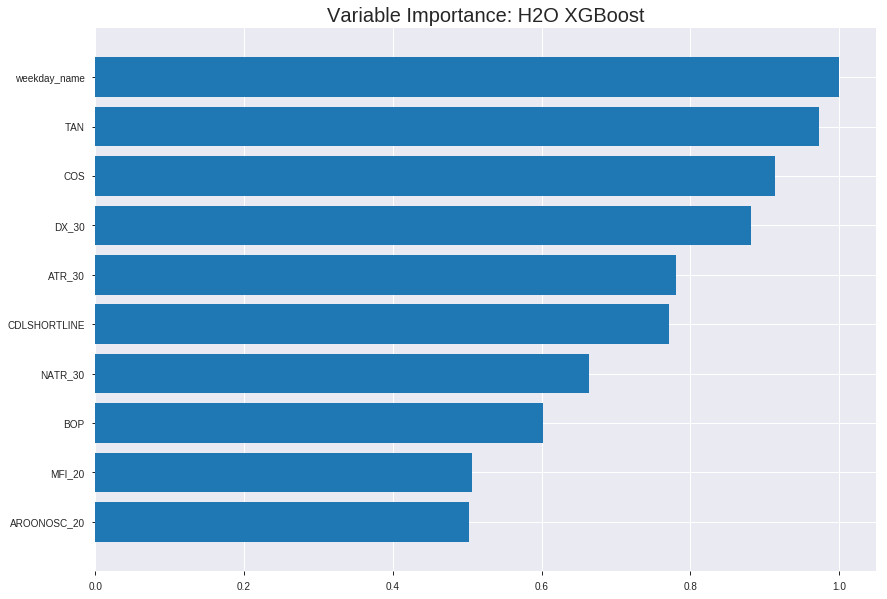

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190725_040449


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1716025660304309
RMSE: 0.41424940076049704
LogLoss: 0.5295729757021502
Mean Per-Class Error: 0.14260270453632284
AUC: 0.932767308439655
pr_auc: 0.9429258039914225
Gini: 0.8655346168793101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5290938392281532: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      632  153   0.1949   (153.0/785.0)
1      106  861   0.1096   (106.0/967.0)
Total  738  1014  0.1478   (259.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529094     0.869258  209
max f2                       0.484898     0.912675  247
max f0point5                 0.573688     0.892216  170
max accuracy                 0.545077     0.856164  196
max precision                0.82134      1         0
max recall                   0.350835     1         343
max specificity              0.82134      1         0
max absolute_mcc             0.550549     0.711217  191
max min_per_class_accuracy   0.543617     0.85212   197
max mean_per_class_accuracy  0.550549     0.857397  191

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 54.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.791153           1.81179    1.81179            1                0.805892  1                           0.805892            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.774691           1.81179    1.81179            1                0.782503  1                           0.794197            0.0186143       0.0372285                  81.1789   81.1789
    3        0.0302511                   0.762199           1.81179    1.81179            1                0.76804   1                           0.785807            0.0175801       0.0548087                  81.1789   81.1789
    4        0.0405251                   0.750993           1.61048    1.76075            0.888889         0.755451  0.971831                    0.778111            0.016546        0.0713547                  61.0479   76.0753
    5        0.0502283                   0.741041           1.81179    1.77061            1                0.745993  0.977273                    0.771907            0.0175801       0.0889349                  81.1789   77.0612
    6        0.100457                    0.705556           1.81179    1.7912             1                0.722766  0.988636                    0.747336            0.0910031       0.179938                   81.1789   79.1201
    7        0.150114                    0.68114            1.79096    1.79112            0.988506         0.693177  0.988593                    0.729421            0.0889349       0.268873                   79.0964   79.1122
    8        0.200342                    0.663371           1.7912     1.79114            0.988636         0.672063  0.988604                    0.71504             0.089969        0.358842                   79.1201   79.1142
    9        0.300228                    0.625104           1.73932    1.7739             0.96             0.64411   0.979087                    0.691442            0.173733        0.532575                   73.9317   77.39
    10       0.400114                    0.593508           1.55296    1.71874            0.857143         0.609353  0.948645                    0.670949            0.155119        0.687694                   55.2962   71.8744
    11       0.5                         0.553862           1.28378    1.63185            0.708571         0.574991  0.900685                    0.651779            0.128232        0.815926                   28.3782   63.1851
    12       0.599886                    0.52049            0.890365   1.50839            0.491429         0.537779  0.83254                     0.632797            0.0889349       0.90486                    -10.9635  50.8388
    13       0.699772                    0.479833           0.53836    1.36993            0.297143         0.499203  0.756117                    0.613728            0.0537746       0.958635                   -46.164   36.9925
    14       0.799658                    0.43183            0.300239   1.23631            0.165714         0.456917  0.68237                     0.594141            0.0299897       0.988625                   -69.9761  23.631
    15       0.899543                    0.369597           0.0931777  1.10938            0.0514286        0.401724  0.61231                     0.572775            0.00930714      0.997932                   -90.6822  10.9376
    16       1                           0.191283           0.0205885  1                  0.0113636        0.314846  0.551941                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.280459520402796
RMSE: 0.5295842901774901
LogLoss: 0.7571257387041229
Mean Per-Class Error: 0.4824751048218029
AUC: 0.48977987421383645
pr_auc: 0.5772818217037134
Gini: -0.020440251572327095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2456808090209961: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.245681     0.730964  399
max f2                       0.245681     0.871671  399
max f0point5                 0.245681     0.629371  399
max accuracy                 0.245681     0.576     399
max precision                0.667056     1         0
max recall                   0.245681     1         399
max specificity              0.667056     1         0
max absolute_mcc             0.276664     0.122567  390
max min_per_class_accuracy   0.395471     0.485849  208
max mean_per_class_accuracy  0.455593     0.517525  83

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 39.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.585745           1.38889   1.38889            0.8              0.617418  0.8                         0.617418            0.0138889       0.0138889                  38.8889   38.8889
    2        0.02                        0.550881           0.694444  1.04167            0.4              0.565369  0.6                         0.591393            0.00694444      0.0208333                  -30.5556  4.16667
    3        0.03                        0.523237           1.38889   1.15741            0.8              0.536627  0.666667                    0.573138            0.0138889       0.0347222                  38.8889   15.7407
    4        0.04                        0.512702           1.38889   1.21528            0.8              0.516685  0.7                         0.559025            0.0138889       0.0486111                  38.8889   21.5278
    5        0.05                        0.506859           1.38889   1.25               0.8              0.510162  0.72                        0.549252            0.0138889       0.0625                     38.8889   25
    6        0.1                         0.481149           0.694444  0.972222           0.4              0.49233   0.56                        0.520791            0.0347222       0.0972222                  -30.5556  -2.77778
    7        0.15                        0.466411           1.11111   1.01852            0.64             0.472678  0.586667                    0.504753            0.0555556       0.152778                   11.1111   1.85185
    8        0.2                         0.451091           1.18056   1.05903            0.68             0.459474  0.61                        0.493434            0.0590278       0.211806                   18.0556   5.90278
    9        0.3                         0.430272           0.798611  0.972222           0.46             0.440617  0.56                        0.475828            0.0798611       0.291667                   -20.1389  -2.77778
    10       0.4                         0.408512           1.04167   0.989583           0.6              0.419187  0.57                        0.461668            0.104167        0.395833                   4.16667   -1.04167
    11       0.5                         0.395469           0.9375    0.979167           0.54             0.401196  0.564                       0.449573            0.09375         0.489583                   -6.25     -2.08333
    12       0.6                         0.382311           1.07639   0.99537            0.62             0.388585  0.573333                    0.439409            0.107639        0.597222                   7.63889   -0.462963
    13       0.7                         0.366722           0.868056  0.977183           0.5              0.374578  0.562857                    0.430147            0.0868056       0.684028                   -13.1944  -2.28175
    14       0.8                         0.348562           1.21528   1.00694            0.7              0.359051  0.58                        0.42126             0.121528        0.805556                   21.5278   0.694444
    15       0.9                         0.315186           0.833333  0.987654           0.48             0.329346  0.568889                    0.411047            0.0833333       0.888889                   -16.6667  -1.23457
    16       1                           0.245681           1.11111   1                  0.64             0.29144   0.576                       0.399087     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:05:02  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.448059                         0.5                0.693147              0.5               0                    1                  0.424
    2019-07-25 04:05:02  0.681 sec   5                  0.485283         0.664072            0.790014        0.805478           1.71113          0.303082                         0.502963           0.699108              0.532871          0.611246             1.04167            0.42
    2019-07-25 04:05:03  0.883 sec   10                 0.473315         0.6408              0.837863        0.857661           1.71113          0.255137                         0.507046           0.707453              0.526918          0.623565             1.38889            0.424
    2019-07-25 04:05:03  1.079 sec   15                 0.462649         0.620272            0.863836        0.885723           1.81179          0.23516                          0.511445           0.71664               0.537818          0.623434             1.38889            0.424
    2019-07-25 04:05:03  1.263 sec   20                 0.453523         0.602861            0.878435        0.896466           1.81179          0.216895                         0.519307           0.733438              0.537842          0.608285             0.694444           0.424
    2019-07-25 04:05:03  1.458 sec   25                 0.4449           0.586567            0.894127        0.90939            1.81179          0.196347                         0.520163           0.735409              0.520276          0.596617             1.04167            0.424
    2019-07-25 04:05:03  1.641 sec   30                 0.437969         0.573365            0.900192        0.915799           1.81179          0.181507                         0.522599           0.740952              0.521513          0.598775             1.04167            0.424
    2019-07-25 04:05:03  1.833 sec   35                 0.43058          0.559569            0.909448        0.922498           1.81179          0.173516                         0.523863           0.743843              0.516329          0.600168             1.38889            0.424
    2019-07-25 04:05:04  2.021 sec   40                 0.424342         0.547976            0.920034        0.929615           1.81179          0.163813                         0.526827           0.75048               0.50258           0.585594             1.38889            0.424
    2019-07-25 04:05:04  2.214 sec   45                 0.419278         0.538745            0.92662         0.937309           1.81179          0.163813                         0.529233           0.756183              0.496511          0.583347             1.38889            0.424
    2019-07-25 04:05:04  2.405 sec   50                 0.414249         0.529573            0.932767        0.942926           1.81179          0.147831                         0.529584           0.757126              0.48978           0.577282             1.38889            0.424

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
weekday_name             144.74562072753906     1.0                    0.02494775317385636
TAN                      140.77513122558594     0.9725691908190649     0.02426341611705124
COS                      132.26515197753906     0.9137765364695037     0.022796671487902535
DX_30                    127.60538482666016     0.8815837341763678     0.021993533402318622
ATR_30                   113.0401611328125      0.7809573827839177     0.01948313202499404
---                      ---                    ---                    ---
BBANDS_upperband_12_3_4  0.5957403182983398     0.004115774386153814   0.00010267932350504552
LINEARREG_ANGLE_24       0.538818359375         0.0037225192490572207  9.286849141040867e-05
BBANDS_upperband_20_5_3  0.43497610092163086    0.003005107157890498   7.497067163604113e-05
BBANDS_lowerband_30_1_4  0.3744211196899414     0.002586752661724602   6.453366692652133e-05
BBANDS_upperband_20_0_2  0.20614910125732422    0.0014242164994087633  3.553100169338357e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6559139784946236)

('auc', 0.537107637565129)

('logloss', 0.7119436212974298)

('mean_per_class_error', 0.4459905960096582)

('rmse', 0.5087116232337663)

('mse', 0.25878751561313335)

xgboost prediction progress: |████████████████████████████████████████████| 100%


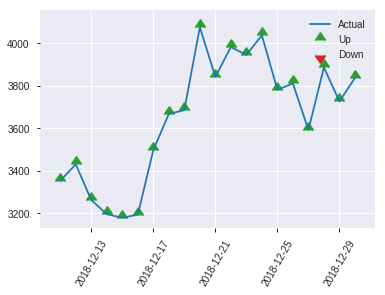


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25878751561313335
RMSE: 0.5087116232337663
LogLoss: 0.7119436212974298
Mean Per-Class Error: 0.4459905960096582
AUC: 0.537107637565129
pr_auc: 0.4976835983161296
Gini: 0.07421527513025805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.244327113032341: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    128  0.9922   (128.0/129.0)
1      0    122  0        (0.0/122.0)
Total  1    250  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244327     0.655914  249
max f2                       0.244327     0.826558  249
max f0point5                 0.344415     0.55618   191
max accuracy                 0.380141     0.549801  152
max precision                0.466566     0.566038  52
max recall                   0.244327     1         249
max specificity              0.614808     0.992248  0
max absolute_mcc             0.375        0.113146  162
max min_per_class_accuracy   0.398746     0.52459   124
max mean_per_class_accuracy  0.375        0.554009  162

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 40.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.599598           0.685792  0.685792           0.333333         0.608976  0.333333                    0.608976            0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.578321           0.685792  0.685792           0.333333         0.588626  0.333333                    0.598801            0.00819672      0.0163934                  -31.4208  -31.4208
    3        0.0318725                   0.567371           1.02869   0.771516           0.5              0.570267  0.375                       0.591667            0.00819672      0.0245902                  2.86885   -22.8484
    4        0.0438247                   0.563658           1.37158   0.935171           0.666667         0.564384  0.454545                    0.584226            0.0163934       0.0409836                  37.1585   -6.48286
    5        0.0517928                   0.554533           1.02869   0.949559           0.5              0.558732  0.461538                    0.580304            0.00819672      0.0491803                  2.86885   -5.04414
    6        0.103586                    0.522902           0.949559  0.949559           0.461538         0.539644  0.461538                    0.559974            0.0491803       0.0983607                  -5.04414  -5.04414
    7        0.151394                    0.488789           1.02869   0.974547           0.5              0.506786  0.473684                    0.543178            0.0491803       0.147541                   2.86885   -2.5453
    8        0.203187                    0.467517           1.5826    1.12954            0.769231         0.475807  0.54902                     0.526005            0.0819672       0.229508                   58.2598   12.954
    9        0.302789                    0.45061            0.822951  1.02869            0.4              0.458356  0.5                         0.503752            0.0819672       0.311475                   -17.7049  2.86885
    10       0.40239                     0.422444           1.15213   1.05924            0.56             0.43396   0.514851                    0.486477            0.114754        0.42623                    15.2131   5.92436
    11       0.501992                    0.398126           0.987541  1.04502            0.48             0.408497  0.507937                    0.471005            0.0983607       0.52459                    -1.2459   4.50169
    12       0.601594                    0.381773           1.23443   1.07638            0.6              0.389052  0.523179                    0.457436            0.122951        0.647541                   23.4426   7.63761
    13       0.701195                    0.362967           0.987541  1.06376            0.48             0.373344  0.517045                    0.445491            0.0983607       0.745902                   -1.2459   6.37575
    14       0.800797                    0.340616           0.905246  1.04404            0.44             0.34941   0.507463                    0.433541            0.0901639       0.836066                   -9.47541  4.40421
    15       0.900398                    0.317298           0.822951  1.01959            0.4              0.328453  0.495575                    0.421916            0.0819672       0.918033                   -17.7049  1.95851
    16       1                           0.210749           0.822951  1                  0.4              0.287721  0.486056                    0.40855     

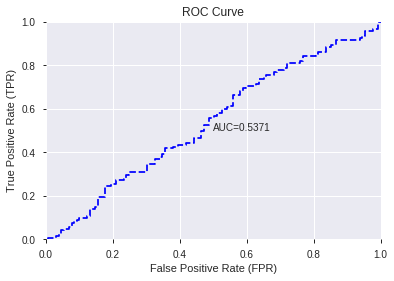

This function is available for GLM models only


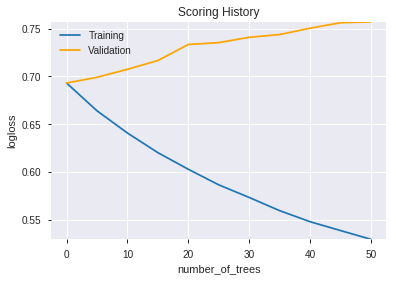

--2019-07-25 04:05:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190725_040449',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190725_040449',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b707',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_040545_model_6  0.531389   0.951105              0.481065  0.578196  0.334311
1  DeepLearning_grid_1_AutoML_20190725_040545_model_4  0.527958   3.026845              0.473980  0.657629  0.432476
2  DeepLearning_grid_1_AutoML_20190725_040545_model_5  0.509658   1.406885              0.492248  0.604923  0.365932
3  DeepLearning_grid_1_AutoML_20190725_040545_model_8  0.507244   0.691690              0.500000  0.499278  0.249279
4  DeepLearning_grid_1_AutoML_20190725_040545_model_7  0.500508   1.283128              0.496124  0.634351  0.402401
5               DeepLearning_1_AutoML_20190725_040545  0.499873   4.182714              0.500000  0.682156  0.465337
6  DeepLearning_grid_1_AutoML_20190725_040545_model_9  0.496728   0.694343              0.496124  0.500597  0.250598
7  DeepLearning_grid_1_AutoML_20190725_040545_model_1  0.487260  12.072180              0.500000  0.707163  0.500079
8  DeepLearning_grid_1_AutoML_20190725_040545_model_2  0.485163  12.093616              0.500000  0.726314  0.527532
9  DeepLearning_grid_1_AutoML_20190725_040545_model_3  0.466832  13.235427              0.500000  0.711881  0.506774

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_14_3_4             1.000000           1.000000    0.027971
1               weekday_name             0.883018           0.883018    0.024699
2                       ATAN             0.828988           0.828988    0.023188
3                        COS             0.774494           0.774494    0.021664
4                    BETA_20             0.771057           0.771057    0.021567
5               CDLSHORTLINE             0.762788           0.762788    0.021336
6                    BETA_30             0.748662           0.748662    0.020941
7                     VAR_12             0.748550           0.748550    0.020938
8                     VAR_20             0.744371           0.744371    0.020821
9                       TANH             0.733169           0.733169    0.020508
10                       SIN             0.731533           0.731533    0.020462
11                    VAR_30             0.729396           0.729396    0.020402
12                   BETA_12             0.728870           0.728870    0.020387
13        CDLEVENINGDOJISTAR             0.726765           0.726765    0.020328
14        CDLMORNINGDOJISTAR             0.725604           0.725604    0.020296
15                       TAN             0.721316           0.721316    0.020176
16           CDLHOMINGPIGEON             0.715216           0.715216    0.020005
17                   BETA_14             0.714918           0.714918    0.019997
18                    VAR_24             0.714016           0.714016    0.019972
19           CDLUNIQUE3RIVER             0.713160           0.713160    0.019948
20         CDLGRAVESTONEDOJI             0.712450           0.712450    0.019928
21                   BETA_24             0.711181           0.711181    0.019893
22         CDLDARKCLOUDCOVER             0.709834           0.709834    0.019855
23                    VAR_14             0.707708           0.707708    0.019795
24         CDLINVERTEDHAMMER             0.702891           0.702891    0.019661
25              CDLTHRUSTING             0.702638           0.702638    0.019654
26            CDLHARAMICROSS             0.701033           0.701033    0.019609
27         CDLSTALLEDPATTERN             0.699361           0.699361    0.019562
28                    BETA_8             0.696550           0.696550    0.019483
29                       DIV             0.696096           0.696096    0.019471
30                     VAR_8             0.695962           0.695962    0.019467
31          is_quarter_start             0.695059           0.695059    0.019442
32              is_month_end             0.691957           0.691957    0.019355
33           CDLSHOOTINGSTAR             0.691882           0.691882    0.019353
34            CDLMORNINGSTAR             0.691291           0.691291    0.019336
35            CDLEVENINGSTAR             0.686815           0.686815    0.019211
36       CDLGAPSIDESIDEWHITE             0.686147           0.686147    0.019192
37            CDLRICKSHAWMAN             0.685163           0.685163    0.019165
38        CDLIDENTICAL3CROWS             0.684068           0.684068    0.019134
39             CDLHIKKAKEMOD             0.673909           0.673909    0.018850
40            CDL3LINESTRIKE             0.672080           0.672080    0.018799
41                CDL3INSIDE             0.671525           0.671525    0.018783
42        CDLSEPARATINGLINES             0.667627           0.667627    0.018674
43              CDLTASUKIGAP             0.662536           0.662536    0.018532
44         CDL3WHITESOLDIERS             0.659763           0.659763    0.018454
45               CDLDOJISTAR             0.659656           0.659656    0.018451
46            CDLMATCHINGLOW             0.656453           0.656453    0.018362
47           CDLADVANCEBLOCK             0.655847           0.655847    0.018345
48       CDLXSIDEGAP3METHODS             0.654785  

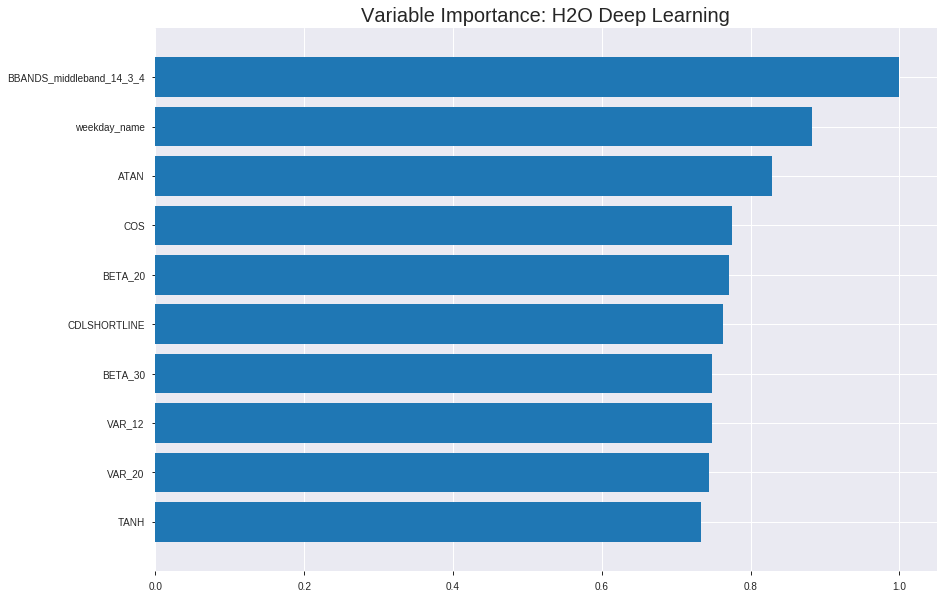

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_040545_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2536948237444562
RMSE: 0.5036812719810576
LogLoss: 0.7003167897162345
Mean Per-Class Error: 0.4210013239449608
AUC: 0.6102516812783644
pr_auc: 0.6614907607415528
Gini: 0.22050336255672875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2784299066887639: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   770   0.9809   (770.0/785.0)
1      4    963   0.0041   (4.0/967.0)
Total  19   1733  0.4418   (774.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.27843      0.713333  382
max f2                       0.234333     0.86124   393
max f0point5                 0.395718     0.634162  271
max accuracy                 0.395718     0.598744  271
max precision                0.828042     1         0
max recall                   0.234333     1         393
max specificity              0.828042     1         0
max absolute_mcc             0.460533     0.179123  145
max min_per_class_accuracy   0.420647     0.568153  221
max mean_per_class_accuracy  0.411371     0.578999  242

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 42.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.683199           1.81179   1.81179            1                0.746732  1                           0.746732            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.617155           1.50982   1.66081            0.833333         0.64465   0.916667                    0.695691            0.0155119       0.0341262                  50.9824   66.0807
    3        0.0302511                   0.586034           1.06576   1.46994            0.588235         0.604295  0.811321                    0.666375            0.0103413       0.0444674                  6.57583   46.9942
    4        0.0405251                   0.565729           1.50982   1.48005            0.833333         0.576458  0.816901                    0.64358             0.0155119       0.0599793                  50.9824   48.0053
    5        0.0502283                   0.541181           1.49206   1.48237            0.823529         0.551319  0.818182                    0.625756            0.0144778       0.0744571                  49.2062   48.2373
    6        0.100457                    0.498352           1.23531   1.35884            0.681818         0.517693  0.75                        0.571725            0.0620476       0.136505                   23.5311   35.8842
    7        0.150114                    0.474531           1.27033   1.32956            0.701149         0.485997  0.73384                     0.543366            0.0630817       0.199586                   27.0335   32.9564
    8        0.200342                    0.459326           1.21472   1.30077            0.670455         0.466696  0.717949                    0.524144            0.0610134       0.2606                     21.4722   30.0772
    9        0.300228                    0.440058           0.931777  1.17801            0.514286         0.448728  0.65019                     0.499053            0.0930714       0.353671                   -6.82228  17.8007
    10       0.400114                    0.428623           1.07672   1.15272            0.594286         0.43414   0.636234                    0.482848            0.107549        0.46122                    7.67203   15.2722
    11       0.5                         0.421128           1.0146    1.12513            0.56             0.424526  0.621005                    0.471197            0.101344        0.562565                   1.46019   12.5129
    12       0.599886                    0.412599           1.04566   1.1119             0.577143         0.416858  0.613701                    0.462149            0.104447        0.667011                   4.56611   11.1897
    13       0.699772                    0.399753           1.00425   1.09653            0.554286         0.406728  0.60522                     0.454238            0.10031         0.767322                   0.424878  9.65314
    14       0.799658                    0.383793           0.880012  1.06949            0.485714         0.392211  0.590293                    0.44649             0.0879007       0.855222                   -11.9988  6.94857
    15       0.899543                    0.361378           0.735069  1.03235            0.405714         0.373723  0.569797                    0.43841             0.073423        0.928645                   -26.4931  3.23519
    16       1                           0.166561           0.710304  1                  0.392045         0.325906  0.551941                    0.427108         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.32206471883021737
RMSE: 0.5675074614753689
LogLoss: 0.863888847849883
Mean Per-Class Error: 0.43822064989517817
AUC: 0.5285721305031447
pr_auc: 0.5803368564239022
Gini: 0.05714426100628933
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07162603517871934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    207  0.9764   (207.0/212.0)
1      2    286  0.0069   (2.0/288.0)
Total  7    493  0.418    (209.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.071626     0.732394  393
max f2                       0.0291327    0.871671  399
max f0point5                 0.238766     0.648148  298
max accuracy                 0.238766     0.602     298
max precision                0.7093       1         0
max recall                   0.0291327    1         399
max specificity              0.7093       1         0
max absolute_mcc             0.238766     0.145997  298
max min_per_class_accuracy   0.311765     0.533019  193
max mean_per_class_accuracy  0.238766     0.561779  298

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 30.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.528158           1.38889   1.38889            0.8              0.59516   0.8                         0.59516             0.0138889       0.0138889                  38.8889   38.8889
    2        0.02                        0.504852           1.04167   1.21528            0.6              0.517334  0.7                         0.556247            0.0104167       0.0243056                  4.16667   21.5278
    3        0.03                        0.463649           0.694444  1.04167            0.4              0.496025  0.6                         0.536173            0.00694444      0.03125                    -30.5556  4.16667
    4        0.04                        0.456735           0.347222  0.868056           0.2              0.460703  0.5                         0.517306            0.00347222      0.0347222                  -65.2778  -13.1944
    5        0.05                        0.433264           1.04167   0.902778           0.6              0.448683  0.52                        0.503581            0.0104167       0.0451389                  4.16667   -9.72222
    6        0.1                         0.397066           0.972222  0.9375             0.56             0.407889  0.54                        0.455735            0.0486111       0.09375                    -2.77778  -6.25
    7        0.15                        0.380071           0.833333  0.902778           0.48             0.389065  0.52                        0.433512            0.0416667       0.135417                   -16.6667  -9.72222
    8        0.2                         0.367767           1.18056   0.972222           0.68             0.374017  0.56                        0.418638            0.0590278       0.194444                   18.0556   -2.77778
    9        0.3                         0.347549           0.9375    0.960648           0.54             0.356987  0.553333                    0.398088            0.09375         0.288194                   -6.25     -3.93519
    10       0.4                         0.327436           1.07639   0.989583           0.62             0.337078  0.57                        0.382835            0.107639        0.395833                   7.63889   -1.04167
    11       0.5                         0.312488           1.31944   1.05556            0.76             0.319882  0.608                       0.370245            0.131944        0.527778                   31.9444   5.55556
    12       0.6                         0.292259           0.9375    1.03588            0.54             0.30353   0.596667                    0.359125            0.09375         0.621528                   -6.25     3.58796
    13       0.7                         0.26682            1.21528   1.06151            0.7              0.279571  0.611429                    0.347761            0.121528        0.743056                   21.5278   6.15079
    14       0.8                         0.232112           0.972222  1.05035            0.56             0.247606  0.605                       0.335241            0.0972222       0.840278                   -2.77778  5.03472
    15       0.9                         0.177984           0.763889  1.01852            0.44             0.210055  0.586667                    0.321332            0.0763889       0.916667                   -23.6111  1.85185
    16       1                           0.0291327          0.833333  1                  0.48             0.122096  0.576                       0.301408     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:11:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:11:22  3 min 13.690 sec  885 obs/sec       1.35274   1             2370       0.562354         0.875649            -0.278766      0.538219        0.589266           1.61048          0.446918                         0.647342           5.58062               -0.715851        0.437189          0.414319             0.838123           0.424
    2019-07-25 04:11:30  3 min 21.615 sec  1932 obs/sec      10.8744   8             19052      0.503681         0.700317            -0.0258496     0.610252        0.661491           1.81179          0.441781                         0.567507           0.863889              -0.318727        0.528572          0.580337             1.38889            0.418
    2019-07-25 04:11:37  3 min 29.130 sec  2290 obs/sec      21.7043   16            38026      0.489093         0.669265            0.0327142      0.614411        0.670332           1.71113          0.401826                         0.570081           1.65213               -0.330713        0.483794          0.521669             0.868056           0.414
    2019-07-25 04:11:45  3 min 37.366 sec  2463 obs/sec      33.8796   25            59357      0.48245          0.655235            0.0588102      0.623738        0.678184           1.81179          0.408676                         0.575229           2.56271               -0.354858        0.425757          0.475903             0.868056           0.424
    2019-07-25 04:11:53  3 min 44.845 sec  2615 obs/sec      46.0303   34            80645      0.479227         0.648385            0.0713453      0.642966        0.694255           1.81179          0.426941                         0.595112           3.92995               -0.450136        0.430367          0.447998             0.798611           0.424
    2019-07-25 04:12:01  3 min 52.951 sec  2732 obs/sec      59.5828   44            104389     0.478459         0.646846            0.0743179      0.655183        0.707551           1.81179          0.401256                         0.573651           3.30469               -0.347432        0.450038          0.479987             0.81983            0.42
    2019-07-25 04:12:09  4 min  0.746 sec  2830 obs/sec      73.1199   54            128106     0.47169          0.631749            0.100326       0.674284        0.722243           1.81179          0.365868                         0.605924           4.71052               -0.503308        0.444838          0.436904             0.868056           0.418
    2019-07-25 04:12:09  4 min  1.499 sec  2829 obs/sec      73.1199   54            128106     0.503681         0.700317            -0.0258496     0.610252        0.661491           1.81179          0.441781                         0.567507           0.863889              -0.318727        0.528572          0.580337             1.38889            0.418

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BBANDS_middleband_14_3_4  1.0                    1.0                  0.027971195671226353
weekday_name              0.883017897605896      0.883017897605896    0.024699066395129435
ATAN                      0.8289883732795715     0.8289883732795715   0.02318779599817453
COS                       0.7744938135147095     0.7744938135147095   0.021663518003974234
BETA_20                   0.7710573673248291     0.7710573673248291   0.02156739649518345
---                       ---                    ---                  ---
CDLDOJISTAR               0.6596559882164001     0.6596559882164001   0.018451366722097115
CDLMATCHINGLOW            0.6564526557922363     0.6564526557922363   0.018361765684060845
CDLADVANCEBLOCK           0.6558472514152527     0.6558472514152527   0.01834483179977202
CDLXSIDEGAP3METHODS       0.654784619808197      0.654784619808197    0.018315108723164636
CDLHANGINGMAN             0.6529085040092468     0.6529085040092468   0.01826263152105032


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6593406593406594)

('auc', 0.531388994789681)

('logloss', 0.9511046759678647)

('mean_per_class_error', 0.44780149955521664)

('rmse', 0.5781962754209663)

('mse', 0.33431093291067787)

deeplearning prediction progress: |███████████████████████████████████████| 100%


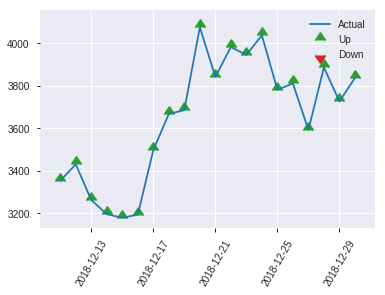


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.33431093291067787
RMSE: 0.5781962754209663
LogLoss: 0.9511046759678647
Mean Per-Class Error: 0.44780149955521664
AUC: 0.531388994789681
pr_auc: 0.51522398424841
Gini: 0.06277798957936209
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07083603818656951: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    122  0.9457   (122.0/129.0)
1      2    120  0.0164   (2.0/122.0)
Total  9    242  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.070836     0.659341  241
max f2                       0.0578811    0.826558  249
max f0point5                 0.0934529    0.55726   213
max accuracy                 0.310449     0.557769  74
max precision                0.484387     1         0
max recall                   0.0578811    1         249
max specificity              0.484387     1         0
max absolute_mcc             0.310449     0.113992  74
max min_per_class_accuracy   0.167206     0.503876  125
max mean_per_class_accuracy  0.310449     0.552199  74

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 20.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.434744           1.37158   1.37158            0.666667         0.460762   0.666667                    0.460762            0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.412754           1.37158   1.37158            0.666667         0.420894   0.666667                    0.440828            0.0163934       0.0327869                  37.1585   37.1585
    3        0.0318725                   0.402646           1.02869   1.28586            0.5              0.409433   0.625                       0.432979            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.39435            0.685792  1.12221            0.333333         0.396746   0.545455                    0.423097            0.00819672      0.0491803                  -31.4208  12.2206
    5        0.0517928                   0.391965           1.02869   1.10782            0.5              0.392965   0.538462                    0.418461            0.00819672      0.057377                   2.86885   10.7818
    6        0.103586                    0.362927           1.42434   1.26608            0.692308         0.377586   0.615385                    0.398024            0.0737705       0.131148                   42.4338   26.6078
    7        0.151394                    0.342069           0.85724   1.13697            0.416667         0.353083   0.552632                    0.383832            0.0409836       0.172131                   -14.276   13.6972
    8        0.203187                    0.333374           0.949559  1.0892             0.461538         0.338273   0.529412                    0.372219            0.0491803       0.221311                   -5.04414  8.91996
    9        0.302789                    0.31042            1.31672   1.16404            0.64             0.321037   0.565789                    0.355383            0.131148        0.352459                   31.6721   16.4042
    10       0.40239                     0.249688           0.658361  1.03887            0.32             0.291665   0.50495                     0.339611            0.0655738       0.418033                   -34.1639  3.88736
    11       0.501992                    0.167206           0.905246  1.01236            0.44             0.199671   0.492063                    0.311845            0.0901639       0.508197                   -9.47541  1.23601
    12       0.601594                    0.126445           0.740656  0.967376           0.36             0.141345   0.470199                    0.283617            0.0737705       0.581967                   -25.9344  -3.2624
    13       0.701195                    0.108756           1.39902   1.02869            0.68             0.117023   0.5                         0.259953            0.139344        0.721311                   39.9016   2.86885
    14       0.800797                    0.0989033          1.06984   1.03381            0.52             0.103759   0.502488                    0.240526            0.106557        0.827869                   6.98361   3.38064
    15       0.900398                    0.0901314          0.905246  1.01959            0.44             0.0941635  0.495575                    0.224335            0.0901639       0.918033                   -9.47541  1.95851
    16       1                           0.056717           0.822951  1                  0.4              0.0722805  0.486056                   

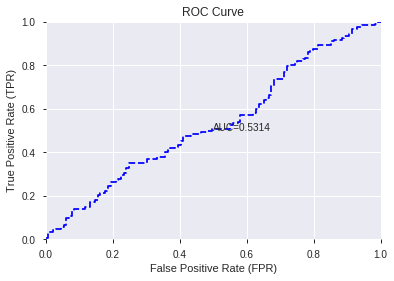

This function is available for GLM models only


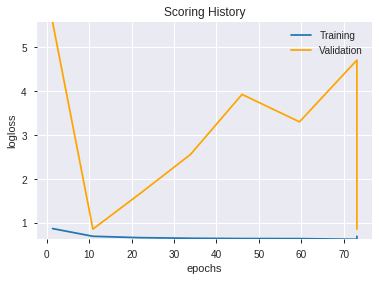

--2019-07-25 04:16:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_040545_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_040545_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_middleband_14_3_4',
 'weekday_name',
 'ATAN',
 'COS',
 'BETA_20',
 'CDLSHORTLINE',
 'BETA_30',
 'VAR_12',
 'VAR_20',
 'TANH',
 'SIN',
 'VAR_30',
 'BETA_12',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'TAN',
 'CDLHOMINGPIGEON',
 'BETA_14',
 'VAR_24',
 'CDLUNIQUE3RIVER',
 'CDLGRAVESTONEDOJI',
 'BETA_24',
 'CDLDARKCLOUDCOVER',
 'VAR_14',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'CDLHARAMICROSS',
 'CDLSTALLEDPATTERN',
 'BETA_8',
 'DIV',
 'VAR_8',
 'is_quarter_start',
 'is_month_end',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLRICKSHAWMAN',
 'CDLIDENTICAL3CROWS',
 'CDLHIKKAKEMOD',
 'CDL3LINESTRIKE',
 'CDL3INSIDE',
 'CDLSEPARATINGLINES',
 'CDLTASUKIGAP',
 'CDL3WHITESOLDIERS',
 'CDLDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_041656_model_1  0.507561  0.696945               0.48062  0.501877  0.251881

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_14_3_4             0.009258           1.000000    0.090523
1                       ATAN             0.005976           0.645485    0.058431
2               weekday_name             0.005647           0.609961    0.055216
3               CDLSHORTLINE             0.005432           0.586729    0.053113
4            CDLHOMINGPIGEON             0.004480           0.483884    0.043803
5          CDL3WHITESOLDIERS             0.004246           0.458631    0.041517
6             CDLRICKSHAWMAN             0.003801           0.410542    0.037163
7          CDLINVERTEDHAMMER             0.003606           0.389521    0.035261
8         CDLEVENINGDOJISTAR             0.003436           0.371185    0.033601
9                       TANH             0.003325           0.359170    0.032513
10             CDLHIKKAKEMOD             0.003249           0.350901    0.031765
11            CDLHARAMICROSS             0.003239           0.349872    0.031672
12              CDLTASUKIGAP             0.003045           0.328895    0.029773
13             CDLHANGINGMAN             0.002826           0.305261    0.027633
14            CDLEVENINGSTAR             0.002542           0.274545    0.024853
15                       DIV             0.002487           0.268668    0.024321
16        CDLIDENTICAL3CROWS             0.002462           0.265990    0.024078
17              CDLTHRUSTING             0.002406           0.259892    0.023526
18                       COS             0.002294           0.247753    0.022427
19           CDLUNIQUE3RIVER             0.002204           0.238120    0.021555
20        CDLMORNINGDOJISTAR             0.002117           0.228681    0.020701
21                       TAN             0.002057           0.222212    0.020115
22          is_quarter_start             0.001918           0.207131    0.018750
23           CDLSHOOTINGSTAR             0.001531           0.165378    0.014971
24               CDLDOJISTAR             0.001483           0.160240    0.014505
25              is_month_end             0.001478           0.159622    0.014449
26           CDLADVANCEBLOCK             0.001420           0.153421    0.013888
27                       SIN             0.001420           0.153414    0.013888
28                    VAR_12             0.001227           0.132517    0.011996
29                    VAR_14             0.001182           0.127695    0.011559
30                CDL3INSIDE             0.001027           0.110892    0.010038
31       CDLXSIDEGAP3METHODS             0.000878           0.094868    0.008588
32                     VAR_8             0.000854           0.092216    0.008348
33            CDLMATCHINGLOW             0.000846           0.091342    0.008269
34                   BETA_20             0.000788           0.085113    0.007705
35            CDLMORNINGSTAR             0.000667           0.072013    0.006519
36                    VAR_20             0.000620           0.066969    0.006062
37       CDLGAPSIDESIDEWHITE             0.000609           0.065801    0.005957
38                    BETA_8             0.000579           0.062531    0.005660
39         CDLGRAVESTONEDOJI             0.000533           0.057568    0.005211
40        CDLSEPARATINGLINES             0.000509           0.054945    0.004974
41         CDLDARKCLOUDCOVER             0.000458           0.049504    0.004481
42                   BETA_14             0.000407           0.043919    0.003976
43                    VAR_24             0.000402           0.043400    0.003929
44                    VAR_30             0.000343           0.037034    0.003352
45         CDLSTALLEDPATTERN             0.000314           0.033936    0.003072
46            CDL3LINESTRIKE             0.000302           0.032591    0.002950
47                   BETA_24             0.000224           0.024213    0.002192
48                   BETA_12             0.000118  

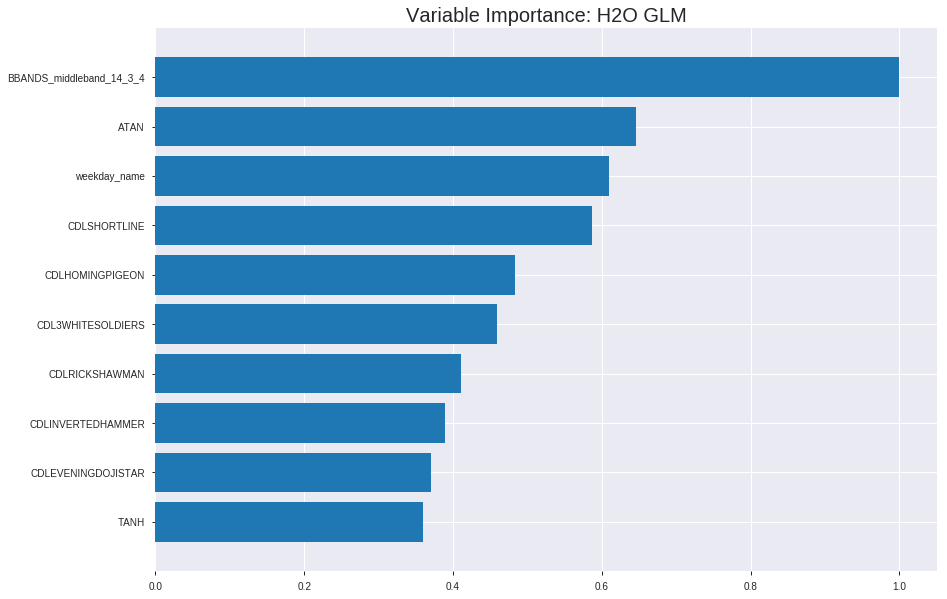

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_041656_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.246510687365575
RMSE: 0.49649842634753133
LogLoss: 0.686138546220004
Null degrees of freedom: 1751
Residual degrees of freedom: 1702
Null deviance: 2409.84717619812
Residual deviance: 2404.2294659548947
AIC: 2504.2294659548947
AUC: 0.5844762513255917
pr_auc: 0.6370110546582007
Gini: 0.16895250265118333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5378290288563885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    781   0.9949   (781.0/785.0)
1      0    967   0        (0.0/967.0)
Total  4    1748  0.4458   (781.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.537829     0.712339  395
max f2                       0.537829     0.860933  395
max f0point5                 0.549586     0.613696  260
max accuracy                 0.550476     0.571918  240
max precision                0.587014     1         0
max recall                   0.537829     1         395
max specificity              0.587014     1         0
max absolute_mcc             0.554166     0.155017  153
max min_per_class_accuracy   0.551301     0.556688  220
max mean_per_class_accuracy  0.553966     0.569042  157

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.568492           1.81179   1.81179            1                0.576795  1                           0.576795            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.564452           1.1072    1.4595             0.611111         0.565953  0.805556                    0.571374            0.0113754       0.0299897                  10.7204   45.9497
    3        0.0302511                   0.563103           0.959182  1.29902            0.529412         0.563621  0.716981                    0.568887            0.00930714      0.0392968                  -4.08176  29.9019
    4        0.0405251                   0.562435           1.30851   1.30143            0.722222         0.562853  0.71831                     0.567357            0.0134436       0.0527404                  30.8514   30.1426
    5        0.0502283                   0.561767           1.38549   1.31766            0.764706         0.562111  0.727273                    0.566344            0.0134436       0.0661841                  38.5486   31.7665
    6        0.100457                    0.558131           1.23531   1.27649            0.681818         0.559874  0.704545                    0.563109            0.0620476       0.128232                   23.5311   27.6488
    7        0.150114                    0.556005           1.14538   1.23312            0.632184         0.556951  0.680608                    0.561072            0.0568769       0.185109                   14.5384   23.3119
    8        0.200342                    0.55496            1.19413   1.22334            0.659091         0.555462  0.675214                    0.559666            0.0599793       0.245088                   19.4134   22.3345
    9        0.300228                    0.553543           1.12849   1.19179            0.622857         0.554228  0.657795                    0.557857            0.11272         0.357808                   12.8486   19.1785
    10       0.400114                    0.552461           0.962836  1.13463            0.531429         0.552953  0.626248                    0.556632            0.0961737       0.453981                   -3.71635  13.463
    11       0.5                         0.551371           0.97319   1.10238            0.537143         0.5519    0.608447                    0.555687            0.0972079       0.551189                   -2.68105  10.2378
    12       0.599886                    0.55036            1.02495   1.08949            0.565714         0.550881  0.601332                    0.554887            0.102378        0.653568                   2.49549   8.94868
    13       0.699772                    0.549303           0.859306  1.05663            0.474286         0.549824  0.583197                    0.554164            0.0858325       0.7394                     -14.0694  5.66306
    14       0.799658                    0.548196           0.869659  1.03328            0.48             0.548824  0.570307                    0.553497            0.0868666       0.826267                   -13.0341  3.32758
    15       0.899543                    0.546496           0.817893  1.00936            0.451429         0.547368  0.557107                    0.552817            0.081696        0.907963                   -18.2107  0.935963
    16       1                           0.521138           0.916189  1                  0.505682         0.544097  0.551941                    0.551941         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2708358090794702
RMSE: 0.5204188784810464
LogLoss: 0.7998030939382607
Null degrees of freedom: 499
Residual degrees of freedom: 450
Null deviance: 682.7250417755
Residual deviance: 799.8030939382606
AIC: 899.8030939382606
AUC: 0.4698964884696017
pr_auc: 0.5389155691429259
Gini: -0.060207023060796616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.50371699790446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503717     0.730964  399
max f2                       0.503717     0.871671  399
max f0point5                 0.516819     0.631649  391
max accuracy                 0.516819     0.58      391
max precision                0.99886      0.666667  0
max recall                   0.503717     1         399
max specificity              0.99886      0.995283  0
max absolute_mcc             0.550191     0.109045  195
max min_per_class_accuracy   0.546368     0.466981  225
max mean_per_class_accuracy  0.537255     0.52876   313

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 60.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.996216           1.04167   1.04167            0.6              0.998711  0.6                         0.998711            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.98946            0.694444  0.868056           0.4              0.993536  0.5                         0.996124            0.00694444      0.0173611                  -30.5556  -13.1944
    3        0.03                        0.969838           0.694444  0.810185           0.4              0.983648  0.466667                    0.991965            0.00694444      0.0243056                  -30.5556  -18.9815
    4        0.04                        0.952017           0.694444  0.78125            0.4              0.962295  0.45                        0.984547            0.00694444      0.03125                    -30.5556  -21.875
    5        0.05                        0.930306           0.694444  0.763889           0.4              0.942732  0.44                        0.976184            0.00694444      0.0381944                  -30.5556  -23.6111
    6        0.1                         0.812274           0.833333  0.798611           0.48             0.875758  0.46                        0.925971            0.0416667       0.0798611                  -16.6667  -20.1389
    7        0.15                        0.734217           0.902778  0.833333           0.52             0.771517  0.48                        0.874486            0.0451389       0.125                      -9.72222  -16.6667
    8        0.2                         0.631327           1.11111   0.902778           0.64             0.685855  0.52                        0.827328            0.0555556       0.180556                   11.1111   -9.72222
    9        0.3                         0.573462           0.902778  0.902778           0.52             0.597765  0.52                        0.750807            0.0902778       0.270833                   -9.72222  -9.72222
    10       0.4                         0.549823           0.833333  0.885417           0.48             0.560785  0.51                        0.703302            0.0833333       0.354167                   -16.6667  -11.4583
    11       0.5                         0.546257           1.21528   0.951389           0.7              0.547814  0.548                       0.672204            0.121528        0.475694                   21.5278   -4.86111
    12       0.6                         0.544012           1.25      1.00116            0.72             0.545206  0.576667                    0.651038            0.125           0.600694                   25        0.115741
    13       0.7                         0.542149           1.07639   1.0119             0.62             0.543025  0.582857                    0.635607            0.107639        0.708333                   7.63889   1.19048
    14       0.8                         0.537468           1.14583   1.02865            0.66             0.540328  0.5925                      0.623698            0.114583        0.822917                   14.5833   2.86458
    15       0.9                         0.530994           0.729167  0.99537            0.42             0.534612  0.573333                    0.613799            0.0729167       0.895833                   -27.0833  -0.462963
    16       1                           0.503717           1.04167   1                  0.6              0.522921  0.576                       0.604


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:16:56  0.000 sec   2            4.1       50            1.37228           1.59961
    2019-07-25 04:16:56  0.014 sec   4            2.5       51            1.37062           1.83424
    2019-07-25 04:16:56  0.028 sec   6            1.6       51            1.36831           2.23824
    2019-07-25 04:16:56  0.043 sec   8            0.98      51            1.36529           2.88894
    2019-07-25 04:16:56  0.061 sec   10           0.61      51            1.36165           9.14551

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6630434782608696)

('auc', 0.5075613165586479)

('logloss', 0.696945060144244)

('mean_per_class_error', 0.4733765408565256)

('rmse', 0.5018769924233659)

('mse', 0.2518805155239233)

glm prediction progress: |████████████████████████████████████████████████| 100%


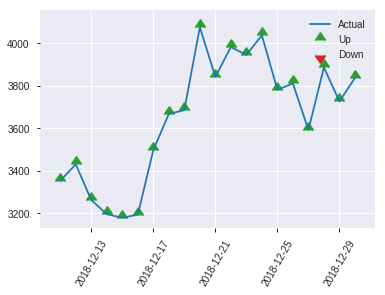


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2518805155239233
RMSE: 0.5018769924233659
LogLoss: 0.696945060144244
Null degrees of freedom: 250
Residual degrees of freedom: 201
Null deviance: 352.1428302126968
Residual deviance: 349.86642019241043
AIC: 449.86642019241043
AUC: 0.5075613165586479
pr_auc: 0.49577925225779124
Gini: 0.01512263311729578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4895142007456588: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    124  0.9612   (124.0/129.0)
1      0    122  0        (0.0/122.0)
Total  5    246  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489514     0.663043  245
max f2                       0.489514     0.831063  245
max f0point5                 0.493313     0.552486  240
max accuracy                 0.56371      0.52988   33
max precision                0.6904       1         0
max recall                   0.489514     1         245
max specificity              0.6904       1         0
max absolute_mcc             0.489514     0.138644  245
max min_per_class_accuracy   0.521988     0.503876  125
max mean_per_class_accuracy  0.535095     0.526623  95

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 53.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.668895           0.685792  0.685792           0.333333         0.680334  0.333333                    0.680334            0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.652838           2.05738   1.37158            1                0.662434  0.666667                    0.671384            0.0245902       0.0327869                  105.738   37.1585
    3        0.0318725                   0.637266           1.02869   1.28586            0.5              0.64147   0.625                       0.663905            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.601772           1.37158   1.30924            0.666667         0.616241  0.636364                    0.650906            0.0163934       0.057377                   37.1585   30.924
    5        0.0517928                   0.594811           0         1.10782            0                0.596439  0.538462                    0.642527            0               0.057377                   -100      10.7818
    6        0.103586                    0.571129           0.949559  1.02869            0.461538         0.583631  0.5                         0.613079            0.0491803       0.106557                   -5.04414  2.86885
    7        0.151394                    0.560472           1.20014   1.08283            0.583333         0.565742  0.526316                    0.59813             0.057377        0.163934                   20.0137   8.283
    8        0.203187                    0.550884           1.10782   1.0892             0.538462         0.555043  0.529412                    0.587147            0.057377        0.221311                   10.7818   8.91996
    9        0.302789                    0.541936           0.905246  1.02869            0.44             0.546247  0.5                         0.573693            0.0901639       0.311475                   -9.47541  2.86885
    10       0.40239                     0.532464           1.06984   1.03887            0.52             0.537354  0.50495                     0.564698            0.106557        0.418033                   6.98361   3.88736
    11       0.501992                    0.521988           0.905246  1.01236            0.44             0.52693   0.492063                    0.557205            0.0901639       0.508197                   -9.47541  1.23601
    12       0.601594                    0.51065            0.658361  0.953751           0.32             0.515934  0.463576                    0.550372            0.0655738       0.57377                    -34.1639  -4.62491
    13       0.701195                    0.504556           1.31672   1.00531            0.64             0.507458  0.488636                    0.544276            0.131148        0.704918                   31.6721   0.530924
    14       0.800797                    0.499536           0.987541  1.0031             0.48             0.501857  0.487562                    0.539               0.0983607       0.803279                   -1.2459   0.309926
    15       0.900398                    0.495188           0.987541  1.00138            0.48             0.497034  0.486726                    0.534358            0.0983607       0.901639                   -1.2459   0.137821
    16       1                           0.484904           0.987541  1                  0.48             0.492308  0.486056                    0.53017        

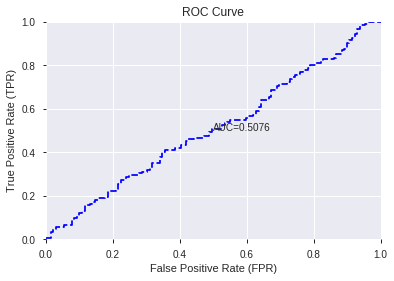

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


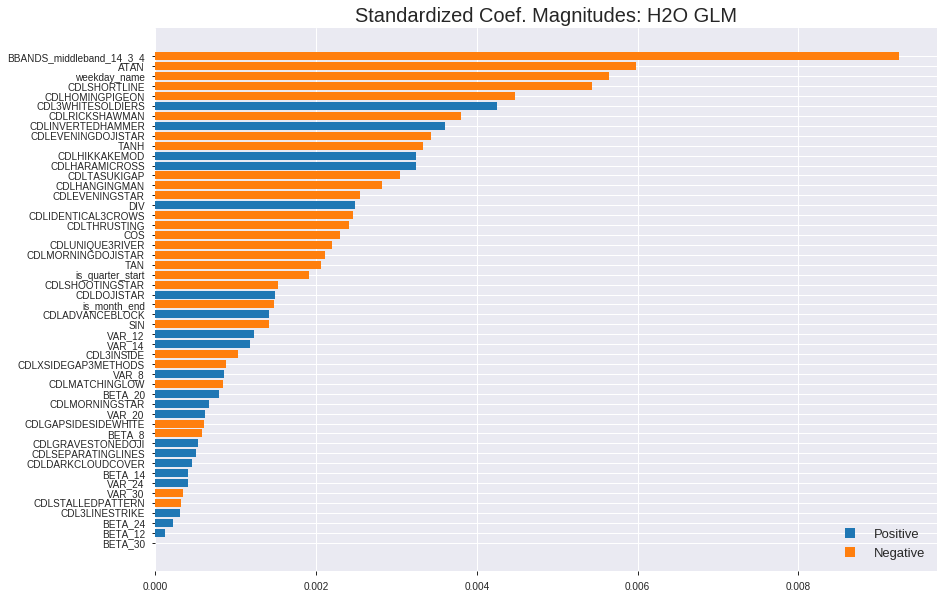

'log_likelihood'
--2019-07-25 04:17:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_041656_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_041656_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BBANDS_middleband_14_3_4',
 'ATAN',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGDOJISTAR',
 'TANH',
 'CDLHIKKAKEMOD',
 'CDLHARAMICROSS',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'DIV',
 'CDLIDENTICAL3CROWS',
 'CDLTHRUSTING',
 'COS',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'TAN',
 'is_quarter_start',
 'CDLSHOOTINGSTAR',
 'CDLDOJISTAR',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'SIN',
 'VAR_12',
 'VAR_14',
 'CDL3INSIDE',
 'CDLXSIDEGAP3METHODS',
 'VAR_8',
 'CDLMATCHINGLOW',
 'BETA_20',
 'CDLMORNINGSTAR',
 'VAR_20',
 'CDLGAPSIDESIDEWHITE',
 'BETA_8',
 'CDLGRAVESTONEDOJI',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER',
 'BETA_14',
 'VAR_24',
 'VAR_30',
 'CDLSTALLEDPATTERN',
 'CDL3LINESTRIKE',
 'BETA_24',
 'BETA_12',
 'BETA_30']

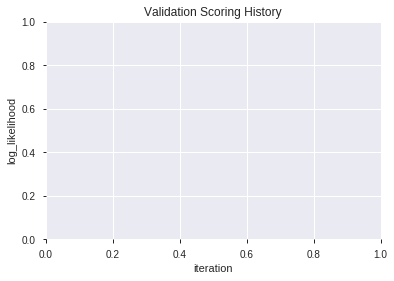

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_041710_model_7  0.535519  0.702671              0.500000  0.504561  0.254582
1  XGBoost_grid_1_AutoML_20190725_041710_model_1  0.534439  0.714734              0.500000  0.510345  0.260452
2  XGBoost_grid_1_AutoML_20190725_041710_model_2  0.517887  0.699715              0.496124  0.503226  0.253237
3  XGBoost_grid_1_AutoML_20190725_041710_model_6  0.517124  0.714841              0.492470  0.510376  0.260484
4               XGBoost_1_AutoML_20190725_041710  0.514678  0.711074              0.500000  0.508644  0.258719
5  XGBoost_grid_1_AutoML_20190725_041710_model_3  0.503685  0.723596              0.500000  0.514445  0.264653
6  XGBoost_grid_1_AutoML_20190725_041710_model_4  0.501652  0.701381              0.492248  0.504042  0.254058
7               XGBoost_3_AutoML_20190725_041710  0.496696  0.706488              0.500000  0.506528  0.256571
8               XGBoost_2_AutoML_20190725_041710  0.482717  0.714013              0.500000  0.510053  0.260154
9  XGBoost_grid_1_AutoML_20190725_041710_model_5  0.480811  0.746567              0.484496  0.523948  0.274521

variable  relative_importance  scaled_importance  percentage
0                        DIV           560.197693           1.000000    0.080835
1                     BETA_8           502.148743           0.896378    0.072459
2                        COS           497.689453           0.888418    0.071815
3                    BETA_12           408.348022           0.728936    0.058924
4                        TAN           404.767456           0.722544    0.058407
5                        SIN           393.585602           0.702583    0.056793
6                      VAR_8           392.125244           0.699977    0.056583
7                    BETA_20           387.467834           0.691663    0.055911
8                       ATAN           382.050690           0.681993    0.055129
9   BBANDS_middleband_14_3_4           354.056335           0.632020    0.051089
10                   BETA_24           343.122437           0.612502    0.049512
11                   BETA_30           332.201630           0.593008    0.047936
12                   BETA_14           320.961578           0.572943    0.046314
13                    VAR_24           296.200409           0.528743    0.042741
14                    VAR_30           277.918640           0.496108    0.040103
15                    VAR_12           270.227539           0.482379    0.038993
16              weekday_name           266.769165           0.476205    0.038494
17                    VAR_14           194.200897           0.346665    0.028023
18                    VAR_20           173.109726           0.309015    0.024979
19              CDLSHORTLINE           121.961342           0.217711    0.017599
20                      TANH            35.319443           0.063048    0.005097
21            CDLRICKSHAWMAN            10.702056           0.019104    0.001544
22              is_month_end             5.001296           0.008928    0.000722

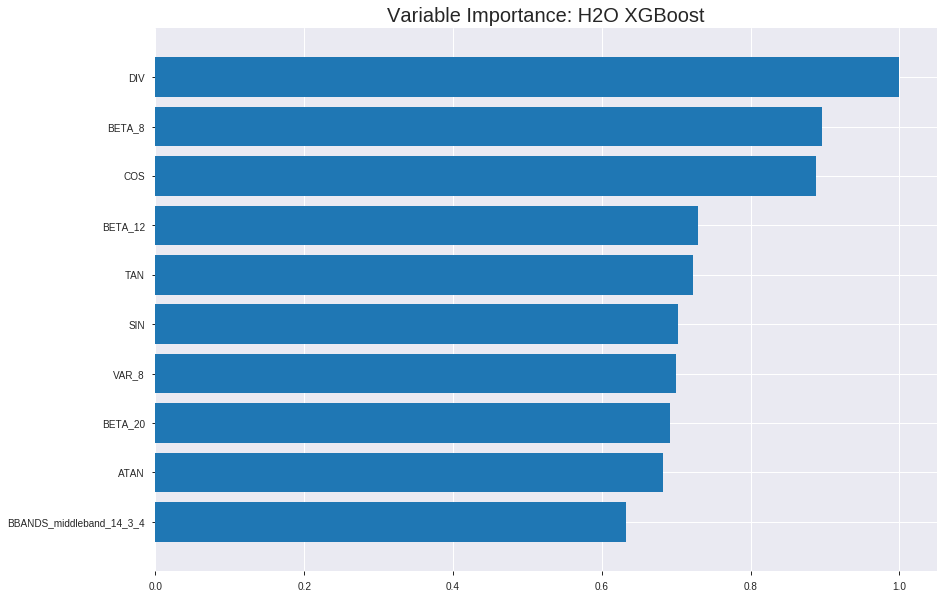

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_041710_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16345003731206026
RMSE: 0.4042895463798937
LogLoss: 0.5112978077420046
Mean Per-Class Error: 0.1351082539076136
AUC: 0.9346952621213419
pr_auc: 0.9449170239701594
Gini: 0.8693905242426838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.525476050376892: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      650  135   0.172    (135.0/785.0)
1      95   872   0.0982   (95.0/967.0)
Total  745  1007  0.1313   (230.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525476     0.883485  215
max f2                       0.495391     0.91847   237
max f0point5                 0.561551     0.888687  189
max accuracy                 0.525476     0.868721  215
max precision                0.85196      1         0
max recall                   0.343119     1         344
max specificity              0.85196      1         0
max absolute_mcc             0.525476     0.73409   215
max min_per_class_accuracy   0.540125     0.859359  204
max mean_per_class_accuracy  0.525476     0.864892  215

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 54.90 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.818119           1.81179    1.81179            1                0.836093  1                           0.836093            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.798696           1.81179    1.81179            1                0.808624  1                           0.822358            0.0186143       0.0372285                  81.1789   81.1789
    3        0.0302511                   0.784745           1.81179    1.81179            1                0.79138   1                           0.812422            0.0175801       0.0548087                  81.1789   81.1789
    4        0.0405251                   0.77347            1.81179    1.81179            1                0.778367  1                           0.803788            0.0186143       0.073423                   81.1789   81.1789
    5        0.0502283                   0.766783           1.81179    1.81179            1                0.770582  1                           0.797373            0.0175801       0.0910031                  81.1789   81.1789
    6        0.100457                    0.733435           1.81179    1.81179            1                0.748522  1                           0.772948            0.0910031       0.182006                   81.1789   81.1789
    7        0.150114                    0.707788           1.74931    1.79112            0.965517         0.719875  0.988593                    0.755391            0.0868666       0.268873                   74.9314   79.1122
    8        0.200342                    0.682212           1.7912     1.79114            0.988636         0.695563  0.988604                    0.740392            0.089969        0.358842                   79.1201   79.1142
    9        0.300228                    0.638269           1.69791    1.76012            0.937143         0.661208  0.971483                    0.714048            0.169597        0.528438                   69.7905   76.0122
    10       0.400114                    0.597924           1.55296    1.70841            0.857143         0.617832  0.942939                    0.690028            0.155119        0.683557                   55.2962   70.8406
    11       0.5                         0.555681           1.35625    1.63806            0.748571         0.57908   0.90411                     0.667864            0.135471        0.819028                   35.6254   63.8056
    12       0.599886                    0.513726           1.00425    1.53252            0.554286         0.534412  0.845861                    0.645643            0.10031         0.919338                   0.424878  53.2522
    13       0.699772                    0.46506            0.445182   1.37731            0.245714         0.490463  0.760196                    0.623492            0.0444674       0.963806                   -55.4818  37.7314
    14       0.799658                    0.408892           0.196709   1.22984            0.108571         0.437079  0.678801                    0.600207            0.0196484       0.983454                   -80.3291  22.9844
    15       0.899543                    0.356143           0.13459    1.10823            0.0742857        0.381132  0.611675                    0.575881            0.0134436       0.996898                   -86.541   10.8226
    16       1                           0.195295           0.0308828  1                  0.0170455        0.308091  0.551941                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2575974205704738
RMSE: 0.5075405605175549
LogLoss: 0.7087280226144526
Mean Per-Class Error: 0.4825406184486374
AUC: 0.44549266247379454
pr_auc: 0.5533489796819734
Gini: -0.10901467505241091
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3301801383495331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    211  0.9953   (211.0/212.0)
1      0    288  0        (0.0/288.0)
Total  1    499  0.422    (211.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33018      0.731893  398
max f2                       0.33018      0.872199  398
max f0point5                 0.33018      0.630473  398
max accuracy                 0.33018      0.578     398
max precision                0.709756     1         0
max recall                   0.33018      1         398
max specificity              0.709756     1         0
max absolute_mcc             0.546031     0.129815  200
max min_per_class_accuracy   0.55044      0.447917  191
max mean_per_class_accuracy  0.645258     0.517459  33

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.68866            0.694444  0.694444           0.4              0.703772  0.4                         0.703772            0.00694444      0.00694444                 -30.5556  -30.5556
    2        0.02                        0.674885           1.38889   1.04167            0.8              0.685327  0.6                         0.69455             0.0138889       0.0208333                  38.8889   4.16667
    3        0.03                        0.668483           1.73611   1.27315            1                0.672122  0.733333                    0.687074            0.0173611       0.0381944                  73.6111   27.3148
    4        0.04                        0.660392           1.38889   1.30208            0.8              0.664826  0.75                        0.681512            0.0138889       0.0520833                  38.8889   30.2083
    5        0.05                        0.654279           1.04167   1.25               0.6              0.65843   0.72                        0.676895            0.0104167       0.0625                     4.16667   25
    6        0.1                         0.635185           0.833333  1.04167            0.48             0.643698  0.6                         0.660297            0.0416667       0.104167                   -16.6667  4.16667
    7        0.15                        0.620211           0.694444  0.925926           0.4              0.627166  0.533333                    0.649253            0.0347222       0.138889                   -30.5556  -7.40741
    8        0.2                         0.608351           0.763889  0.885417           0.44             0.61372   0.51                        0.64037             0.0381944       0.177083                   -23.6111  -11.4583
    9        0.3                         0.588996           1.07639   0.949074           0.62             0.600582  0.546667                    0.627107            0.107639        0.284722                   7.63889   -5.09259
    10       0.4                         0.568316           0.798611  0.911458           0.46             0.576439  0.525                       0.61444             0.0798611       0.364583                   -20.1389  -8.85417
    11       0.5                         0.548019           0.902778  0.909722           0.52             0.55704   0.524                       0.60296             0.0902778       0.454861                   -9.72222  -9.02778
    12       0.6                         0.528149           1.00694   0.925926           0.58             0.538799  0.533333                    0.592267            0.100694        0.555556                   0.694444  -7.40741
    13       0.7                         0.507798           1.14583   0.957341           0.66             0.518783  0.551429                    0.581769            0.114583        0.670139                   14.5833   -4.26587
    14       0.8                         0.474598           1.00694   0.963542           0.58             0.491298  0.555                       0.57046             0.100694        0.770833                   0.694444  -3.64583
    15       0.9                         0.438627           1.21528   0.991512           0.7              0.456851  0.571111                    0.557837            0.121528        0.892361                   21.5278   -0.848765
    16       1                           0.297225           1.07639   1                  0.62             0.394224  0.576                       0.541476   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:17:20  5.627 sec   0                  0.5              0.693147            0.5             0                  1                0.448059                         0.5                0.693147              0.5               0                    1                  0.424
    2019-07-25 04:17:20  5.708 sec   5                  0.484465         0.662454            0.788174        0.813199           1.81179          0.287671                         0.501097           0.695346              0.4612            0.546876             0.694444           0.422
    2019-07-25 04:17:20  5.762 sec   10                 0.472666         0.639535            0.82931         0.854371           1.81179          0.252283                         0.500824           0.694815              0.446328          0.534425             0.694444           0.42
    2019-07-25 04:17:20  5.823 sec   15                 0.461404         0.617893            0.858645        0.880544           1.81179          0.233447                         0.50209            0.6974                0.447384          0.532611             0.694444           0.424
    2019-07-25 04:17:20  5.898 sec   20                 0.451867         0.599701            0.872716        0.89277            1.81179          0.215183                         0.503987           0.701256              0.43411           0.525601             0.694444           0.424
    2019-07-25 04:17:20  5.962 sec   25                 0.441581         0.580359            0.894183        0.91022            1.81179          0.190068                         0.505078           0.70354               0.427509          0.527554             0.694444           0.424
    2019-07-25 04:17:20  6.029 sec   30                 0.432129         0.562617            0.904945        0.920414           1.81179          0.166096                         0.506136           0.70582               0.434388          0.534381             0.347222           0.422
    2019-07-25 04:17:20  6.107 sec   35                 0.424005         0.54755             0.916472        0.929875           1.81179          0.152397                         0.50642            0.706354              0.44718           0.54964              0.694444           0.422
    2019-07-25 04:17:20  6.166 sec   40                 0.417552         0.535504            0.92169         0.934505           1.81179          0.148402                         0.506287           0.706116              0.452986          0.555687             0.694444           0.42
    2019-07-25 04:17:20  6.231 sec   45                 0.411033         0.523511            0.928106        0.939475           1.81179          0.138128                         0.5077             0.708997              0.444363          0.551913             1.38889            0.42
    2019-07-25 04:17:20  6.298 sec   50                 0.40429          0.511298            0.934695        0.944917           1.81179          0.131279                         0.507541           0.708728              0.445493          0.553349             0.694444           0.422

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
DIV             560.1976928710938      1.0                   0.08083505385280607
BETA_8          502.14874267578125     0.8963777414044616    0.07245874299888633
COS             497.689453125          0.8884175344854955    0.07181527924391223
BETA_12         408.3480224609375      0.7289355662428654    0.05892354575246771
TAN             404.7674560546875      0.7225439540462869    0.058406879436351034
---             ---                    ---                   ---
VAR_20          173.10972595214844     0.3090154210827542    0.024979278204571978
CDLSHORTLINE    121.96134185791016     0.21771125338421288   0.017598700891674757
TANH            35.31944274902344      0.06304817602515679   0.0050965027043147456
CDLRICKSHAWMAN  10.702055931091309     0.019104069986867908  0.0015442785261962435
is_month_end    5.001296043395996      0.008927734096446621  0.0007216738664697956


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6541554959785523)

('auc', 0.53551912568306)

('logloss', 0.7026706830695115)

('mean_per_class_error', 0.45399669589528524)

('rmse', 0.5045614023209936)

('mse', 0.2545822087121275)

xgboost prediction progress: |████████████████████████████████████████████| 100%


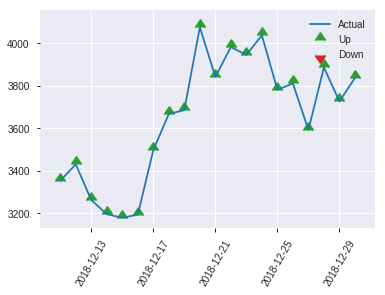


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2545822087121275
RMSE: 0.5045614023209936
LogLoss: 0.7026706830695115
Mean Per-Class Error: 0.45399669589528524
AUC: 0.53551912568306
pr_auc: 0.5165094419784976
Gini: 0.07103825136612008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33360815048217773: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    129  1        (129.0/129.0)
1      0    122  0        (0.0/122.0)
Total  0    251  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333608     0.654155   250
max f2                       0.333608     0.82544    250
max f0point5                 0.478103     0.546039   202
max accuracy                 0.580618     0.549801   88
max precision                0.724503     1          0
max recall                   0.333608     1          250
max specificity              0.724503     1          0
max absolute_mcc             0.580618     0.0956614  88
max min_per_class_accuracy   0.549823     0.511628   125
max mean_per_class_accuracy  0.579643     0.546003   90

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.693268           1.37158   1.37158            0.666667         0.713258  0.666667                    0.713258            0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.679028           1.37158   1.37158            0.666667         0.686584  0.666667                    0.699921            0.0163934       0.0327869                  37.1585   37.1585
    3        0.0318725                   0.673169           1.02869   1.28586            0.5              0.675582  0.625                       0.693836            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.658735           0.685792  1.12221            0.333333         0.663679  0.545455                    0.685612            0.00819672      0.0491803                  -31.4208  12.2206
    5        0.0517928                   0.651659           2.05738   1.26608            1                0.652456  0.615385                    0.680511            0.0163934       0.0655738                  105.738   26.6078
    6        0.103586                    0.628117           0.949559  1.10782            0.461538         0.638157  0.538462                    0.659334            0.0491803       0.114754                   -5.04414  10.7818
    7        0.151394                    0.610583           0.85724   1.02869            0.416667         0.621437  0.5                         0.647366            0.0409836       0.155738                   -14.276   2.86885
    8        0.203187                    0.602068           1.42434   1.12954            0.692308         0.606175  0.54902                     0.636867            0.0737705       0.229508                   42.4338   12.954
    9        0.302789                    0.589475           1.06984   1.1099             0.52             0.595951  0.539474                    0.623408            0.106557        0.336066                   6.98361   10.9901
    10       0.40239                     0.572017           1.06984   1.09998            0.52             0.581036  0.534653                    0.61292             0.106557        0.442623                   6.98361   9.99838
    11       0.501992                    0.549823           0.740656  1.02869            0.36             0.561121  0.5                         0.602642            0.0737705       0.516393                   -25.9344  2.86885
    12       0.601594                    0.532936           0.987541  1.02188            0.48             0.541434  0.496689                    0.592508            0.0983607       0.614754                   -1.2459   2.1876
    13       0.701195                    0.50852            1.15213   1.04038            0.56             0.519531  0.505682                    0.582142            0.114754        0.729508                   15.2131   4.03782
    14       0.800797                    0.480737           0.905246  1.02357            0.44             0.492924  0.497512                    0.571045            0.0901639       0.819672                   -9.47541  2.35707
    15       0.900398                    0.435467           0.822951  1.00138            0.4              0.458751  0.486726                    0.558623            0.0819672       0.901639                   -17.7049  0.137821
    16       1                           0.333608           0.987541  1                  0.48             0.396733  0.486056                    0.542499          

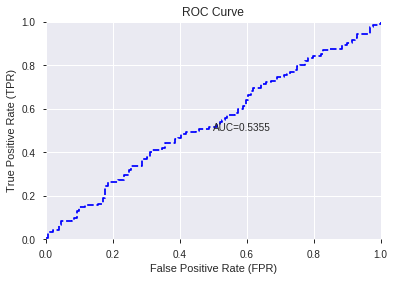

This function is available for GLM models only


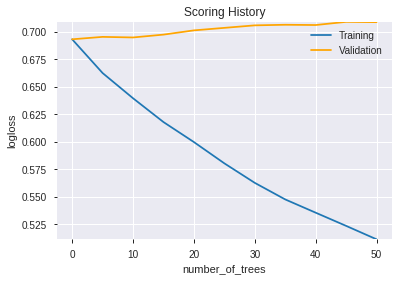

--2019-07-25 04:17:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_041710_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_041710_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'BETA_8',
 'COS',
 'BETA_12',
 'TAN',
 'SIN',
 'VAR_8',
 'BETA_20',
 'ATAN',
 'BBANDS_middleband_14_3_4',
 'BETA_24',
 'BETA_30',
 'BETA_14',
 'VAR_24',
 'VAR_30',
 'VAR_12',
 'weekday_name',
 'VAR_14',
 'VAR_20',
 'CDLSHORTLINE',
 'TANH',
 'CDLRICKSHAWMAN',
 'is_month_end']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

114

['BBANDS_lowerband_8_0_5',
 'BBANDS_lowerband_8_1_5',
 'BBANDS_lowerband_8_6_5',
 'BBANDS_lowerband_8_7_5',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_lowerband_12_0_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_lowerband_12_1_5',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_lowerband_12_2_5',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_lowerband_12_5_5',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_lowerband_12_7_5',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_lowerband_14_0_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_lowerband_14_2_5',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'MIDPRICE_20',
 'BBANDS

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190725_041737  0.563223   7.233466              0.477634  0.696991  0.485796
1  DeepLearning_grid_1_AutoML_20190725_041737_model_2  0.546321  15.667714              0.466006  0.697177  0.486056
2  DeepLearning_grid_1_AutoML_20190725_041737_model_1  0.542000  16.191256              0.476744  0.697177  0.486056
3  DeepLearning_grid_1_AutoML_20190725_041737_model_3  0.534375  10.041363              0.469882  0.690070  0.476197
4  DeepLearning_grid_1_AutoML_20190725_041737_model_7  0.500000   0.747933              0.500000  0.525573  0.276227
5  DeepLearning_grid_1_AutoML_20190725_041737_model_5  0.500000   0.696111              0.500000  0.501478  0.251480
6  DeepLearning_grid_1_AutoML_20190725_041737_model_6  0.500000   0.692898              0.500000  0.499875  0.249875
7  DeepLearning_grid_1_AutoML_20190725_041737_model_8  0.500000   0.699102              0.500000  0.502959  0.252968
8  DeepLearning_grid_1_AutoML_20190725_041737_model_9  0.500000   0.699618              0.500000  0.503214  0.253224
9  DeepLearning_grid_1_AutoML_20190725_041737_model_4  0.495679   0.698113              0.500000  0.502105  0.252109

variable  relative_importance  scaled_importance  percentage
0     BBANDS_lowerband_24_0_4             1.000000           1.000000    0.013243
1     BBANDS_lowerband_30_5_3             0.947281           0.947281    0.012545
2    BBANDS_middleband_30_5_2             0.946968           0.946968    0.012541
3                     MA_30_5             0.917512           0.917512    0.012151
4     BBANDS_lowerband_24_0_2             0.910123           0.910123    0.012053
..                        ...                  ...                ...         ...
109                    SUM_30             0.437053           0.437053    0.005788
110   BBANDS_lowerband_12_0_4             0.418757           0.418757    0.005546
111   BBANDS_lowerband_14_0_4             0.414040           0.414040    0.005483
112             MINMAX_min_24             0.393803           0.393803    0.005215
113   BBANDS_lowerband_20_0_4             0.317971           0.317971    0.004211

[114 rows x 4 columns]

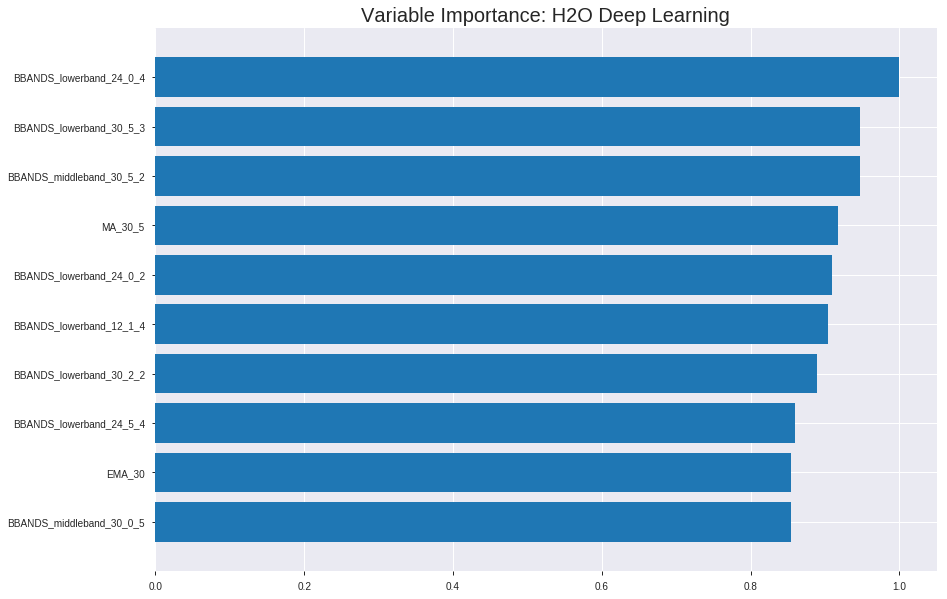

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190725_041737


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3362953519653729
RMSE: 0.5799097791599767
LogLoss: 0.996741798899893
Mean Per-Class Error: 0.4734242749589972
AUC: 0.5109479050711703
pr_auc: 0.5612816826721804
Gini: 0.021895810142340544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0012938919559342937: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    785   1        (785.0/785.0)
1      0    967   0        (0.0/967.0)
Total  0    1752  0.4481   (785.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00129389   0.711291   399
max f2                       0.00129389   0.86032    399
max f0point5                 0.00258714   0.606537   398
max accuracy                 0.145103     0.552511   325
max precision                0.945027     1          0
max recall                   0.00129389   1          399
max specificity              0.945027     1          0
max absolute_mcc             0.157512     0.0603684  319
max min_per_class_accuracy   0.444741     0.499363   205
max mean_per_class_accuracy  0.157512     0.526576   319

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 42.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.911915           1.20786   1.20786            0.666667         0.929819   0.666667                    0.929819            0.0124095       0.0124095                  20.7859   20.7859
    2        0.0205479                   0.890115           1.1072    1.15753            0.611111         0.898275   0.638889                    0.914047            0.0113754       0.0237849                  10.7204   15.7532
    3        0.0302511                   0.872612           0.532879  0.957172           0.294118         0.879749   0.528302                    0.903046            0.00517063      0.0289555                  -46.7121  -4.28284
    4        0.0405251                   0.859202           1.30851   1.04624            0.722222         0.865942   0.577465                    0.893639            0.0134436       0.0423992                  30.8514   4.62444
    5        0.0502283                   0.851884           0.959182  1.02943            0.529412         0.854507   0.568182                    0.88608             0.00930714      0.0517063                  -4.08176  2.94256
    6        0.100457                    0.79811            1.00884   1.01913            0.556818         0.826515   0.5625                      0.856297            0.0506722       0.102378                   0.883708  1.91313
    7        0.150114                    0.754781           0.957957  0.998895           0.528736         0.775251   0.551331                    0.829487            0.0475698       0.149948                   -4.20426  -0.11049
    8        0.200342                    0.704423           0.926483  0.980741           0.511364         0.729764   0.541311                    0.804486            0.0465357       0.196484                   -7.3517   -1.92595
    9        0.300228                    0.622659           1.07672   1.01267            0.594286         0.662799   0.558935                    0.757347            0.107549        0.304033                   7.67203   1.2673
    10       0.400114                    0.548284           1.04566   1.02091            0.577143         0.587278   0.563481                    0.71489             0.104447        0.40848                    4.56611   2.09082
    11       0.5                         0.444399           0.911071  0.998966           0.502857         0.498504   0.55137                     0.671662            0.0910031       0.499483                   -8.89289  -0.103413
    12       0.599886                    0.282141           1.09743   1.01536            0.605714         0.353657   0.560419                    0.618712            0.109617        0.6091                     9.74265   1.53604
    13       0.699772                    0.198019           1.09743   1.02707            0.605714         0.24015    0.566884                    0.564676            0.109617        0.718718                   9.74265   2.70745
    14       0.799658                    0.117056           0.900718  1.01129            0.497143         0.154362   0.558173                    0.513423            0.089969        0.808687                   -9.9282   1.12912
    15       0.899543                    0.0588628          0.838599  0.992115           0.462857         0.0875255  0.547589                    0.466131            0.0837642       0.892451                   -16.1401  -0.788456
    16       1                           0.00112921         1.0706    1                  0.590909         0.0329618  0.551941             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.5688952029305062
RMSE: 0.7542514189118282
LogLoss: 6.404889056948068
Mean Per-Class Error: 0.43347091194968557
AUC: 0.5661196278825996
pr_auc: 0.6299923582308229
Gini: 0.13223925576519924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.8455760181245106e-11: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.84558e-11  0.730964  399
max f2                       1.84558e-11  0.871671  399
max f0point5                 9.66248e-10  0.637807  396
max accuracy                 9.66248e-10  0.588     396
max precision                0.0982204    1         0
max recall                   1.84558e-11  1         399
max specificity              0.0982204    1         0
max absolute_mcc             0.00442771   0.134558  143
max min_per_class_accuracy   0.000167806  0.552083  252
max mean_per_class_accuracy  0.000479553  0.566529  226

Gains/Lift Table: Avg response rate: 57.60 %, avg score:  0.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.0609676          1.38889   1.38889            0.8              0.0855599    0.8                         0.0855599           0.0138889       0.0138889                  38.8889   38.8889
    2        0.02                        0.0404197          1.38889   1.38889            0.8              0.0492881    0.8                         0.067424            0.0138889       0.0277778                  38.8889   38.8889
    3        0.03                        0.0335582          1.04167   1.27315            0.6              0.0386745    0.733333                    0.0578408           0.0104167       0.0381944                  4.16667   27.3148
    4        0.04                        0.0283114          0.347222  1.04167            0.2              0.0305126    0.6                         0.0510088           0.00347222      0.0416667                  -65.2778  4.16667
    5        0.05                        0.026628           1.04167   1.04167            0.6              0.0275935    0.6                         0.0463257           0.0104167       0.0520833                  4.16667   4.16667
    6        0.1                         0.0173719          1.25      1.14583            0.72             0.0213884    0.66                        0.0338571           0.0625          0.114583                   25        14.5833
    7        0.15                        0.0106372          1.11111   1.13426            0.64             0.0130859    0.653333                    0.0269333           0.0555556       0.170139                   11.1111   13.4259
    8        0.2                         0.00803196         1.25      1.16319            0.72             0.00944316   0.67                        0.0225608           0.0625          0.232639                   25        16.3194
    9        0.3                         0.00387386         1.14583   1.15741            0.66             0.00637461   0.666667                    0.0171654           0.114583        0.347222                   14.5833   15.7407
    10       0.4                         0.00097019         0.902778  1.09375            0.52             0.00198917   0.63                        0.0133713           0.0902778       0.4375                     -9.72222  9.375
    11       0.5                         0.000194648        1.07639   1.09028            0.62             0.000509036  0.628                       0.0107989           0.107639        0.545139                   7.63889   9.02778
    12       0.6                         7.94753e-06        0.798611  1.04167            0.46             5.15655e-05  0.6                         0.00900766          0.0798611       0.625                      -20.1389  4.16667
    13       0.7                         3.50345e-07        0.972222  1.03175            0.56             3.17273e-06  0.594286                    0.00772131          0.0972222       0.722222                   -2.77778  3.1746
    14       0.8                         5.56285e-09        1.07639   1.03733            0.62             5.51295e-08  0.5975                      0.00675615          0.107639        0.829861                   7.63889   3.73264
    15       0.9                         1.57448e-11        0.902778  1.02238            0.52             9.50357e-10  0.588889                    0.00600547          0.0902778       0.920139                   -9.72222  2.23765
    16       1                           1.05394e-20        0.798611  1                  0.46             2.19336


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:17:38  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:17:38  0.070 sec   56516 obs/sec     1         1             1752       0.57991          0.996742            -0.359856      0.510948        0.561282           1.20786          0.448059                         0.754251           6.40489               -1.3294          0.56612           0.629992             1.38889            0.424
    2019-07-25 04:17:38  0.376 sec   56516 obs/sec     10        10            17520      0.580928         1.09834             -0.364634      0.534154        0.583293           1.20786          0.448059                         0.758802           11.8766               -1.35759         0.569289          0.639531             1.38889            0.424
    2019-07-25 04:17:38  0.402 sec   56153 obs/sec     10        10            17520      0.57991          0.996742            -0.359856      0.510948        0.561282           1.20786          0.448059                         0.754251           6.40489               -1.3294          0.56612           0.629992             1.38889            0.424

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BBANDS_lowerband_24_0_4   1.0                    1.0                  0.013243472146853872
BBANDS_lowerband_30_5_3   0.9472813010215759     0.9472813010215759   0.012545293525314739
BBANDS_middleband_30_5_2  0.9469683766365051     0.9469683766365051   0.012541149319936983
MA_30_5                   0.9175118803977966     0.9175118803977966   0.012151043032455741
BBANDS_lowerband_24_0_2   0.9101226329803467     0.9101226329803467   0.012053183740096531
---                       ---                    ---                  ---
SUM_30                    0.4370526373386383     0.4370526373386383   0.005788094429303283
BBANDS_lowerband_12_0_4   0.41875678300857544    0.41875678300857544  0.005545793792080199
BBANDS_lowerband_14_0_4   0.4140397906303406     0.4140397906303406   0.005483324434902124
MINMAX_min_24             0.3938031792640686     0.3938031792640686   0.005215321435926195
BBANDS_lowerband_20_0_4   0.31797143816947937    0.31797143816947937  0.004211045884892568


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6573816155988857)

('auc', 0.5632227729063414)

('logloss', 7.233465813035389)

('mean_per_class_error', 0.41476045240818404)

('rmse', 0.6969908980227999)

('mse', 0.4857963119266291)

deeplearning prediction progress: |███████████████████████████████████████| 100%


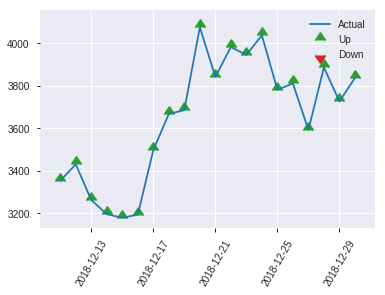


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4857963119266291
RMSE: 0.6969908980227999
LogLoss: 7.233465813035389
Mean Per-Class Error: 0.41476045240818404
AUC: 0.5632227729063414
pr_auc: 0.518400170016117
Gini: 0.12644554581268275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.896828033021617e-10: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   119  0.9225   (119.0/129.0)
1      4    118  0.0328   (4.0/122.0)
Total  14   237  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       5.89683e-10  0.657382  236
max f2                       3.09686e-12  0.82544   250
max f0point5                 6.12259e-08  0.58      156
max accuracy                 7.88797e-08  0.581673  146
max precision                0.000335353  0.619048  20
max recall                   3.09686e-12  1         250
max specificity              0.0165964    0.992248  0
max absolute_mcc             6.12259e-08  0.176048  156
max min_per_class_accuracy   1.07328e-07  0.542636  125
max mean_per_class_accuracy  6.12259e-08  0.58524   156

Gains/Lift Table: Avg response rate: 48.61 %, avg score:  0.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.00678143         0.685792  0.685792           0.333333         0.0117672    0.333333                    0.0117672           0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.00563821         0.685792  0.685792           0.333333         0.00615247   0.333333                    0.00895985          0.00819672      0.0163934                  -31.4208  -31.4208
    3        0.0318725                   0.00323296         2.05738   1.02869            1                0.00447514   0.5                         0.00783868          0.0163934       0.0327869                  105.738   2.86885
    4        0.0438247                   0.00293608         0         0.748137           0                0.00304515   0.363636                    0.00653135          0               0.0327869                  -100      -25.1863
    5        0.0517928                   0.00167517         2.05738   0.949559           1                0.00250276   0.461538                    0.00591157          0.0163934       0.0491803                  105.738   -5.04414
    6        0.103586                    0.000141858        1.42434   1.18695            0.692308         0.000560456  0.576923                    0.00323601          0.0737705       0.122951                   42.4338   18.6948
    7        0.151394                    2.79977e-05        1.02869   1.13697            0.5              5.92128e-05  0.552632                    0.00223281          0.0491803       0.172131                   2.86885   13.6972
    8        0.203187                    7.46537e-06        0.949559  1.0892             0.461538         1.43147e-05  0.529412                    0.00166731          0.0491803       0.221311                   -5.04414  8.91996
    9        0.302789                    6.92091e-07        0.987541  1.05576            0.48             2.3672e-06   0.513158                    0.00111963          0.0983607       0.319672                   -1.2459   5.57593
    10       0.40239                     1.90143e-07        1.15213   1.07961            0.56             3.22889e-07  0.524752                    0.000842577         0.114754        0.434426                   15.2131   7.96137
    11       0.501992                    1.07328e-07        1.15213   1.094              0.56             1.44242e-07  0.531746                    0.000675427         0.114754        0.54918                    15.2131   9.40021
    12       0.601594                    7.52517e-08        1.39902   1.1445             0.68             9.05014e-08  0.556291                    0.000563617         0.139344        0.688525                   39.9016   14.4501
    13       0.701195                    2.72258e-08        0.658361  1.07545            0.32             5.068e-08    0.522727                    0.000483565         0.0655738       0.754098                   -34.1639  7.54471
    14       0.800797                    1.12255e-08        0.822951  1.04404            0.4              1.80841e-08  0.507463                    0.000423422         0.0819672       0.836066                   -17.7049  4.40421
    15       0.900398                    2.54898e-09        0.905246  1.02869            0.44             6.80668e-09  0.5                         0.000376584         0.0901639       0.92623                    -9.47541  2.86885
    16       1                           3.09686e-12        0.740656  1                  0.36             

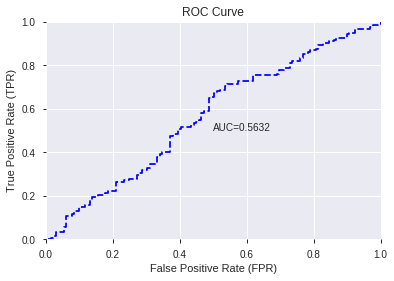

This function is available for GLM models only


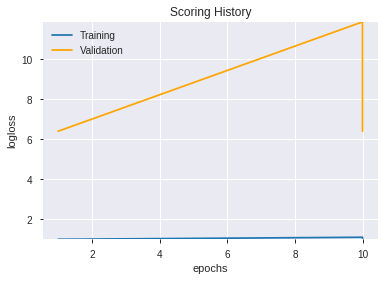

--2019-07-25 04:32:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190725_041737',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190725_041737',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b707'

['BBANDS_lowerband_24_0_4',
 'BBANDS_lowerband_30_5_3',
 'BBANDS_middleband_30_5_2',
 'MA_30_5',
 'BBANDS_lowerband_24_0_2',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_lowerband_24_5_4',
 'EMA_30',
 'BBANDS_middleband_30_0_5',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_24_1_2',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_middleband_24_5_3',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_24_0_3',
 'MFI_30',
 'BBANDS_middleband_30_0_3',
 'BBANDS_lowerband_14_2_5',
 'MIDPRICE_24',
 'CMO_30',
 'BBANDS_middleband_30_0_2',
 'BBANDS_middleband_30_1_4',
 'MINMAX_min_20',
 'BBANDS_lowerband_12_2_5',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_8_6_5',
 'BBANDS_lowerband_24_1_3',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_middleband_24_0_4',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_middleband_24_5_2',
 'BBANDS_middleband_30_1_2',
 'SMA_30',
 'MIN_24',
 'BBANDS_lowerband_12_6

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_043232_model_1  0.552484  1.901676              0.469659  0.675576  0.456403

variable  relative_importance  scaled_importance  percentage
0                 aroonup_24             0.006205           1.000000    0.031702
1                     MFI_30             0.006111           0.984788    0.031220
2                     RSI_30             0.006040           0.973332    0.030857
3                     CMO_30             0.006034           0.972333    0.030825
4                     CMO_24             0.005671           0.913865    0.028971
..                       ...                  ...                ...         ...
109  BBANDS_lowerband_14_6_4             0.001293           0.208357    0.006605
110  BBANDS_lowerband_12_2_4             0.001292           0.208152    0.006599
111  BBANDS_lowerband_12_5_3             0.001282           0.206572    0.006549
112  BBANDS_lowerband_30_2_2             0.001278           0.206016    0.006531
113  BBANDS_lowerband_12_6_4             0.001274           0.205287    0.006508

[114 rows x 4 columns]

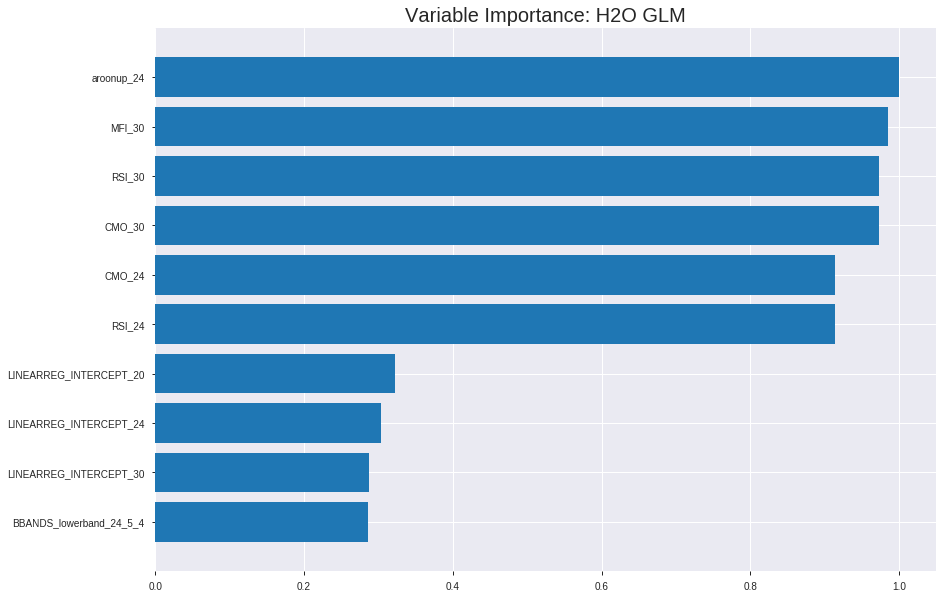

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_043232_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24447207834667714
RMSE: 0.4944411778429029
LogLoss: 0.681990013632732
Null degrees of freedom: 1751
Residual degrees of freedom: 1637
Null deviance: 2409.84717619812
Residual deviance: 2389.6930077690936
AIC: 2619.6930077690936
AUC: 0.5632259466865148
pr_auc: 0.6047709494057505
Gini: 0.12645189337302964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45951057147041785: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    781   0.9949   (781.0/785.0)
1      0    967   0        (0.0/967.0)
Total  4    1748  0.4458   (781.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459511     0.712339  396
max f2                       0.459511     0.860933  396
max f0point5                 0.508396     0.612009  300
max accuracy                 0.508396     0.566781  300
max precision                0.614087     0.727273  16
max recall                   0.459511     1         396
max specificity              0.62046      0.998726  0
max absolute_mcc             0.568207     0.11014   143
max min_per_class_accuracy   0.553884     0.542916  183
max mean_per_class_accuracy  0.568207     0.553832  143

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.010274                    0.617157           1.00655   1.00655            0.555556         0.618025  0.555556                    0.618025            0.0103413       0.0103413                  0.654947    0.654947
    2        0.0205479                   0.615747           1.1072    1.05688            0.611111         0.61625   0.583333                    0.617138            0.0113754       0.0217166                  10.7204     5.68769
    3        0.0302511                   0.614689           1.49206   1.19646            0.823529         0.615074  0.660377                    0.616476            0.0144778       0.0361944                  49.2062     19.6464
    4        0.0405251                   0.613885           1.61048   1.30143            0.888889         0.614311  0.71831                     0.615927            0.016546        0.0527404                  61.0479     30.1426
    5        0.0502283                   0.611984           1.17233   1.27649            0.647059         0.613171  0.704545                    0.615395            0.0113754       0.0641158                  17.2334     27.6488
    6        0.100457                    0.605047           1.21472   1.2456             0.670455         0.608566  0.6875                      0.61198             0.0610134       0.125129                   21.4722     24.5605
    7        0.150114                    0.599969           0.999608  1.16423            0.551724         0.602253  0.642586                    0.608762            0.0496381       0.174767                   -0.0392255  16.4229
    8        0.200342                    0.596447           1.00884   1.12527            0.556818         0.597714  0.621083                    0.605993            0.0506722       0.22544                    0.883708    12.5271
    9        0.300228                    0.584429           1.15954   1.13667            0.64             0.591903  0.627376                    0.601305            0.115822        0.341262                   15.9545     13.6674
    10       0.400114                    0.563936           1.06637   1.11912            0.588571         0.576369  0.617689                    0.59508             0.106515        0.447777                   6.63673     11.9122
    11       0.5                         0.554198           0.911071  1.07756            0.502857         0.558031  0.594749                    0.587678            0.0910031       0.53878                    -8.89289    7.75595
    12       0.599886                    0.537628           0.962836  1.05846            0.531429         0.54743   0.584206                    0.580977            0.0961737       0.634953                   -3.71635    5.84572
    13       0.699772                    0.527353           0.921424  1.0389             0.508571         0.532345  0.573409                    0.574035            0.0920372       0.726991                   -7.85759    3.8897
    14       0.799658                    0.50588            0.97319   1.03069            0.537143         0.518935  0.568879                    0.567152            0.0972079       0.824199                   -2.68105    3.06894
    15       0.899543                    0.492486           0.900718  1.01626            0.497143         0.499137  0.560914                    0.5596              0.089969        0.914168                   -9.9282     1.62573
    16       1                           0.457003           0.854423  1                  0.471591         0.483354  0.551941   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39002147118818414
RMSE: 0.6245169903118603
LogLoss: 1.5099746358415882
Null degrees of freedom: 499
Residual degrees of freedom: 385
Null deviance: 682.7250417755
Residual deviance: 1509.974635841589
AIC: 1739.974635841589
AUC: 0.5826044942348008
pr_auc: 0.6290160620659347
Gini: 0.16520898846960153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.003000554149159275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   176  0.8302   (176.0/212.0)
1      19   269  0.066    (19.0/288.0)
Total  55   445  0.39     (195.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00300055   0.73397   378
max f2                       0.000203347  0.871671  399
max f0point5                 0.0065203    0.654397  361
max accuracy                 0.0065203    0.614     361
max precision                0.432972     0.704545  76
max recall                   0.000203347  1         399
max specificity              0.491538     0.995283  0
max absolute_mcc             0.00607192   0.171964  363
max min_per_class_accuracy   0.205829     0.545139  221
max mean_per_class_accuracy  0.228835     0.577077  200

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 20.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.486949           0.347222  0.347222           0.2              0.489646     0.2                         0.489646            0.00347222      0.00347222                 -65.2778  -65.2778
    2        0.02                        0.484221           1.38889   0.868056           0.8              0.486241     0.5                         0.487943            0.0138889       0.0173611                  38.8889   -13.1944
    3        0.03                        0.47702            1.73611   1.15741            1                0.482241     0.666667                    0.486042            0.0173611       0.0347222                  73.6111   15.7407
    4        0.04                        0.475054           0.694444  1.04167            0.4              0.476135     0.6                         0.483566            0.00694444      0.0416667                  -30.5556  4.16667
    5        0.05                        0.473731           1.73611   1.18056            1                0.474549     0.68                        0.481762            0.0173611       0.0590278                  73.6111   18.0556
    6        0.1                         0.457222           1.04167   1.11111            0.6              0.462918     0.64                        0.47234             0.0520833       0.111111                   4.16667   11.1111
    7        0.15                        0.438068           1.31944   1.18056            0.76             0.447458     0.68                        0.464046            0.0659722       0.177083                   31.9444   18.0556
    8        0.2                         0.429658           1.04167   1.14583            0.6              0.433772     0.66                        0.456478            0.0520833       0.229167                   4.16667   14.5833
    9        0.3                         0.406209           1.21528   1.16898            0.7              0.415894     0.673333                    0.44295             0.121528        0.350694                   21.5278   16.8981
    10       0.4                         0.255277           1.11111   1.15451            0.64             0.326896     0.665                       0.413936            0.111111        0.461806                   11.1111   15.4514
    11       0.5                         0.20511            0.833333  1.09028            0.48             0.228304     0.628                       0.37681             0.0833333       0.545139                   -16.6667  9.02778
    12       0.6                         0.0951877          0.9375    1.06481            0.54             0.121162     0.613333                    0.334202            0.09375         0.638889                   -6.25     6.48148
    13       0.7                         0.0266449          0.902778  1.04167            0.52             0.0529033    0.6                         0.294016            0.0902778       0.729167                   -9.72222  4.16667
    14       0.8                         0.0102466          1.21528   1.06337            0.7              0.0156052    0.6125                      0.259215            0.121528        0.850694                   21.5278   6.33681
    15       0.9                         0.00262442         0.833333  1.03781            0.48             0.00580327   0.597778                    0.231058            0.0833333       0.934028                   -16.6667  3.78086
    16       1                           0.000184848        0.659722  1                  0.38             0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:32:32  0.000 sec   2            5         115           1.36398           3.01995
    2019-07-25 04:32:32  0.018 sec   3            3.7       115           1.36336           3.08992
    2019-07-25 04:32:32  0.036 sec   4            2.7       115           1.36273           3.13399
    2019-07-25 04:32:32  0.055 sec   5            1.9       115           1.36211           3.15627
    2019-07-25 04:32:32  0.074 sec   6            1.4       115           1.36152           3.15682

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6629526462395543)

('auc', 0.5524844325835557)

('logloss', 1.9016763372710157)

('mean_per_class_error', 0.4363642140043207)

('rmse', 0.6755764009988788)

('mse', 0.45640347358659794)

glm prediction progress: |████████████████████████████████████████████████| 100%


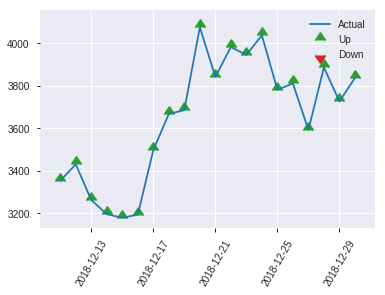


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.45640347358659794
RMSE: 0.6755764009988788
LogLoss: 1.9016763372710157
Null degrees of freedom: 250
Residual degrees of freedom: 136
Null deviance: 352.1428302126968
Residual deviance: 954.6415213100499
AIC: 1184.64152131005
AUC: 0.5524844325835557
pr_auc: 0.5161607968276608
Gini: 0.10496886516711146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0047124175804234445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   118  0.9147   (118.0/129.0)
1      3    119  0.0246   (3.0/122.0)
Total  14   237  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00471242   0.662953  236
max f2                       0.00359432   0.82768   248
max f0point5                 0.0165996    0.557971  141
max accuracy                 0.0165996    0.561753  141
max precision                0.130261     0.692308  12
max recall                   0.00359432   1         248
max specificity              0.143733     0.992248  0
max absolute_mcc             0.00479089   0.135231  233
max min_per_class_accuracy   0.0172008    0.550388  125
max mean_per_class_accuracy  0.0165996    0.563636  141

Gains/Lift Table: Avg response rate: 48.61 %, avg score:  3.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.142908           0.685792  0.685792           0.333333         0.143651    0.333333                    0.143651            0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.140245           1.37158   1.02869            0.666667         0.141581    0.5                         0.142616            0.0163934       0.0245902                  37.1585   2.86885
    3        0.0318725                   0.133049           1.02869   1.02869            0.5              0.135841    0.5                         0.140922            0.00819672      0.0327869                  2.86885   2.86885
    4        0.0438247                   0.130724           2.05738   1.30924            1                0.131116    0.636364                    0.138248            0.0245902       0.057377                   105.738   30.924
    5        0.0517928                   0.129642           2.05738   1.42434            1                0.130324    0.692308                    0.137029            0.0163934       0.0737705                  105.738   42.4338
    6        0.103586                    0.113327           0.949559  1.18695            0.461538         0.122004    0.576923                    0.129516            0.0491803       0.122951                   -5.04414  18.6948
    7        0.151394                    0.0719578          0.685792  1.02869            0.333333         0.10074     0.5                         0.120429            0.0327869       0.155738                   -31.4208  2.86885
    8        0.203187                    0.0234073          0.791299  0.968177           0.384615         0.0338653   0.470588                    0.0983637           0.0409836       0.196721                   -20.8701  -3.18226
    9        0.302789                    0.0199067          1.23443   1.05576            0.6              0.0210844   0.513158                    0.0729429           0.122951        0.319672                   23.4426   5.57593
    10       0.40239                     0.0182447          1.15213   1.07961            0.56             0.0190468   0.524752                    0.0596023           0.114754        0.434426                   15.2131   7.96137
    11       0.501992                    0.0172008          1.23443   1.11033            0.6              0.017695    0.539683                    0.0512873           0.122951        0.557377                   23.4426   11.033
    12       0.601594                    0.0161184          0.905246  1.07638            0.44             0.0166899   0.523179                    0.0455593           0.0901639       0.647541                   -9.47541  7.63761
    13       0.701195                    0.0151743          0.987541  1.06376            0.48             0.0154789   0.517045                    0.0412865           0.0983607       0.745902                   -1.2459   6.37575
    14       0.800797                    0.012772           0.740656  1.02357            0.36             0.0141927   0.497512                    0.0379166           0.0737705       0.819672                   -25.9344  2.35707
    15       0.900398                    0.00748399         1.06984   1.02869            0.52             0.00907039  0.5                         0.0347257           0.106557        0.92623                    6.98361   2.86885
    16       1                           0.00327642         0.740656  1                  0.36             0.00465312  0.486056 

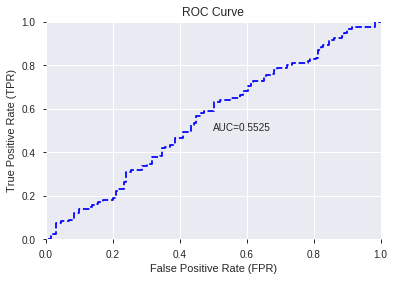

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


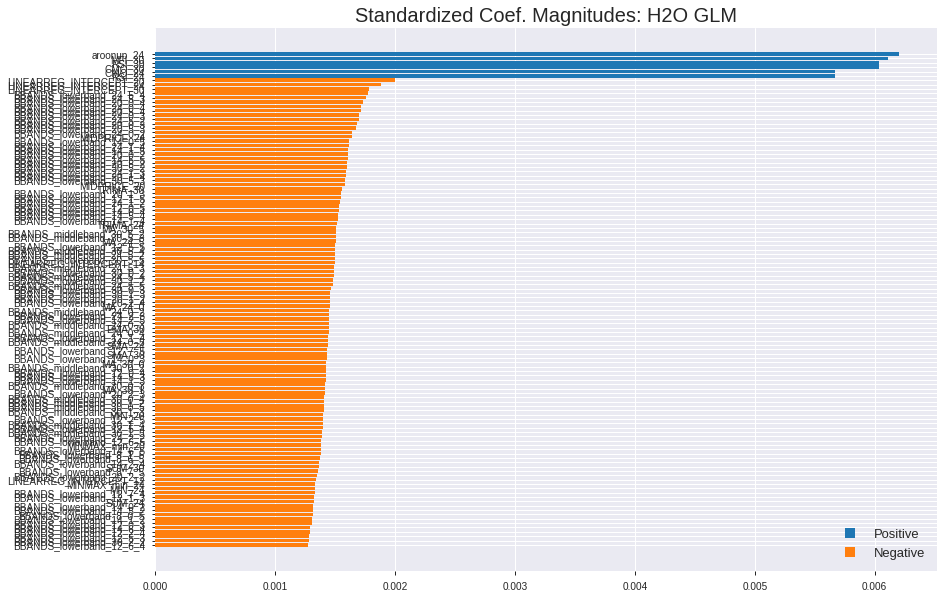

'log_likelihood'
--2019-07-25 04:32:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_043232_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_043232_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['aroonup_24',
 'MFI_30',
 'RSI_30',
 'CMO_30',
 'CMO_24',
 'RSI_24',
 'LINEARREG_INTERCEPT_20',
 'LINEARREG_INTERCEPT_24',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_24_5_3',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_lowerband_24_0_3',
 'BBANDS_lowerband_24_5_2',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_lowerband_24_0_2',
 'MIDPRICE_24',
 'BBANDS_lowerband_14_0_5',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_lowerband_20_0_2',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_lowerband_24_1_3',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_lowerband_30_5_3',
 'MIDPRICE_20',
 'TRIMA_30',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_12_1_5',
 'BBANDS_lowerband_24_1_2',
 'BBANDS_lowerband_12_0_5',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_14_1_4',
 'TRIMA_24',
 'MA_30_5',
 'BBANDS_middleband_30_

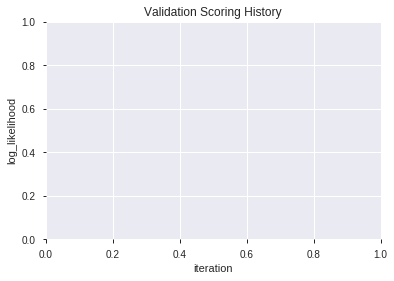

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_043248_model_5  0.548323  0.841914              0.488594  0.557815  0.311157
1  XGBoost_grid_1_AutoML_20190725_043248_model_6  0.512930  0.746913              0.492248  0.524117  0.274699
2               XGBoost_1_AutoML_20190725_043248  0.481859  0.699178              0.461240  0.503011  0.253021
3  XGBoost_grid_1_AutoML_20190725_043248_model_2  0.470390  0.702879              0.458032  0.504815  0.254839
4  XGBoost_grid_1_AutoML_20190725_043248_model_7  0.469088  0.704515              0.488372  0.505592  0.255624
5  XGBoost_grid_1_AutoML_20190725_043248_model_1  0.467531  0.724377              0.500000  0.514692  0.264908
6  XGBoost_grid_1_AutoML_20190725_043248_model_3  0.456094  0.710693              0.500000  0.508541  0.258614
7  XGBoost_grid_1_AutoML_20190725_043248_model_4  0.453838  0.703189              0.500000  0.504968  0.254993
8               XGBoost_3_AutoML_20190725_043248  0.451582  0.712088              0.488372  0.509144  0.259227
9               XGBoost_2_AutoML_20190725_043248  0.436809  0.716053              0.500000  0.511160  0.261285

variable  relative_importance  scaled_importance  percentage
0                      CMO_24          1223.582764           1.000000    0.060982
1      BBANDS_lowerband_8_0_5           963.781738           0.787672    0.048034
2                      MFI_30           852.619019           0.696822    0.042494
3                      CMO_30           805.053040           0.657947    0.040123
4                  aroonup_24           590.015686           0.482203    0.029406
..                        ...                  ...                ...         ...
102  BBANDS_middleband_30_0_2             6.509678           0.005320    0.000324
103                    SUM_30             5.793419           0.004735    0.000289
104  BBANDS_middleband_24_5_4             3.533876           0.002888    0.000176
105  BBANDS_middleband_30_0_5             3.248410           0.002655    0.000162
106  BBANDS_middleband_30_5_5             2.469039           0.002018    0.000123

[107 rows x 4 columns]

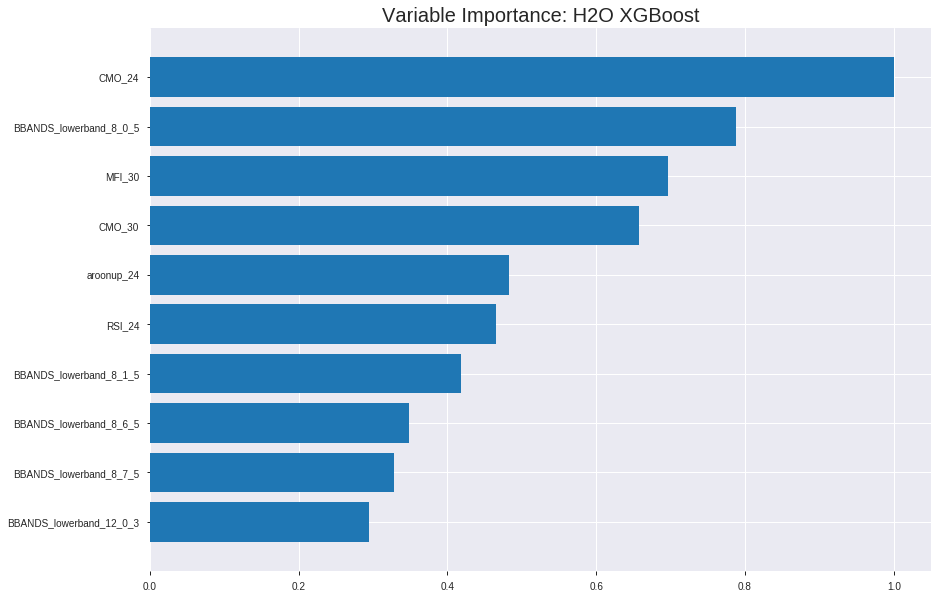

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_043248_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07752317262298104
RMSE: 0.2784298342904026
LogLoss: 0.31043250978381703
Mean Per-Class Error: 0.017707269841060747
AUC: 0.9982031234562209
pr_auc: 0.9974823929743385
Gini: 0.9964062469124417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5355318337678909: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      771  14   0.0178   (14.0/785.0)
1      17   950  0.0176   (17.0/967.0)
Total  788  964  0.0177   (31.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535532     0.983946  202
max f2                       0.488939     0.986436  216
max f0point5                 0.570564     0.987497  192
max accuracy                 0.535532     0.982306  202
max precision                0.938512     1         0
max recall                   0.396363     1         246
max specificity              0.938512     1         0
max absolute_mcc             0.535532     0.964244  202
max min_per_class_accuracy   0.535532     0.982166  202
max mean_per_class_accuracy  0.535532     0.982293  202

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 54.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.906761           1.81179    1.81179            1                0.916529  1                           0.916529            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.897046           1.81179    1.81179            1                0.901462  1                           0.908995            0.0186143       0.0372285                  81.1789   81.1789
    3        0.0302511                   0.892434           1.81179    1.81179            1                0.893779  1                           0.904115            0.0175801       0.0548087                  81.1789   81.1789
    4        0.0405251                   0.883449           1.81179    1.81179            1                0.887717  1                           0.899958            0.0186143       0.073423                   81.1789   81.1789
    5        0.0502283                   0.876385           1.81179    1.81179            1                0.879658  1                           0.896036            0.0175801       0.0910031                  81.1789   81.1789
    6        0.100457                    0.849948           1.81179    1.81179            1                0.862223  1                           0.879129            0.0910031       0.182006                   81.1789   81.1789
    7        0.150114                    0.829105           1.81179    1.81179            1                0.839125  1                           0.865896            0.089969        0.271975                   81.1789   81.1789
    8        0.200342                    0.805766           1.81179    1.81179            1                0.8169    1                           0.853612            0.0910031       0.362978                   81.1789   81.1789
    9        0.300228                    0.76415            1.81179    1.81179            1                0.785596  1                           0.830983            0.180972        0.54395                    81.1789   81.1789
    10       0.400114                    0.716302           1.81179    1.81179            1                0.740592  1                           0.808418            0.180972        0.724922                   81.1789   81.1789
    11       0.5                         0.634134           1.78073    1.80558            0.982857         0.679778  0.996575                    0.782719            0.17787         0.902792                   78.073    80.5584
    12       0.599886                    0.426476           0.962836   1.66526            0.531429         0.533977  0.919125                    0.741301            0.0961737       0.998966                   -3.71635  66.526
    13       0.699772                    0.325797           0.0103531  1.42904            0.00571429       0.367133  0.788744                    0.687892            0.00103413      1                          -98.9647  42.9038
    14       0.799658                    0.254792           0          1.25054            0                0.290802  0.690221                    0.638291            0               1                          -100      25.0535
    15       0.899543                    0.202436           0          1.11168            0                0.227681  0.613579                    0.592697            0               1                          -100      11.1675
    16       1                           0.0836441          0          1                  0                0.160237  0.551941                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.3299321077033727
RMSE: 0.5743971689548728
LogLoss: 0.8772777658492894
Mean Per-Class Error: 0.4066103249475891
AUC: 0.5977545204402516
pr_auc: 0.6340701564173995
Gini: 0.19550904088050314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15535718202590942: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   202  0.9528   (202.0/212.0)
1      3    285  0.0104   (3.0/288.0)
Total  13   487  0.41     (205.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.155357     0.735484  387
max f2                       0.143078     0.872727  397
max f0point5                 0.214043     0.659562  277
max accuracy                 0.214043     0.616     277
max precision                0.659586     0.75      3
max recall                   0.143078     1         397
max specificity              0.7307       0.995283  0
max absolute_mcc             0.245383     0.187271  222
max min_per_class_accuracy   0.256306     0.580189  203
max mean_per_class_accuracy  0.245383     0.59339   222

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 27.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.605838           1.04167   1.04167            0.6              0.669429  0.6                         0.669429            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.535266           0.694444  0.868056           0.4              0.581134  0.5                         0.625281            0.00694444      0.0173611                  -30.5556  -13.1944
    3        0.03                        0.522684           1.73611   1.15741            1                0.530607  0.666667                    0.593723            0.0173611       0.0347222                  73.6111   15.7407
    4        0.04                        0.505816           1.04167   1.12847            0.6              0.519059  0.65                        0.575057            0.0104167       0.0451389                  4.16667   12.8472
    5        0.05                        0.47505            0.694444  1.04167            0.4              0.492732  0.6                         0.558592            0.00694444      0.0520833                  -30.5556  4.16667
    6        0.1                         0.370732           1.04167   1.04167            0.6              0.415841  0.6                         0.487217            0.0520833       0.104167                   4.16667   4.16667
    7        0.15                        0.355419           1.25      1.11111            0.72             0.361219  0.64                        0.445218            0.0625          0.166667                   25        11.1111
    8        0.2                         0.343036           1.11111   1.11111            0.64             0.35059   0.64                        0.421561            0.0555556       0.222222                   11.1111   11.1111
    9        0.3                         0.310261           1.25      1.15741            0.72             0.327378  0.666667                    0.390167            0.125           0.347222                   25        15.7407
    10       0.4                         0.281014           1.18056   1.16319            0.68             0.296263  0.67                        0.366691            0.118056        0.465278                   18.0556   16.3194
    11       0.5                         0.259344           1.00694   1.13194            0.58             0.269929  0.652                       0.347338            0.100694        0.565972                   0.694444  13.1944
    12       0.606                       0.240386           1.04822   1.1173             0.603774         0.249691  0.643564                    0.330258            0.111111        0.677083                   4.8218    11.7299
    13       0.7                         0.217418           0.923463  1.09127            0.531915         0.231321  0.628571                    0.316972            0.0868056       0.763889                   -7.65366  9.12698
    14       0.8                         0.19757            0.798611  1.05469            0.46             0.207146  0.6075                      0.303244            0.0798611       0.84375                    -20.1389  5.46875
    15       0.9                         0.177437           0.763889  1.02238            0.44             0.189147  0.588889                    0.290566            0.0763889       0.920139                   -23.6111  2.23765
    16       1                           0.132086           0.798611  1                  0.46             0.161993  0.576                       0.277709        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:32:55  3.106 sec   0                  0.5              0.693147            0.5             0                  1                0.448059                         0.5                0.693147              0.5               0                    1                  0.424
    2019-07-25 04:32:56  3.423 sec   5                  0.461238         0.618104            0.928498        0.936997           1.81179          0.143836                         0.501502           0.696198              0.585028          0.631768             1.38889            0.424
    2019-07-25 04:32:56  3.663 sec   10                 0.426986         0.555287            0.96807         0.972232           1.81179          0.0896119                        0.501585           0.696527              0.574407          0.632543             1.04167            0.416
    2019-07-25 04:32:56  3.892 sec   15                 0.397092         0.502635            0.981751        0.984587           1.81179          0.0707763                        0.505841           0.7054                0.587231          0.634728             1.04167            0.414
    2019-07-25 04:32:56  4.118 sec   20                 0.372285         0.460205            0.986908        0.987685           1.81179          0.0525114                        0.522249           0.740348              0.595052          0.635509             1.38889            0.412
    2019-07-25 04:32:57  4.344 sec   25                 0.350786         0.424512            0.992611        0.993099           1.81179          0.0410959                        0.533133           0.765454              0.595683          0.63701              1.38889            0.41
    2019-07-25 04:32:57  4.545 sec   30                 0.334006         0.397175            0.994345        0.994468           1.81179          0.0371005                        0.543988           0.791966              0.597492          0.635736             1.04167            0.418
    2019-07-25 04:32:57  4.796 sec   35                 0.315753         0.367936            0.996086        0.99581            1.81179          0.027968                         0.557713           0.826967              0.597615          0.632957             1.04167            0.408
    2019-07-25 04:32:57  5.022 sec   40                 0.30177          0.346199            0.997036        0.996575           1.81179          0.0239726                        0.564313           0.846188              0.596747          0.63399              1.04167            0.414
    2019-07-25 04:32:57  5.254 sec   45                 0.290071         0.328299            0.997655        0.997048           1.81179          0.0222603                        0.565126           0.849553              0.598426          0.63334              1.04167            0.414
    2019-07-25 04:32:58  5.542 sec   50                 0.27843          0.310433            0.998203        0.997482           1.81179          0.0176941                        0.574397           0.877278              0.597755          0.63407              1.04167            0.41

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
CMO_24                    1223.582763671875      1.0                    0.06098240923243241
BBANDS_lowerband_8_0_5    963.78173828125        0.7876718820302906     0.0480341290508514
MFI_30                    852.6190185546875      0.6968216976153254     0.04249386592601605
CMO_30                    805.0530395507812      0.6579473521961693     0.04012321468502213
aroonup_24                590.0156860351562      0.48220333233901225    0.029405920945940252
---                       ---                    ---                    ---
BBANDS_middleband_30_0_2  6.509677886962891      0.005320177825509623   0.0003244372613445402
SUM_30                    5.793418884277344      0.004734799358313738   0.0002887394721021467
BBANDS_middleband_24_5_4  3.533876419067383      0.0028881384439108145  0.00017612564050648982
BBANDS_middleband_30_0_5  3.24841046333313       0.0026548350955720454  0.00016189824024279828
BBANDS_middleband_30_5_5  2.469038724899292      0.0020178763531204886  0.00012305496154644193


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.657608695652174)

('auc', 0.5483225314525352)

('logloss', 0.8419139162535696)

('mean_per_class_error', 0.42883466768331424)

('rmse', 0.5578147182904962)

('mse', 0.3111572599415056)

xgboost prediction progress: |████████████████████████████████████████████| 100%


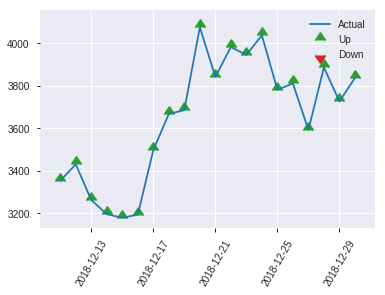


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3111572599415056
RMSE: 0.5578147182904962
LogLoss: 0.8419139162535696
Mean Per-Class Error: 0.42883466768331424
AUC: 0.5483225314525352
pr_auc: 0.5003651853819483
Gini: 0.09664506290507036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1666012853384018: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    125  0.969    (125.0/129.0)
1      1    121  0.0082   (1.0/122.0)
Total  5    246  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166601     0.657609  215
max f2                       0.143187     0.826558  219
max f0point5                 0.216126     0.563798  119
max accuracy                 0.232236     0.569721  86
max precision                0.51235      1         0
max recall                   0.143187     1         219
max specificity              0.51235      1         0
max absolute_mcc             0.216126     0.142986  119
max min_per_class_accuracy   0.219217     0.55814   110
max mean_per_class_accuracy  0.216126     0.571165  119

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 24.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.466364           0.685792  0.685792           0.333333         0.49393   0.333333                    0.49393             0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.457818           0.685792  0.685792           0.333333         0.462833  0.333333                    0.478381            0.00819672      0.0163934                  -31.4208  -31.4208
    3        0.0318725                   0.441688           0         0.514344           0                0.443662  0.25                        0.469701            0               0.0163934                  -100      -48.5656
    4        0.0438247                   0.433724           1.37158   0.748137           0.666667         0.435721  0.363636                    0.460434            0.0163934       0.0327869                  37.1585   -25.1863
    5        0.0517928                   0.418574           1.02869   0.791299           0.5              0.421895  0.384615                    0.454505            0.00819672      0.0409836                  2.86885   -20.8701
    6        0.10757                     0.359045           1.02869   0.91439            0.5              0.377662  0.444444                    0.41466             0.057377        0.0983607                  2.86885   -8.56102
    7        0.151394                    0.304842           1.30924   1.02869            0.636364         0.316953  0.5                         0.386377            0.057377        0.155738                   30.924    2.86885
    8        0.203187                    0.289834           0.633039  0.927837           0.307692         0.297558  0.45098                     0.363737            0.0327869       0.188525                   -36.6961  -7.21633
    9        0.302789                    0.249618           1.39902   1.08283            0.68             0.272498  0.526316                    0.333724            0.139344        0.327869                   39.9016   8.283
    10       0.40239                     0.232194           1.39902   1.16109            0.68             0.238911  0.564356                    0.310255            0.139344        0.467213                   39.9016   16.1094
    11       0.501992                    0.219217           0.987541  1.12666            0.48             0.226534  0.547619                    0.293644            0.0983607       0.565574                   -1.2459   12.6659
    12       0.601594                    0.210114           0.822951  1.07638            0.4              0.214874  0.523179                    0.280603            0.0819672       0.647541                   -17.7049  7.63761
    13       0.701195                    0.200398           1.06984   1.07545            0.52             0.205858  0.522727                    0.269985            0.106557        0.754098                   6.98361   7.54471
    14       0.800797                    0.189176           0.740656  1.03381            0.36             0.194467  0.502488                    0.260593            0.0737705       0.827869                   -25.9344  3.38064
    15       0.900398                    0.181638           0.905246  1.01959            0.44             0.185047  0.495575                    0.252236            0.0901639       0.918033                   -9.47541  1.95851
    16       1                           0.138833           0.822951  1                  0.4              0.168301  0.486056                    0.243876    

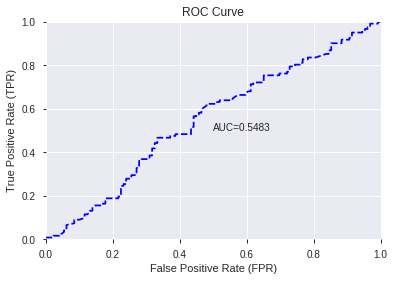

This function is available for GLM models only


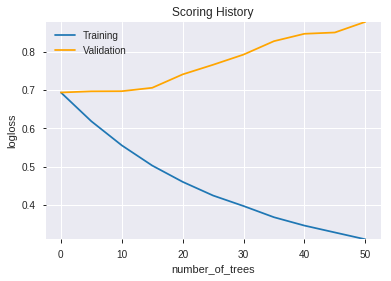

--2019-07-25 04:33:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_043248_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_043248_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CMO_24',
 'BBANDS_lowerband_8_0_5',
 'MFI_30',
 'CMO_30',
 'aroonup_24',
 'RSI_24',
 'BBANDS_lowerband_8_1_5',
 'BBANDS_lowerband_8_6_5',
 'BBANDS_lowerband_8_7_5',
 'BBANDS_lowerband_12_0_3',
 'MIDPRICE_20',
 'LINEARREG_INTERCEPT_30',
 'RSI_30',
 'BBANDS_lowerband_12_0_5',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_lowerband_14_6_5',
 'BBANDS_lowerband_20_1_4',
 'LINEARREG_INTERCEPT_20',
 'BBANDS_lowerband_12_0_4',
 'LINEARREG_INTERCEPT_24',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_12_1_5',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_lowerband_30_0_3',
 'TRIMA_24',
 'BBANDS_lowerband_14_5_5',
 'SMA_24',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_lowerband_12_7_5',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_24_5_4',
 'B

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

87

['BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_upperband_14_1_4',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_middleband_14_2_5',
 'BBANDS_upperband_14_3_2',
 'MAVP_20_0',
 'BBANDS_lowerband_24_5_5',
 'SAR_0.3',
 'BBANDS_upperband_30_7_5',
 'BOP',
 'ADXR_8',
 'aroonup_8',
 'AROONOSC_8',
 'CMO_8',
 'DX_8',
 'MFI_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCR_8',
 'ROCR100_8',
 'TRIX_8',
 'WILLR_8',
 'ADX_12',
 'aroonup_12',
 'MFI_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'ADXR_14',
 'CCI_14',
 'CMO_14',
 'MFI_14',
 'MINUS_DM_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROC_14',
 'aroondown_20',
 'DX_20',
 'MFI_20',
 'ROC_20',
 'WILLR_20',
 'aroonup_24',
 'CCI_24',
 'CMO_24',
 'DX_24',
 'MOM_24',
 'PLUS_DI_24',
 'ROCP_24',
 'ROCR100_24',
 'aroondown_30',
 'CCI_30',
 'CMO_30',
 'MFI_30',
 'MOM_30',
 'PLUS_DI_30',
 'PLUS_DM_30',
 'ROC_30',
 'ROCR_30',
 'ROCR100_30',
 'WILLR_30',
 'MACD_hist',
 'MACDEXT'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_043425_model_7  0.564748   1.001965              0.492470  0.578606  0.334785
1  DeepLearning_grid_1_AutoML_20190725_043425_model_1  0.524527   4.461499              0.496124  0.673839  0.454059
2  DeepLearning_grid_1_AutoML_20190725_043425_model_2  0.518872  15.180956              0.477189  0.697160  0.486031
3  DeepLearning_grid_1_AutoML_20190725_043425_model_4  0.497014   1.080006              0.492470  0.583708  0.340715
4  DeepLearning_grid_1_AutoML_20190725_043425_model_9  0.490405   0.699198              0.500000  0.502998  0.253007
5               DeepLearning_1_AutoML_20190725_043425  0.489897   0.763369              0.477411  0.529531  0.280403
6  DeepLearning_grid_1_AutoML_20190725_043425_model_3  0.479985  14.426460              0.496124  0.694418  0.482217
7  DeepLearning_grid_1_AutoML_20190725_043425_model_6  0.468833   0.699967              0.492248  0.503366  0.253378
8  DeepLearning_grid_1_AutoML_20190725_043425_model_5  0.467531   1.073541              0.480843  0.594002  0.352838
9  DeepLearning_grid_1_AutoML_20190725_043425_model_8  0.467086   0.698131              0.492248  0.502482  0.252488

variable  relative_importance  scaled_importance  percentage
0           PLUS_DI_8             1.000000           1.000000    0.012215
1                 BOP             0.998017           0.998017    0.012191
2        CDLSHORTLINE             0.997726           0.997726    0.012187
3   CDLLONGLEGGEDDOJI             0.997593           0.997593    0.012186
4           CORREL_12             0.989899           0.989899    0.012092
..                ...                  ...                ...         ...
82  LINEARREG_ANGLE_8             0.900249           0.900249    0.010996
83           AVGPRICE             0.900142           0.900142    0.010995
84             CCI_24             0.898202           0.898202    0.010971
85            ROCP_24             0.893398           0.893398    0.010913
86       LINEARREG_12             0.880675           0.880675    0.010757

[87 rows x 4 columns]

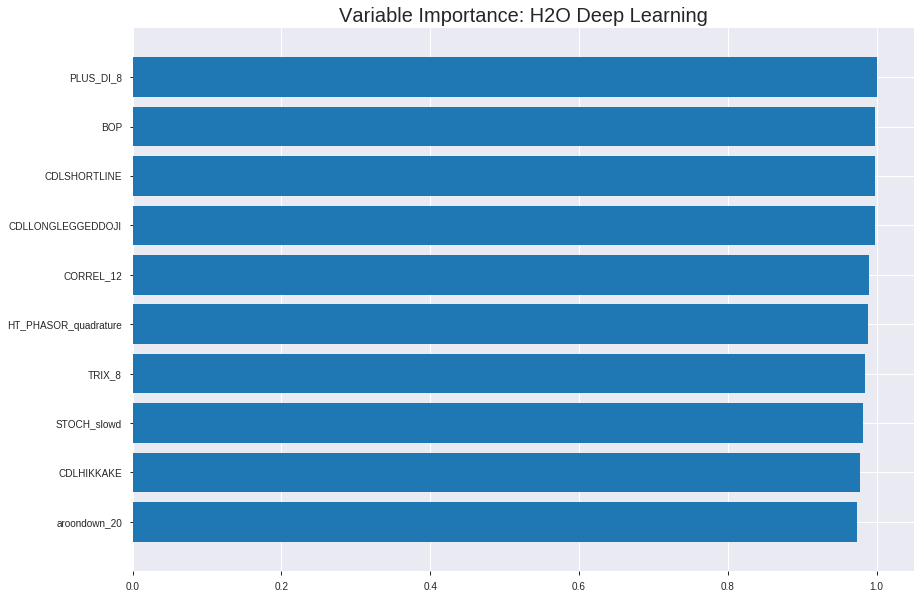

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_043425_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2529174298389633
RMSE: 0.5029089677456182
LogLoss: 0.7253938915867402
Mean Per-Class Error: 0.411432692877703
AUC: 0.6186498396116428
pr_auc: 0.6383305508229877
Gini: 0.23729967922328554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19778310667264676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      108  677   0.8624   (677.0/785.0)
1      34   933   0.0352   (34.0/967.0)
Total  142  1610  0.4058   (711.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197783     0.724098  348
max f2                       0.0978008    0.864043  382
max f0point5                 0.311109     0.643542  307
max accuracy                 0.311109     0.614726  307
max precision                0.999131     1         0
max recall                   0.0505763    1         392
max specificity              0.999131     1         0
max absolute_mcc             0.311109     0.215049  307
max min_per_class_accuracy   0.511687     0.580145  205
max mean_per_class_accuracy  0.47841      0.588567  222

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 53.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.986485           1.40917   1.40917            0.777778         0.993207  0.777778                    0.993207            0.0144778       0.0144778                  40.9169   40.9169
    2        0.0205479                   0.969761           1.30851   1.35884            0.722222         0.977968  0.75                        0.985587            0.0134436       0.0279214                  30.8514   35.8842
    3        0.0302511                   0.958387           1.17233   1.29902            0.647059         0.963644  0.716981                    0.978549            0.0113754       0.0392968                  17.2334   29.9019
    4        0.0405251                   0.938605           0.905895  1.19935            0.5              0.949289  0.661972                    0.971131            0.00930714      0.0486039                  -9.41055  19.9353
    5        0.0502283                   0.928511           1.27891   1.21472            0.705882         0.931978  0.670455                    0.963567            0.0124095       0.0610134                  27.891    21.4722
    6        0.100457                    0.873437           1.21472   1.21472            0.670455         0.897699  0.670455                    0.930633            0.0610134       0.122027                   21.4722   21.4722
    7        0.150114                    0.81836            1.16621   1.19867            0.643678         0.847861  0.661597                    0.903252            0.0579111       0.179938                   16.6209   19.8674
    8        0.200342                    0.763803           1.2559    1.21302            0.693182         0.792743  0.669516                    0.875546            0.0630817       0.24302                    25.5899   21.3021
    9        0.300228                    0.674362           1.12849   1.1849             0.622857         0.719123  0.653992                    0.823504            0.11272         0.355739                   12.8486   18.4896
    10       0.400114                    0.578938           1.11813   1.16823            0.617143         0.626533  0.644793                    0.774331            0.111686        0.467425                   11.8133   16.8229
    11       0.5                         0.513931           1.04566   1.14374            0.577143         0.542464  0.631279                    0.728011            0.104447        0.571872                   4.56611   14.3744
    12       0.599886                    0.463876           0.993896  1.11879            0.548571         0.488651  0.617507                    0.688156            0.0992761       0.671148                   -0.61043  11.8793
    13       0.699772                    0.407509           0.97319   1.09801            0.537143         0.433846  0.606036                    0.651855            0.0972079       0.768356                   -2.68105  9.80092
    14       0.799658                    0.337528           0.993896  1.085              0.548571         0.375363  0.598858                    0.617318            0.0992761       0.867632                   -0.61043  8.50043
    15       0.899543                    0.22859            0.797187  1.05304            0.44             0.287977  0.581218                    0.580748            0.0796277       0.94726                    -20.2813  5.30449
    16       1                           0.00528193         0.525007  1                  0.289773         0.14923   0.551941                    0.537399         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.37370020311127994
RMSE: 0.611310234750965
LogLoss: 1.2762759526139094
Mean Per-Class Error: 0.4390068134171907
AUC: 0.5525091719077568
pr_auc: 0.608625161595636
Gini: 0.10501834381551367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.8517231342367575e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    288  0        (0.0/288.0)
Total  0    500  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.85172e-05  0.730964  399
max f2                       4.85172e-05  0.871671  399
max f0point5                 0.083756     0.640044  324
max accuracy                 0.083756     0.59      324
max precision                0.840321     1         0
max recall                   4.85172e-05  1         399
max specificity              0.840321     1         0
max absolute_mcc             0.165856     0.123484  262
max min_per_class_accuracy   0.213832     0.538194  220
max mean_per_class_accuracy  0.165856     0.560993  262

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 24.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.732129           1.04167   1.04167            0.6              0.787616    0.6                         0.787616            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.645926           1.04167   1.04167            0.6              0.687482    0.6                         0.737549            0.0104167       0.0208333                  4.16667   4.16667
    3        0.03                        0.604253           1.38889   1.15741            0.8              0.62443     0.666667                    0.699843            0.0138889       0.0347222                  38.8889   15.7407
    4        0.04                        0.578233           1.38889   1.21528            0.8              0.588198    0.7                         0.671932            0.0138889       0.0486111                  38.8889   21.5278
    5        0.05                        0.556639           1.04167   1.18056            0.6              0.569562    0.68                        0.651458            0.0104167       0.0590278                  4.16667   18.0556
    6        0.1                         0.504938           0.972222  1.07639            0.56             0.529168    0.62                        0.590313            0.0486111       0.107639                   -2.77778  7.63889
    7        0.15                        0.472828           1.18056   1.11111            0.68             0.48834     0.64                        0.556322            0.0590278       0.166667                   18.0556   11.1111
    8        0.2                         0.419125           1.04167   1.09375            0.6              0.439782    0.63                        0.527187            0.0520833       0.21875                    4.16667   9.375
    9        0.3                         0.326277           0.902778  1.03009            0.52             0.368528    0.593333                    0.474301            0.0902778       0.309028                   -9.72222  3.00926
    10       0.4                         0.262151           1.18056   1.06771            0.68             0.293527    0.615                       0.429107            0.118056        0.427083                   18.0556   6.77083
    11       0.5                         0.214426           1.07639   1.06944            0.62             0.239924    0.616                       0.391271            0.107639        0.534722                   7.63889   6.94444
    12       0.6                         0.168241           1.11111   1.07639            0.64             0.192199    0.62                        0.358092            0.111111        0.645833                   11.1111   7.63889
    13       0.7                         0.119889           0.902778  1.05159            0.52             0.145157    0.605714                    0.327673            0.0902778       0.736111                   -9.72222  5.15873
    14       0.8                         0.0700647          0.902778  1.03299            0.52             0.0926292   0.595                       0.298292            0.0902778       0.826389                   -9.72222  3.29861
    15       0.9                         0.013924           0.833333  1.0108             0.48             0.0337758   0.582222                    0.268902            0.0833333       0.909722                   -16.6667  1.08025
    16       1                           3.90137e-08        0.902778  1                  0.52             0.00429723  0.576      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:41:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:41:45  6.825 sec         219 obs/sec       0.672945  1             1179       0.558834         0.907517            -0.26281       0.494435        0.54879            0.905895         0.445776                         0.635077           2.19208               -0.651449        0.44175           0.518702             1.04167            0.424
    2019-07-25 04:42:00  21.863 sec        429 obs/sec       4.66381   7             8171       0.502909         0.725394            -0.0227061     0.61865         0.638331           1.40917          0.405822                         0.61131            1.27628               -0.530153        0.552509          0.608625             1.04167            0.424
    2019-07-25 04:42:16  37.657 sec        489 obs/sec       9.31963   14            16328      0.58864          1.04385             -0.401109      0.706567        0.749916           1.81179          0.371005                         0.649122           1.71368               -0.725298        0.452634          0.543533             0.694444           0.424
    2019-07-25 04:42:31  53.021 sec        517 obs/sec       13.9715   21            24478      0.488738         0.674199            0.0341177      0.778213        0.801864           1.81179          0.303082                         0.646482           1.96499               -0.711294        0.480223          0.54656              0.694444           0.424
    2019-07-25 04:42:46  1 min  8.027 sec  535 obs/sec       18.633    28            32645      0.521701         0.853418            -0.100565      0.837248        0.837585           1.81179          0.261416                         0.634605           3.1314                -0.648994        0.440399          0.48297              0.694444           0.424
    2019-07-25 04:43:01  1 min 23.103 sec  547 obs/sec       23.3071   35            40834      0.422478         0.527632            0.278259       0.844306        0.836298           1.81179          0.235731                         0.686915           3.55951               -0.932049        0.54459           0.5759               1.04167            0.424
    2019-07-25 04:43:16  1 min 38.150 sec  555 obs/sec       28.0114   42            49076      0.408155         0.519562            0.326367       0.910731        0.85337            1.81179          0.166096                         0.618152           2.4297                -0.564594        0.534689          0.586062             1.04167            0.424
    2019-07-25 04:43:18  1 min 39.590 sec  555 obs/sec       28.0114   42            49076      0.502909         0.725394            -0.0227061     0.61865         0.638331           1.40917          0.405822                         0.61131            1.27628               -0.530153        0.552509          0.608625             1.04167            0.424

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
PLUS_DI_8          1.0                    1.0                  0.012214928742556492
BOP                0.9980166554450989     0.9980166554450989   0.012190702330146437
CDLSHORTLINE       0.997725784778595      0.997725784778595    0.012187149365681792
CDLLONGLEGGEDDOJI  0.9975928068161011     0.9975928068161011   0.012185525049345598
CORREL_12          0.989899218082428      0.989899218082428    0.012091548411189246
---                ---                    ---                  ---
LINEARREG_ANGLE_8  0.900248646736145      0.900248646736145    0.010996473070464923
AVGPRICE           0.9001418948173523     0.9001418948173523   0.010995169103383738
CCI_24             0.8982018828392029     0.8982018828392029   0.010971471995310938
ROCP_24            0.893397867679596      0.893397867679596    0.010912791292458177
LINEARREG_12       0.8806753158569336     0.8806753158569336   0.010757386228520875


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.6558265582655827)

('auc', 0.5647477443131275)

('logloss', 1.0019651117533894)

('mean_per_class_error', 0.4287075867327488)

('rmse', 0.5786062001954625)

('mse', 0.3347851349046316)

deeplearning prediction progress: |███████████████████████████████████████| 100%


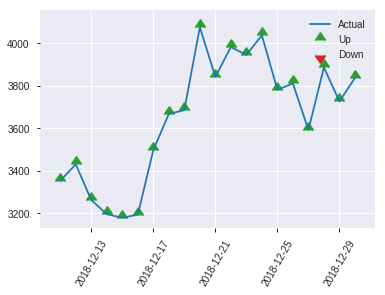


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3347851349046316
RMSE: 0.5786062001954625
LogLoss: 1.0019651117533894
Mean Per-Class Error: 0.4287075867327488
AUC: 0.5647477443131275
pr_auc: 0.5326938234380054
Gini: 0.12949548862625493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0036902227640547183: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    126  0.9767   (126.0/129.0)
1      1    121  0.0082   (1.0/122.0)
Total  4    247  0.506    (127.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00369022   0.655827  246
max f2                       0.00098103   0.82544   250
max f0point5                 0.144954     0.571776  174
max accuracy                 0.211204     0.569721  103
max precision                0.517471     1         0
max recall                   0.00098103   1         250
max specificity              0.517471     1         0
max absolute_mcc             0.144954     0.155104  174
max min_per_class_accuracy   0.192338     0.54918   123
max mean_per_class_accuracy  0.144954     0.571292  174

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 19.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.414139           2.05738   2.05738            1                0.459778   1                           0.459778            0.0245902       0.0245902                  105.738   105.738
    2        0.0239044                   0.403607           0.685792  1.37158            0.333333         0.405015   0.666667                    0.432397            0.00819672      0.0327869                  -31.4208  37.1585
    3        0.0318725                   0.393954           1.02869   1.28586            0.5              0.395798   0.625                       0.423247            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.378318           0.685792  1.12221            0.333333         0.386572   0.545455                    0.413245            0.00819672      0.0491803                  -31.4208  12.2206
    5        0.0517928                   0.364645           1.02869   1.10782            0.5              0.366391   0.538462                    0.406037            0.00819672      0.057377                   2.86885   10.7818
    6        0.103586                    0.327632           1.10782   1.10782            0.538462         0.343698   0.538462                    0.374867            0.057377        0.114754                   10.7818   10.7818
    7        0.151394                    0.295088           0.85724   1.02869            0.416667         0.306935   0.5                         0.353415            0.0409836       0.155738                   -14.276   2.86885
    8        0.203187                    0.279492           0.949559  1.00852            0.461538         0.286885   0.490196                    0.336456            0.0491803       0.204918                   -5.04414  0.851816
    9        0.302789                    0.25111            1.39902   1.13697            0.68             0.263006   0.552632                    0.312295            0.139344        0.344262                   39.9016   13.6972
    10       0.40239                     0.212499           1.15213   1.14072            0.56             0.230747   0.554455                    0.29211             0.114754        0.459016                   15.2131   14.0724
    11       0.501992                    0.191257           0.905246  1.094              0.44             0.201906   0.531746                    0.274212            0.0901639       0.54918                    -9.47541  9.40021
    12       0.601594                    0.164071           0.905246  1.06275            0.44             0.174719   0.516556                    0.25774             0.0901639       0.639344                   -9.47541  6.27511
    13       0.701195                    0.144822           1.31672   1.09883            0.64             0.154564   0.534091                    0.243084            0.131148        0.770492                   31.6721   9.88264
    14       0.800797                    0.112593           0.822951  1.06451            0.4              0.129589   0.517413                    0.228968            0.0819672       0.852459                   -17.7049  6.45135
    15       0.900398                    0.0320328          0.740656  1.02869            0.36             0.0715336  0.5                         0.211553            0.0737705       0.92623                    -25.9344  2.86885
    16       1                           0.00098103         0.740656  1                  0.36             0.0120496  0.486056                  

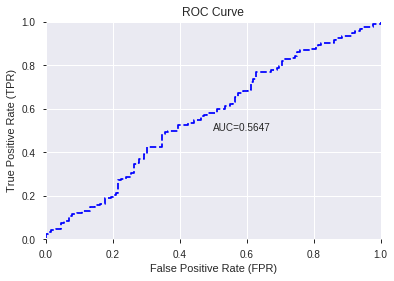

This function is available for GLM models only


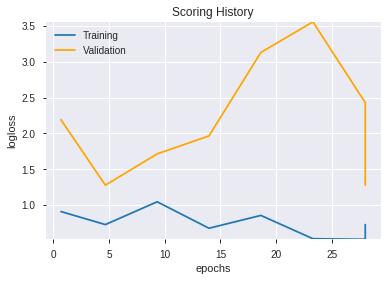

--2019-07-25 04:47:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.135.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.135.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_043425_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_043425_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['PLUS_DI_8',
 'BOP',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'TRIX_8',
 'STOCH_slowd',
 'CDLHIKKAKE',
 'aroondown_20',
 'DX_20',
 'TRANGE',
 'BBANDS_upperband_14_1_4',
 'BETA_12',
 'MFI_14',
 'MINUS_DI_12',
 'ROCR100_30',
 'HT_PHASOR_inphase',
 'WILLR_20',
 'MFI_12',
 'STOCHRSI_fastd',
 'MFI_30',
 'ROC_30',
 'MOM_14',
 'ROCR_12',
 'MACDEXT',
 'MACD_hist',
 'aroonup_8',
 'BBANDS_lowerband_14_2_2',
 'ROC_20',
 'WILLR_12',
 'ROCP_12',
 'MFI_20',
 'STOCH_slowk',
 'BBANDS_upperband_14_3_2',
 'ADX_12',
 'CCI_30',
 'MAVP_20_0',
 'ROCR100_24',
 'BBANDS_middleband_14_2_5',
 'MOM_24',
 'DX_24',
 'SAR_0.3',
 'STDDEV_8',
 'PLUS_DI_14',
 'PLUS_DM_30',
 'MFI_8',
 'DX_8',
 'ROCR_8',
 'CMO_24',
 'MINUS_DM_14',
 'WILLR_8',
 'ROCR100_12',
 'ROC_14',
 'ADXR_14',
 'LINEARREG_SLOPE_8',
 'aroonup_12',
 'CMO_14',
 'ROCR100_8',
 'PLUS_DI_24',
 'aroonup_24',
 'BBANDS_upperband_14_0_5',
 'CMO_8',
 'BBANDS_upperband_30_7_5',
 'STOCHRSI_fastk',
 'PLUS_DM_12',
 'CCI_14',
 'P

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190725_044731_model_1  0.519443  0.918068              0.481065  0.57919  0.335461

variable  relative_importance  scaled_importance  percentage
0                aroonup_24             0.005617           1.000000    0.025264
1                    MFI_30             0.005560           0.989957    0.025011
2   BBANDS_lowerband_14_0_4             0.005511           0.981099    0.024787
3   BBANDS_lowerband_14_2_4             0.005410           0.963192    0.024334
4                    CMO_30             0.005244           0.933701    0.023589
..                      ...                  ...                ...         ...
82                   MOM_30             0.000185           0.032908    0.000831
83                PLUS_DI_8             0.000155           0.027640    0.000698
84                  ADXR_14             0.000105           0.018726    0.000473
85                   CCI_14             0.000049           0.008795    0.000222
86                MACD_hist             0.000044           0.007827    0.000198

[87 rows x 4 columns]

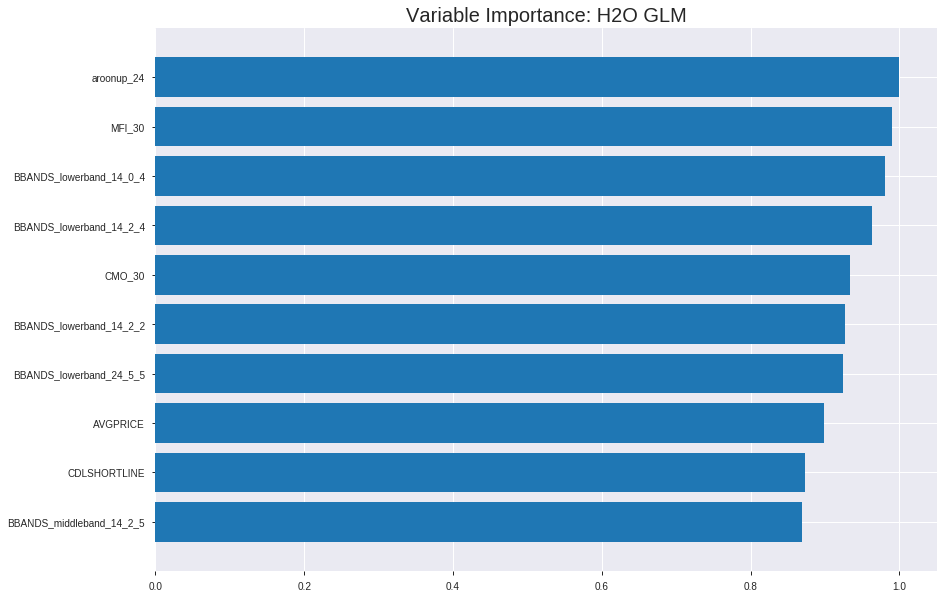

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_044731_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24450711427620794
RMSE: 0.49447660639934016
LogLoss: 0.6820628940578547
Null degrees of freedom: 1751
Residual degrees of freedom: 1664
Null deviance: 2409.84717619812
Residual deviance: 2389.948380778723
AIC: 2565.948380778723
AUC: 0.5718842832583536
pr_auc: 0.6132921983351218
Gini: 0.14376856651670722
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4906017466232222: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    782   0.9962   (782.0/785.0)
1      1    966   0.001    (1.0/967.0)
Total  4    1748  0.4469   (783.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490602     0.711602  396
max f2                       0.47729      0.86032   399
max f0point5                 0.517738     0.613721  338
max accuracy                 0.528937     0.567352  295
max precision                0.634471     0.75      3
max recall                   0.47729      1         399
max specificity              0.654929     0.998726  0
max absolute_mcc             0.581402     0.116583  105
max min_per_class_accuracy   0.54887      0.551189  219
max mean_per_class_accuracy  0.550605     0.558045  212

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.620562           1.20786   1.20786            0.666667         0.629186  0.666667                    0.629186            0.0124095       0.0124095                  20.7859   20.7859
    2        0.0205479                   0.615204           1.00655   1.1072             0.555556         0.617559  0.611111                    0.623373            0.0103413       0.0227508                  0.654947  10.7204
    3        0.0302511                   0.612453           1.27891   1.16228            0.705882         0.613601  0.641509                    0.620238            0.0124095       0.0351603                  27.891    16.228
    4        0.0405251                   0.609789           1.1072    1.14832            0.611111         0.611167  0.633803                    0.617939            0.0113754       0.0465357                  10.7204   14.8317
    5        0.0502283                   0.60775            1.49206   1.21472            0.823529         0.608603  0.670455                    0.616135            0.0144778       0.0610134                  49.2062   21.4722
    6        0.100457                    0.592475           1.33825   1.27649            0.738636         0.600287  0.704545                    0.608211            0.0672182       0.128232                   33.8253   27.6488
    7        0.150114                    0.583046           1.16621   1.24001            0.643678         0.586942  0.684411                    0.601175            0.0579111       0.186143                   16.6209   24.0008
    8        0.200342                    0.576182           0.988249  1.17689            0.545455         0.579379  0.649573                    0.595711            0.0496381       0.235781                   -1.17514  17.6889
    9        0.300228                    0.566539           1.07672   1.14356            0.594286         0.570659  0.631179                    0.587376            0.107549        0.34333                    7.67203   14.3563
    10       0.400114                    0.557784           1.0146    1.11137            0.56             0.562196  0.613409                    0.58109             0.101344        0.444674                   1.46019   11.1368
    11       0.5                         0.549105           1.02495   1.09411            0.565714         0.553806  0.603881                    0.575639            0.102378        0.547053                   2.49549   9.41055
    12       0.599886                    0.540846           0.921424  1.06535            0.508571         0.544813  0.588011                    0.570507            0.0920372       0.63909                    -7.85759  6.53526
    13       0.699772                    0.533272           0.952483  1.04924            0.525714         0.537187  0.579119                    0.56575             0.0951396       0.73423                    -4.75166  4.92416
    14       0.799658                    0.525032           0.931777  1.03457            0.514286         0.529171  0.571021                    0.561181            0.0930714       0.827301                   -6.82228  3.4569
    15       0.899543                    0.517395           0.94213   1.0243             0.52             0.521598  0.565355                    0.556786            0.0941055       0.921406                   -5.78697  2.43046
    16       1                           0.47729            0.782363  1                  0.431818         0.508552  0.551941                    0.551941           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.32050295689097263
RMSE: 0.5661298056903317
LogLoss: 0.9376701170504755
Null degrees of freedom: 499
Residual degrees of freedom: 412
Null deviance: 682.7250417755
Residual deviance: 937.6701170504755
AIC: 1113.6701170504755
AUC: 0.585167714884696
pr_auc: 0.632870749594223
Gini: 0.17033542976939198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.030254347213464115: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   190  0.8962   (190.0/212.0)
1      11   277  0.0382   (11.0/288.0)
Total  33   467  0.402    (201.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0302543    0.733775  374
max f2                       0.0134299    0.872199  398
max f0point5                 0.0810578    0.649087  334
max accuracy                 0.0810578    0.606     334
max precision                0.543136     0.722222  16
max recall                   0.0134299    1         398
max specificity              0.564523     0.995283  0
max absolute_mcc             0.393142     0.153069  173
max min_per_class_accuracy   0.382051     0.545139  192
max mean_per_class_accuracy  0.393142     0.577077  173

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 31.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.558828           0.347222  0.347222           0.2              0.562913   0.2                         0.562913            0.00347222      0.00347222                 -65.2778  -65.2778
    2        0.02                        0.556739           1.38889   0.868056           0.8              0.557902   0.5                         0.560407            0.0138889       0.0173611                  38.8889   -13.1944
    3        0.03                        0.547981           1.73611   1.15741            1                0.555346   0.666667                    0.55872             0.0173611       0.0347222                  73.6111   15.7407
    4        0.04                        0.539994           1.04167   1.12847            0.6              0.543356   0.65                        0.554879            0.0104167       0.0451389                  4.16667   12.8472
    5        0.05                        0.536575           1.38889   1.18056            0.8              0.538059   0.68                        0.551515            0.0138889       0.0590278                  38.8889   18.0556
    6        0.1                         0.524112           1.18056   1.18056            0.68             0.52893    0.68                        0.540223            0.0590278       0.118056                   18.0556   18.0556
    7        0.15                        0.512591           1.11111   1.15741            0.64             0.518383   0.666667                    0.532943            0.0555556       0.173611                   11.1111   15.7407
    8        0.2                         0.505381           1.25      1.18056            0.72             0.508634   0.68                        0.526865            0.0625          0.236111                   25        18.0556
    9        0.3                         0.483097           1.18056   1.18056            0.68             0.495176   0.68                        0.516302            0.118056        0.354167                   18.0556   18.0556
    10       0.4                         0.403013           1.04167   1.14583            0.6              0.446419   0.66                        0.498832            0.104167        0.458333                   4.16667   14.5833
    11       0.5                         0.382623           0.833333  1.08333            0.48             0.393056   0.624                       0.477676            0.0833333       0.541667                   -16.6667  8.33333
    12       0.6                         0.29085            0.972222  1.06481            0.56             0.318332   0.613333                    0.451119            0.0972222       0.638889                   -2.77778  6.48148
    13       0.7                         0.165228           0.9375    1.04663            0.54             0.231115   0.602857                    0.41969             0.09375         0.732639                   -6.25     4.6627
    14       0.8                         0.100114           1.11111   1.05469            0.64             0.131995   0.6075                      0.383728            0.111111        0.84375                    11.1111   5.46875
    15       0.9                         0.0525177          0.833333  1.03009            0.48             0.0786106  0.593333                    0.349826            0.0833333       0.927083                   -16.6667  3.00926
    16       1                           0.0131063          0.729167  1                  0.42             0.0266804  0.576                     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:47:31  0.000 sec   2            4.9       88            1.36413           1.87534
    2019-07-25 04:47:31  0.024 sec   4            3.1       88            1.36174           2.14721
    2019-07-25 04:47:31  0.046 sec   6            1.9       88            1.3592            2.43168
    2019-07-25 04:47:31  0.068 sec   8            1.2       88            1.3564            2.68875
    2019-07-25 04:47:31  0.096 sec   10           0.73      88            1.35326           2.88596

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6593406593406594)

('auc', 0.5194433854365231)

('logloss', 0.9180680928873076)

('mean_per_class_error', 0.45583936967848526)

('rmse', 0.5791896141817219)

('mse', 0.33546060917597187)

glm prediction progress: |████████████████████████████████████████████████| 100%


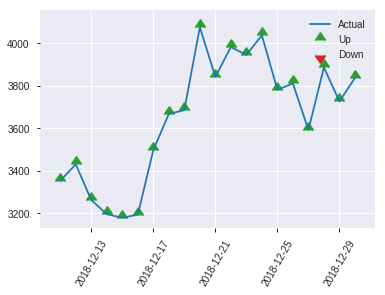


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.33546060917597187
RMSE: 0.5791896141817219
LogLoss: 0.9180680928873076
Null degrees of freedom: 250
Residual degrees of freedom: 163
Null deviance: 352.1428302126968
Residual deviance: 460.8701826294284
AIC: 636.8701826294284
AUC: 0.5194433854365231
pr_auc: 0.4932039988072954
Gini: 0.03888677087304626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10682640012761678: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    122  0.9457   (122.0/129.0)
1      2    120  0.0164   (2.0/122.0)
Total  9    242  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.106826     0.659341  241
max f2                       0.0961325    0.82544   250
max f0point5                 0.127107     0.55501   223
max accuracy                 0.173646     0.537849  181
max precision                0.321931     0.615385  12
max recall                   0.0961325    1         250
max specificity              0.342484     0.992248  0
max absolute_mcc             0.114545     0.110663  235
max min_per_class_accuracy   0.192099     0.508197  124
max mean_per_class_accuracy  0.173646     0.544161  181

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 19.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.338994           0.685792  0.685792           0.333333         0.340475  0.333333                    0.340475            0.00819672      0.00819672                 -31.4208  -31.4208
    2        0.0239044                   0.329559           1.37158   1.02869            0.666667         0.335013  0.5                         0.337744            0.0163934       0.0245902                  37.1585   2.86885
    3        0.0318725                   0.327624           1.02869   1.02869            0.5              0.32887   0.5                         0.335525            0.00819672      0.0327869                  2.86885   2.86885
    4        0.0438247                   0.325227           1.37158   1.12221            0.666667         0.326189  0.545455                    0.332979            0.0163934       0.0491803                  37.1585   12.2206
    5        0.0517928                   0.321833           2.05738   1.26608            1                0.322128  0.615385                    0.33131             0.0163934       0.0655738                  105.738   26.6078
    6        0.103586                    0.290979           0.791299  1.02869            0.384615         0.306831  0.5                         0.31907             0.0409836       0.106557                   -20.8701  2.86885
    7        0.151394                    0.237849           1.02869   1.02869            0.5              0.270196  0.5                         0.303636            0.0491803       0.155738                   2.86885   2.86885
    8        0.203187                    0.203112           0.791299  0.968177           0.384615         0.210018  0.470588                    0.279773            0.0409836       0.196721                   -20.8701  -3.18226
    9        0.302789                    0.198099           1.06984   1.00162            0.52             0.199678  0.486842                    0.253426            0.106557        0.303279                   6.98361   0.161777
    10       0.40239                     0.195539           0.740656  0.937023           0.36             0.196842  0.455446                    0.23942             0.0737705       0.377049                   -25.9344  -6.29768
    11       0.501992                    0.192021           1.31672   1.01236            0.64             0.193748  0.492063                    0.230358            0.131148        0.508197                   31.6721   1.23601
    12       0.601594                    0.186445           1.23443   1.04913            0.6              0.189386  0.509934                    0.223575            0.122951        0.631148                   23.4426   4.9126
    13       0.701195                    0.177931           1.06984   1.05207            0.52             0.182264  0.511364                    0.217707            0.106557        0.737705                   6.98361   5.20678
    14       0.800797                    0.152652           0.822951  1.02357            0.4              0.162728  0.497512                    0.210869            0.0819672       0.819672                   -17.7049  2.35707
    15       0.900398                    0.126193           1.06984   1.02869            0.52             0.141505  0.5                         0.203196            0.106557        0.92623                    6.98361   2.86885
    16       1                           0.0961325          0.740656  1                  0.36             0.110138  0.486056                    0.193927      

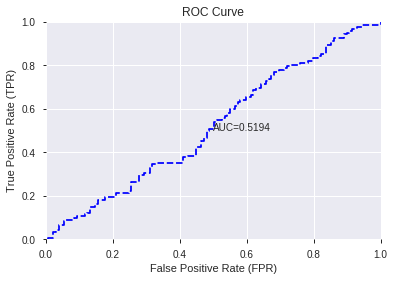

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


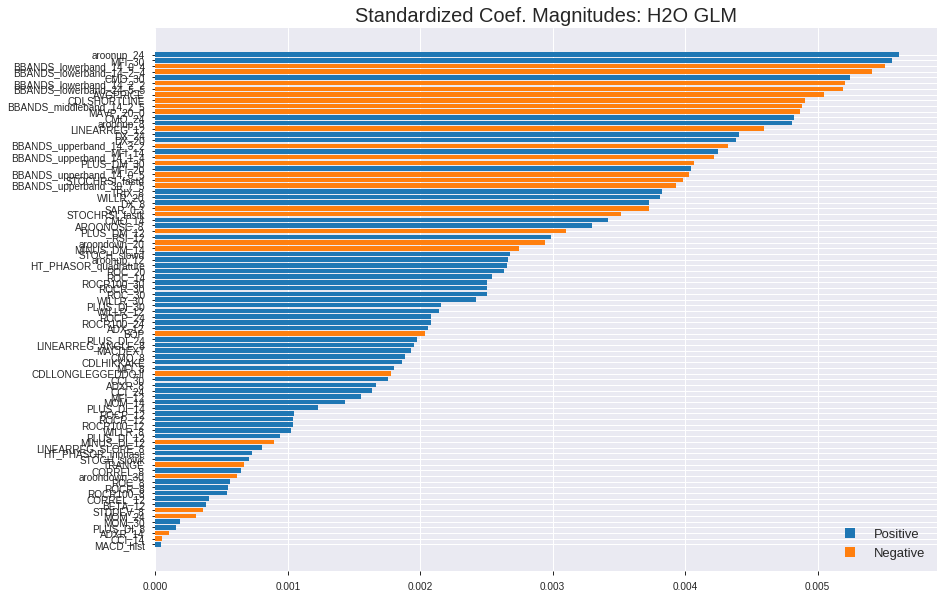

'log_likelihood'
--2019-07-25 04:47:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_044731_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_044731_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['aroonup_24',
 'MFI_30',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_lowerband_14_2_4',
 'CMO_30',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_lowerband_24_5_5',
 'AVGPRICE',
 'CDLSHORTLINE',
 'BBANDS_middleband_14_2_5',
 'MAVP_20_0',
 'CMO_24',
 'aroonup_8',
 'LINEARREG_12',
 'DX_24',
 'DX_20',
 'BBANDS_upperband_14_3_2',
 'MFI_14',
 'BBANDS_upperband_14_1_4',
 'PLUS_DM_30',
 'MFI_20',
 'BBANDS_upperband_14_0_5',
 'STOCHRSI_fastd',
 'BBANDS_upperband_30_7_5',
 'TRIX_8',
 'WILLR_20',
 'DX_8',
 'SAR_0.3',
 'STOCHRSI_fastk',
 'CMO_14',
 'AROONOSC_8',
 'PLUS_DM_12',
 'RSI_12',
 'aroondown_20',
 'MINUS_DM_14',
 'STOCH_slowd',
 'aroonup_12',
 'HT_PHASOR_quadrature',
 'ROC_20',
 'ROC_14',
 'ROCR100_30',
 'ROCR_30',
 'ROC_30',
 'WILLR_30',
 'PLUS_DI_30',
 'WILLR_12',
 'ROCP_24',
 'ROCR100_24',
 'ADX_12',
 'BOP',
 'PLUS_DI_24',
 'LINEARREG_ANGLE_8',
 'MACDEXT',
 'CMO_8',
 'CDLHIKKAKE',
 'MFI_8',
 'CDLLONGLEGGEDDOJI',
 'CCI_30',
 'ADXR_8',
 'CCI_24',
 'MFI_12',
 'MOM_14',
 'PLUS_DI_14',
 'ROCP_12',
 'ROCR_1

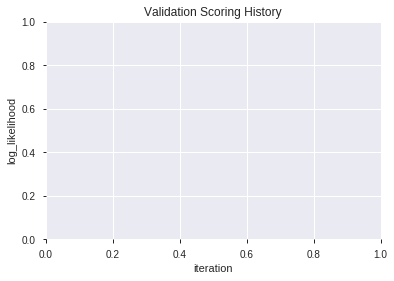

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_044749_model_1  0.560872  0.686882              0.480620  0.496937  0.246946
1               XGBoost_1_AutoML_20190725_044749  0.546448  0.698799              0.492248  0.502730  0.252738
2               XGBoost_3_AutoML_20190725_044749  0.544415  0.690143              0.500000  0.498470  0.248473
3               XGBoost_2_AutoML_20190725_044749  0.536091  0.698081              0.500000  0.502422  0.252428
4  XGBoost_grid_1_AutoML_20190725_044749_model_3  0.529102  0.697357              0.496124  0.502026  0.252030
5  XGBoost_grid_1_AutoML_20190725_044749_model_5  0.523828  0.714581              0.492470  0.509641  0.259734
6  XGBoost_grid_1_AutoML_20190725_044749_model_6  0.512136  0.704212              0.484496  0.505394  0.255423
7  XGBoost_grid_1_AutoML_20190725_044749_model_7  0.511310  0.706947              0.492248  0.506609  0.256653
8  XGBoost_grid_1_AutoML_20190725_044749_model_2  0.510294  0.695800              0.500000  0.501282  0.251284
9  XGBoost_grid_1_AutoML_20190725_044749_model_4  0.508483  0.695493              0.488594  0.501163  0.251164

variable  relative_importance  scaled_importance  percentage
0         MFI_20           196.992401           1.000000    0.041019
1         CMO_24           187.742401           0.953044    0.039093
2     PLUS_DM_12           164.054306           0.832795    0.034161
3          DX_24           158.819534           0.806222    0.033071
4         RSI_12           147.686005           0.749704    0.030752
..           ...                  ...                ...         ...
76    ROCR100_30             6.354717           0.032259    0.001323
77        ROCR_8             6.010299           0.030510    0.001252
78  aroondown_20             4.443097           0.022555    0.000925
79     MAVP_20_0             4.388111           0.022276    0.000914
80    aroonup_12             1.838858           0.009335    0.000383

[81 rows x 4 columns]

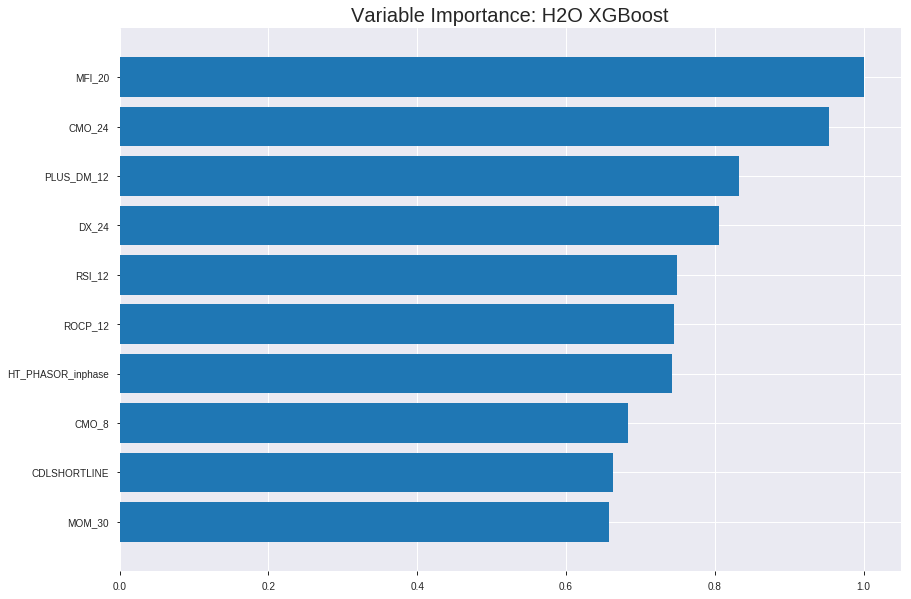

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_044749_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18340652074642164
RMSE: 0.4282598752468198
LogLoss: 0.5542861198109298
Mean Per-Class Error: 0.1868435439569487
AUC: 0.8993894044882393
pr_auc: 0.9145827271582375
Gini: 0.7987788089764787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518037328353295: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      577  208   0.265    (208.0/785.0)
1      107  860   0.1107   (107.0/967.0)
Total  684  1068  0.1798   (315.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518037     0.845209  222
max f2                       0.462722     0.903684  272
max f0point5                 0.579696     0.845235  163
max accuracy                 0.518037     0.820205  222
max precision                0.850235     1         0
max recall                   0.327876     1         361
max specificity              0.850235     1         0
max absolute_mcc             0.518037     0.636478  222
max min_per_class_accuracy   0.541379     0.808917  199
max mean_per_class_accuracy  0.524702     0.813156  215

Gains/Lift Table: Avg response rate: 55.19 %, avg score: 54.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.800935           1.81179   1.81179            1                0.825965  1                           0.825965            0.0186143       0.0186143                  81.1789   81.1789
    2        0.0205479                   0.776151           1.81179   1.81179            1                0.787622  1                           0.806793            0.0186143       0.0372285                  81.1789   81.1789
    3        0.0302511                   0.762343           1.81179   1.81179            1                0.76897   1                           0.794661            0.0175801       0.0548087                  81.1789   81.1789
    4        0.0405251                   0.752628           1.81179   1.81179            1                0.757334  1                           0.785198            0.0186143       0.073423                   81.1789   81.1789
    5        0.0502283                   0.736919           1.81179   1.81179            1                0.744464  1                           0.777329            0.0175801       0.0910031                  81.1789   81.1789
    6        0.100457                    0.691776           1.72943   1.77061            0.954545         0.711314  0.977273                    0.744321            0.0868666       0.17787                    72.9435   77.0612
    7        0.150114                    0.669526           1.74931   1.76357            0.965517         0.681378  0.973384                    0.7235              0.0868666       0.264736                   74.9314   76.3567
    8        0.200342                    0.650676           1.75002   1.76017            0.965909         0.660639  0.97151                     0.70774             0.0879007       0.352637                   75.0024   76.0171
    9        0.300228                    0.613742           1.66685   1.72912            0.92             0.632409  0.954373                    0.682677            0.166494        0.519131                   66.6846   72.9122
    10       0.400114                    0.582886           1.37696   1.64121            0.76             0.598175  0.905849                    0.661582            0.137539        0.65667                    37.696    64.1207
    11       0.5                         0.550424           1.18025   1.54912            0.651429         0.566778  0.855023                    0.642643            0.11789         0.77456                    18.0251   54.9121
    12       0.599886                    0.519769           1.02495   1.46184            0.565714         0.535526  0.806851                    0.624807            0.102378        0.876939                   2.49549   46.1843
    13       0.699772                    0.485795           0.621185  1.34185            0.342857         0.503296  0.74062                     0.607462            0.0620476       0.938987                   -37.8815  34.1847
    14       0.799658                    0.446996           0.434829  1.22855            0.24             0.468086  0.678087                    0.590053            0.0434333       0.98242                    -56.5171  22.8551
    15       0.899543                    0.394009           0.13459   1.10708            0.0742857        0.42121   0.611041                    0.571304            0.0134436       0.995863                   -86.541   10.7077
    16       1                           0.203346           0.041177  1                  0.0227273        0.337629  0.551941                    0.54783          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24971003736633626
RMSE: 0.4997099532392128
LogLoss: 0.6930539796890642
Mean Per-Class Error: 0.41145833333333337
AUC: 0.5508877096436059
pr_auc: 0.6269946019155892
Gini: 0.10177541928721179
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2718733847141266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    210  0.9906   (210.0/212.0)
1      0    288  0        (0.0/288.0)
Total  2    498  0.42     (210.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.271873     0.732824  397
max f2                       0.271873     0.872727  397
max f0point5                 0.271873     0.631579  397
max accuracy                 0.271873     0.58      397
max precision                0.795947     1         0
max recall                   0.271873     1         397
max specificity              0.795947     1         0
max absolute_mcc             0.545357     0.183237  141
max min_per_class_accuracy   0.505791     0.537736  203
max mean_per_class_accuracy  0.545357     0.588542  141

Gains/Lift Table: Avg response rate: 57.60 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.728524           1.04167   1.04167            0.6              0.758831  0.6                         0.758831            0.0104167       0.0104167                  4.16667   4.16667
    2        0.02                        0.714637           0.694444  0.868056           0.4              0.724618  0.5                         0.741724            0.00694444      0.0173611                  -30.5556  -13.1944
    3        0.03                        0.692322           1.38889   1.04167            0.8              0.706262  0.6                         0.729904            0.0138889       0.03125                    38.8889   4.16667
    4        0.04                        0.676745           1.73611   1.21528            1                0.684426  0.7                         0.718534            0.0173611       0.0486111                  73.6111   21.5278
    5        0.05                        0.663608           1.04167   1.18056            0.6              0.671944  0.68                        0.709216            0.0104167       0.0590278                  4.16667   18.0556
    6        0.1                         0.622125           1.31944   1.25               0.76             0.638682  0.72                        0.673949            0.0659722       0.125                      31.9444   25
    7        0.15                        0.600026           1.04167   1.18056            0.6              0.60904   0.68                        0.652313            0.0520833       0.177083                   4.16667   18.0556
    8        0.2                         0.589191           1.31944   1.21528            0.76             0.593396  0.7                         0.637584            0.0659722       0.243056                   31.9444   21.5278
    9        0.3                         0.555847           1.14583   1.19213            0.66             0.570304  0.686667                    0.615157            0.114583        0.357639                   14.5833   19.213
    10       0.4                         0.534836           0.9375    1.12847            0.54             0.546256  0.65                        0.597932            0.09375         0.451389                   -6.25     12.8472
    11       0.5                         0.507052           0.833333  1.06944            0.48             0.521483  0.616                       0.582642            0.0833333       0.534722                   -16.6667  6.94444
    12       0.6                         0.488268           0.868056  1.03588            0.5              0.498157  0.596667                    0.568561            0.0868056       0.621528                   -13.1944  3.58796
    13       0.7                         0.468299           0.833333  1.00694            0.48             0.478034  0.58                        0.555629            0.0833333       0.704861                   -16.6667  0.694444
    14       0.8                         0.438214           1.00694   1.00694            0.58             0.454865  0.58                        0.543033            0.100694        0.805556                   0.694444  0.694444
    15       0.9                         0.398521           0.868056  0.991512           0.5              0.421916  0.571111                    0.529576            0.0868056       0.892361                   -13.1944  -0.848765
    16       1                           0.219072           1.07639   1                  0.62             0.35341   0.576                       0.511959          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:47:52  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.448059                         0.5                0.693147              0.5               0                    1                  0.424
    2019-07-25 04:47:52  0.099 sec   5                  0.48726          0.667893            0.759239        0.80139            1.81179          0.349886                         0.497768           0.688682              0.497289          0.580509             0.992063           0.424
    2019-07-25 04:47:53  0.145 sec   10                 0.476309         0.646462            0.795259        0.828131           1.81179          0.291667                         0.497071           0.687258              0.517959          0.605881             1.04167            0.422
    2019-07-25 04:47:53  0.193 sec   15                 0.466663         0.627743            0.822903        0.850166           1.81179          0.258562                         0.496527           0.68618               0.536352          0.607368             1.04167            0.424
    2019-07-25 04:47:53  0.246 sec   20                 0.458345         0.611645            0.840056        0.862834           1.81179          0.245434                         0.49669            0.686442              0.530071          0.616704             1.38889            0.418
    2019-07-25 04:47:53  0.296 sec   25                 0.451122         0.597826            0.858586        0.880035           1.81179          0.222603                         0.495959           0.68494               0.537834          0.621337             1.38889            0.418
    2019-07-25 04:47:53  0.348 sec   30                 0.445544         0.587011            0.868207        0.887637           1.81179          0.215183                         0.495195           0.683383              0.548652          0.632037             1.38889            0.42
    2019-07-25 04:47:53  0.395 sec   35                 0.441552         0.57932             0.873411        0.893032           1.81179          0.2129                           0.495857           0.684819              0.553418          0.631116             1.04167            0.42
    2019-07-25 04:47:53  0.438 sec   40                 0.438447         0.573351            0.87806         0.897142           1.81179          0.207763                         0.49664            0.686486              0.551911          0.62797              1.04167            0.42
    2019-07-25 04:47:53  0.488 sec   45                 0.43322          0.563553            0.888638        0.904882           1.81179          0.199201                         0.499283           0.69209               0.551379          0.627114             1.04167            0.42
    2019-07-25 04:47:53  0.538 sec   50                 0.42826          0.554286            0.899389        0.914583           1.81179          0.179795                         0.49971            0.693054              0.550888          0.626995             1.04167            0.42

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ----------------------
MFI_20        196.99240112304688     1.0                   0.04101933529278666
CMO_24        187.74240112304688     0.9530438740415058    0.03909322621804486
PLUS_DM_12    164.05430603027344     0.8327950981611753    0.034160701361662424
DX_24         158.8195343017578      0.8062216278208354    0.0330706752718791
RSI_12        147.68600463867188     0.7497040687697549    0.030752362567232964
---           ---                    ---                   ---
ROCR100_30    6.354717254638672      0.03225869230696539   0.0013232301158462509
ROCR_8        6.010298728942871      0.03051030747723448   0.001251512532294697
aroondown_20  4.44309663772583       0.022554660039655793  0.0009251771625814577
MAVP_20_0     4.388110637664795      0.022275532521296902  0.000913727537316451
aroonup_12    1.838857650756836      0.009334662861478778  0.00038290166576012135


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6630434782608696)

('auc', 0.5608717753208794)

('logloss', 0.6868820119405673)

('mean_per_class_error', 0.4170161392807218)

('rmse', 0.49693677423494864)

('mse', 0.24694615758703634)

xgboost prediction progress: |████████████████████████████████████████████| 100%


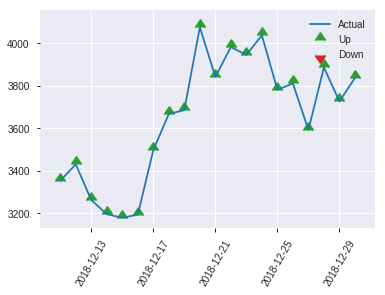


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24694615758703634
RMSE: 0.49693677423494864
LogLoss: 0.6868820119405673
Mean Per-Class Error: 0.4170161392807218
AUC: 0.5608717753208794
pr_auc: 0.5557641424094542
Gini: 0.12174355064175879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37202706933021545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    124  0.9612   (124.0/129.0)
1      0    122  0        (0.0/122.0)
Total  5    246  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372027     0.663043  244
max f2                       0.372027     0.831063  244
max f0point5                 0.454301     0.558568  198
max accuracy                 0.551091     0.589641  64
max precision                0.757302     1         0
max recall                   0.372027     1         244
max specificity              0.757302     1         0
max absolute_mcc             0.551091     0.189359  64
max min_per_class_accuracy   0.510843     0.532787  123
max mean_per_class_accuracy  0.551091     0.582984  64

Gains/Lift Table: Avg response rate: 48.61 %, avg score: 51.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.740825           1.37158   1.37158            0.666667         0.747832  0.666667                    0.747832            0.0163934       0.0163934                  37.1585   37.1585
    2        0.0239044                   0.72836            1.37158   1.37158            0.666667         0.733681  0.666667                    0.740756            0.0163934       0.0327869                  37.1585   37.1585
    3        0.0318725                   0.699001           1.02869   1.28586            0.5              0.723098  0.625                       0.736342            0.00819672      0.0409836                  2.86885   28.5861
    4        0.0438247                   0.665517           2.05738   1.49627            1                0.669857  0.727273                    0.71821             0.0245902       0.0655738                  105.738   49.6274
    5        0.0517928                   0.629033           0         1.26608            0                0.645989  0.615385                    0.707099            0               0.0655738                  -100      26.6078
    6        0.103586                    0.607298           1.42434   1.34521            0.692308         0.616215  0.653846                    0.661657            0.0737705       0.139344                   42.4338   34.5208
    7        0.151394                    0.576625           1.20014   1.2994             0.583333         0.585771  0.631579                    0.637693            0.057377        0.196721                   20.0137   29.9396
    8        0.203187                    0.565117           1.26608   1.2909             0.615385         0.571803  0.627451                    0.620897            0.0655738       0.262295                   26.6078   29.0903
    9        0.302789                    0.544708           0.987541  1.19111            0.48             0.552669  0.578947                    0.598454            0.0983607       0.360656                   -1.2459   19.1113
    10       0.40239                     0.528939           0.905246  1.12035            0.44             0.537694  0.544554                    0.583414            0.0901639       0.45082                    -9.47541  12.0354
    11       0.501992                    0.510804           0.822951  1.06135            0.4              0.520271  0.515873                    0.570886            0.0819672       0.532787                   -17.7049  6.13453
    12       0.601594                    0.496205           0.822951  1.02188            0.4              0.502433  0.496689                    0.559553            0.0819672       0.614754                   -17.7049  2.1876
    13       0.701195                    0.479476           0.987541  1.017              0.48             0.486292  0.494318                    0.549146            0.0983607       0.713115                   -1.2459   1.69989
    14       0.800797                    0.452189           1.31672   1.05428            0.64             0.463969  0.512438                    0.538552            0.131148        0.844262                   31.6721   5.42778
    15       0.900398                    0.425928           0.576066  1.00138            0.28             0.440745  0.486726                    0.527733            0.057377        0.901639                   -42.3934  0.137821
    16       1                           0.288434           0.987541  1                  0.48             0.386203  0.486056                    0.513636         

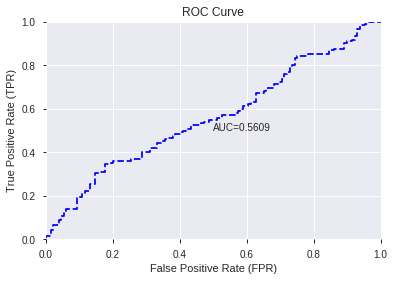

This function is available for GLM models only


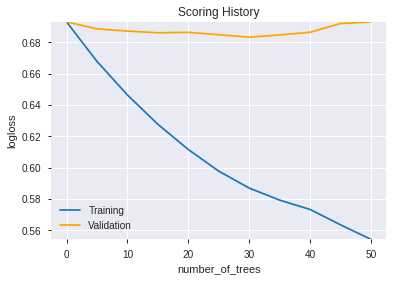

--2019-07-25 04:48:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_044749_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_044749_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b707',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['MFI_20',
 'CMO_24',
 'PLUS_DM_12',
 'DX_24',
 'RSI_12',
 'ROCP_12',
 'HT_PHASOR_inphase',
 'CMO_8',
 'CDLSHORTLINE',
 'MOM_30',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'CORREL_12',
 'MFI_30',
 'STOCH_slowd',
 'BBANDS_lowerband_14_0_4',
 'MINUS_DM_14',
 'BETA_12',
 'WILLR_20',
 'STOCHRSI_fastk',
 'PLUS_DI_24',
 'TRANGE',
 'MFI_12',
 'CMO_14',
 'DX_20',
 'STOCH_slowk',
 'PLUS_DI_14',
 'LINEARREG_ANGLE_8',
 'ROC_14',
 'BOP',
 'BBANDS_lowerband_14_2_2',
 'CORREL_8',
 'MFI_14',
 'PLUS_DI_30',
 'MACD_hist',
 'ADXR_14',
 'CCI_14',
 'MFI_8',
 'aroonup_24',
 'ROC_20',
 'CMO_30',
 'STDDEV_8',
 'CCI_30',
 'SAR_0.3',
 'ADX_12',
 'aroondown_30',
 'WILLR_8',
 'WILLR_30',
 'ROC_8',
 'BBANDS_lowerband_24_5_5',
 'LINEARREG_12',
 'LINEARREG_SLOPE_8',
 'DX_8',
 'TRIX_8',
 'WILLR_12',
 'BBANDS_upperband_14_0_5',
 'MACDEXT',
 'PLUS_DI_8',
 'ADXR_8',
 'ROC_30',
 'PLUS_DI_12',
 'MINUS_DI_12',
 'PLUS_DM_30',
 'ROCP_24',
 'BBANDS_lowerband_14_2_4',
 'ROCR_12',
 'MOM_14',
 'aroonup_8',
 'AVGPRICE',
 'BBA

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.582
GLM             0.562
XGBoost         0.590
dtype: float64

DeepLearning    GLM  XGBoost
All          0.546  0.538     0.55
DLF          0.538  0.530     0.55
Fwe          0.582  0.562     0.57
RFE          0.570  0.538     0.59
XGBF         0.558  0.530     0.55





F1


DeepLearning    0.659
GLM             0.663
XGBoost         0.663
dtype: float64

DeepLearning    GLM  XGBoost
All          0.658  0.661    0.656
DLF          0.654  0.663    0.654
Fwe          0.657  0.663    0.658
RFE          0.656  0.659    0.663
XGBF         0.659  0.663    0.654





auc


DeepLearning    0.565
GLM             0.552
XGBoost         0.561
dtype: float64

DeepLearning    GLM  XGBoost
All          0.547  0.521    0.537
DLF          0.519  0.508    0.536
Fwe          0.563  0.552    0.548
RFE          0.565  0.519    0.561
XGBF         0.531  0.508    0.536





logloss


DeepLearning    8.550
GLM             2.064
XGBoost         0.842
dtype: float64

DeepLearning    GLM  XGBoost
All          8.550  2.064    0.712
DLF          0.807  0.697    0.703
Fwe          7.233  1.902    0.842
RFE          1.002  0.918    0.687
XGBF         0.951  0.697    0.703





mean_per_class_error


DeepLearning    0.463
GLM             0.473
XGBoost         0.454
dtype: float64

DeepLearning    GLM  XGBoost
All          0.450  0.459    0.446
DLF          0.463  0.473    0.454
Fwe          0.415  0.436    0.429
RFE          0.429  0.456    0.417
XGBF         0.448  0.473    0.454





rmse


DeepLearning    0.697
GLM             0.677
XGBoost         0.558
dtype: float64

DeepLearning    GLM  XGBoost
All          0.681  0.677    0.509
DLF          0.541  0.502    0.505
Fwe          0.697  0.676    0.558
RFE          0.579  0.579    0.497
XGBF         0.578  0.502    0.505





mse


DeepLearning    0.486
GLM             0.458
XGBoost         0.311
dtype: float64

DeepLearning    GLM  XGBoost
All          0.463  0.458    0.259
DLF          0.292  0.252    0.255
Fwe          0.486  0.456    0.311
RFE          0.335  0.335    0.247
XGBF         0.334  0.252    0.255

{'F1':       DeepLearning    GLM  XGBoost
 All          0.658    NaN      NaN
 DLF          0.654    NaN      NaN
 DLF            NaN  0.663      NaN
 DLF            NaN    NaN    0.654
 All            NaN  0.661      NaN
 All            NaN    NaN    0.656
 XGBF         0.659    NaN      NaN
 XGBF           NaN  0.663      NaN
 XGBF           NaN    NaN    0.654
 Fwe          0.657    NaN      NaN
 Fwe            NaN  0.663      NaN
 Fwe            NaN    NaN    0.658
 RFE          0.656    NaN      NaN
 RFE            NaN  0.659      NaN
 RFE            NaN    NaN    0.663,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.546    NaN      NaN
 DLF          0.538    NaN      NaN
 DLF            NaN  0.530      NaN
 DLF            NaN    NaN     0.55
 All            NaN  0.538      NaN
 All            NaN    NaN     0.55
 XGBF         0.558    NaN      NaN
 XGBF           NaN  0.530      NaN
 XGBF           NaN    NaN     0.55
 Fwe          0.582    NaN      NaN
 Fwe     